# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [18]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (738, 1280, 3)


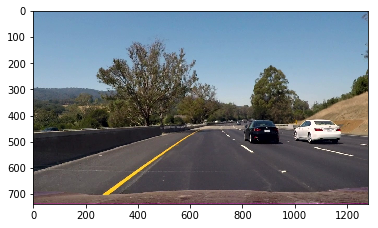

In [19]:
#reading in an image
image = mpimg.imread('test_images/vlcsnap-00001.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [85]:
import math
history_avg_left_xposition=[] 
history_avg_left_yposition=[]
history_avg_right_xposition=[]
history_avg_right_yposition=[]
history_slope_right=[]
history_slope_left=[]
counting =0

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    sum_right_line = 0
    sum_left_line = 0
    num_right_line = 0
    num_left_line = 0
    avg_right_line = 0
    sum_right_xposition = 0
    sum_right_yposition = 0
    sum_left_xposition = 0
    sum_left_yposition = 0
    
    right_array = []
    del_right_array = []
    left_array = []
    del_left_array = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            #drawing all lines out
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #define acceptable slope range
            middle_num = 0.65 
            range_for_middle_num = 0.25
            
            #I try to get the slope value
            slope = ((y2-y1)/(x2-x1))
            #then seperate the left/right ones and abandon horizontal lines or over tilt lines
            if slope > 0 and x1 > (img.shape[1]/2) and x2 > (img.shape[1]/2) : #possible right lines
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num :
                    #print('right slope is ',((y2-y1)/(x2-x1)))
                    sum_right_line += slope
                    num_right_line += 1
                    right_array.append([x1,y1])
                    right_array.append([x2,y2])
                    sum_right_xposition += (x1 + x2)
                    sum_right_yposition += (y1 + y2)
                    
                    #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 10)
                    
            elif slope < 0: #possible left lines
                
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num and x1 < (img.shape[1]/2) and x2 < (img.shape[1]/2):
                    print('left slope is ',((y2-y1)/(x2-x1)))
                    print('slope=',slope)
                    sum_left_line += slope
                    num_left_line += 1
                    left_array.append([x1,y1])
                    left_array.append([x2,y2])
                    sum_left_xposition += (x1 + x2)
                    sum_left_yposition += (y1 + y2)
                    #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 10)
                   
    
    #print('slope is ',((y2-y1)/(x2-x1)))
            
    #average slope calculation
    if(num_right_line !=0 and num_left_line != 0):
        avg_slope_right = sum_right_line/num_right_line
        avg_slope_left = sum_left_line/num_left_line
        avg_right_xposition = sum_right_xposition/(num_right_line*2)
        avg_right_yposition = sum_right_yposition/(num_right_line*2)
        avg_left_xposition = sum_left_xposition / (num_left_line*2)
        avg_left_yposition = sum_left_yposition / (num_left_line*2)
    else:
        avg_left_xposition = history_avg_left_xposition[len(history_avg_left_xposition)-1]
        avg_left_yposition = history_avg_left_yposition[len(history_avg_left_yposition)-1]
        avg_right_xposition = history_avg_right_xposition[len(history_avg_right_xposition)-1]
        avg_right_yposition = history_avg_right_yposition[len(history_avg_right_yposition)-1]
        avg_slope_right = history_slope_right[len(history_slope_right)-1]
        avg_slope_left = history_slope_left[len(history_slope_left)-1]
    
    
    #check and decide if this pic is same video with previous one , it should be here to check
    # This reason why after 3 pics, left green line is tilt , is that history sum up first second and thrid left x y position all together.
    # so we need to check if this pic is same video with previous one.
    if(len(history_avg_left_xposition)!=0):
        print('previous avg_left xposition is ',history_avg_left_xposition[len(history_avg_left_xposition)-1])
        if(abs(avg_left_xposition - history_avg_left_xposition[len(history_avg_left_xposition)-1]) > 20):
            print('history reset !!!!!!!!!!!!!!!!!')
            history_avg_left_xposition.clear()
            history_avg_left_xposition.clear()
            history_avg_left_yposition.clear()
            history_avg_right_xposition.clear()
            history_avg_right_yposition.clear()
            history_slope_right.clear()
            history_slope_left.clear()
            counting =0
    
    
    
    history_slope_right.append(avg_slope_right)
    history_slope_left.append(avg_slope_left)

    
    print('avg left position is x=',avg_left_xposition,' y= ',avg_left_yposition )
    print('avg right slope is x=',avg_slope_right,' avg left slope= ',avg_slope_left )
    
    
    right_array.sort(reverse=True)
    left_array.sort(reverse=True)
    # for further delete some irrelevant points 
    for i in range(len(right_array)):
        #print('i is ',i,' right array i0 is ',right_array[i][0],'i1 is ', right_array[i][1])
        if (abs(right_array[i][0]-avg_right_xposition) > img.shape[1]/96*25) or (abs(right_array[i][1]-avg_right_yposition) > img.shape[0]*2/9): 
            del_right_array.append(i)

    for i in range(len(left_array)):
        print('i is ',i,' left array x is ',left_array[i][0],'y is ', left_array[i][1])
        if (abs(left_array[i][0]-avg_left_xposition) > img.shape[1]/96*25) or (abs(left_array[i][1]-avg_left_yposition) > img.shape[0]*2/9): 
            del_left_array.append(i)
    
    
    # for deleting some point are not in the descendant order
    
    for i in range(0,len(right_array)-2,1):
        #print ('new-right i is ', i,'i0= ',right_array[i][0],' i+1 0=',right_array[i+1][0],' i+2 0=',right_array[i+2][0] )
        if (right_array[i][1]-right_array[i+1][1]<-3) and (right_array[i][1]-right_array[i+2][1]<-3):
            del_right_array.append(i+1)
            del_right_array.append(i+2)
    for i in range(0,len(left_array)-2,1):
        print ('new left i is ', i,'i0= ',left_array[i][0],' i+1 0=',left_array[i+1][0],' i+2 0=',left_array[i+2][0] )
        if (left_array[i][1]-left_array[i+1][1]>3) and (left_array[i][1]-left_array[i+2][1]>3):
            del_left_array.append(i+1)
            del_left_array.append(i+2)
    
    
    
    
        
    #print('del array is ', del_right_array)
    # re-arrange array
    new_del_right_array = sorted(set(del_right_array))
    new_del_left_array = sorted(set(del_left_array))
    print('del left array is ', new_del_left_array)
    del_right_array.sort()
    del_left_array.sort()
    for v in reversed(new_del_right_array):
        #print('v is ', v)
        del right_array[v]
    for v in reversed(new_del_left_array):
        print('new del left v is ', v)
        del left_array[v]
    
    #print('avg right slope is ',avg_slope_right)
    #print('avg left slope is ',avg_slope_left)
    #print('right array is ', right_array)
    #right_x1_position = int(round((right_array[0][0]+right_array[1][0])/2))
    
    if(len(right_array) <= 0):
        right_x1_position = avg_right_xposition
    else:
        right_x1_position = int(round((right_array[0][0]+right_array[1][0])/2))
        
    last_index_left_array = len(left_array)-1
    print('last index left array is',last_index_left_array)
    if(last_index_left_array < 0):
        left_x1_position = avg_left_xposition
    else:
        left_x1_position = int(round((left_array[last_index_left_array][0]+left_array[last_index_left_array-1][0])/2))
    
    #min_line_x_position = (right_x1_position + left_x1_position)/2
    min_line_x_position = img.shape[1]/2
    print('min line is ', min_line_x_position)
      
    
    # calculate again the avg x y position for drawing final line
    sum_right_xposition = 0
    sum_right_yposition = 0
    sum_left_xposition = 0
    sum_left_yposition = 0
    for i in range(len(right_array)):
        sum_right_xposition += right_array[i][0]
        sum_right_yposition += right_array[i][1]
        
    for i in range(len(left_array)):
        sum_left_xposition += left_array[i][0]
        sum_left_yposition += left_array[i][1]
      
    if(len(right_array)==0):
        avg_right_xposition = history_avg_right_xposition[len(history_avg_right_xposition)-1]
        avg_right_yposition = history_avg_right_yposition[len(history_avg_right_yposition)-1]
    else:
        avg_right_xposition = sum_right_xposition/(len(right_array))
        avg_right_yposition = sum_right_yposition/(len(right_array))
    
    if(len(left_array)==0):
        avg_left_xposition = history_avg_left_xposition[len(history_avg_left_xposition)-1]
        avg_left_yposition = history_avg_left_yposition[len(history_avg_left_yposition)-1]
    else:
        avg_left_xposition = sum_left_xposition/(len(left_array))
        avg_left_yposition = sum_left_yposition/(len(left_array))
    
    
    print('avg left x position= ',avg_left_xposition)
    print('avg left y position= ',avg_left_yposition)
    #After checking each avg x y position, I found that sometimes there are not enough points to have avg stable x y position
    #Need a filter to filter out such situation


    
    history_avg_left_xposition.append(avg_left_xposition)
    history_avg_left_yposition.append(avg_left_yposition)
    avg_leftx_his_all = sum(history_avg_left_xposition)/len(history_avg_left_xposition)
    avg_lefty_his_all = sum(history_avg_left_yposition)/len(history_avg_left_yposition)
    
    
    print('length of history_avg_left_xposition',len(history_avg_left_xposition))
    print('length of history_avg_left_yposition',len(history_avg_left_yposition))
    print('avg leftx his all=',avg_leftx_his_all)
    print('avg lefty his all=',avg_lefty_his_all)
    
    if(abs(avg_left_xposition - avg_leftx_his_all)>img.shape[1]/192):
        print('leftx')
        avg_left_xposition = avg_leftx_his_all
    if(abs(avg_left_yposition - avg_lefty_his_all)>img.shape[0]/192):
        print('lefty')
        avg_left_yposition = avg_lefty_his_all
        
    ##### still need right filteravg_his_slope_right
    history_avg_right_xposition.append(avg_right_xposition)
    history_avg_right_yposition.append(avg_right_yposition)
    avg_rightx_his_all = sum(history_avg_right_xposition)/len(history_avg_right_xposition)
    avg_righty_his_all = sum(history_avg_right_yposition)/len(history_avg_right_yposition)
    if(abs(avg_right_xposition - avg_rightx_his_all)>img.shape[1]/192):
        #print('leftx')
        avg_right_xposition = avg_rightx_his_all
    if(abs(avg_right_yposition - avg_righty_his_all)>img.shape[0]/192):
        #print('lefty')
        avg_right_yposition = avg_righty_his_all
    
    #calculate the average slope for history each frame
    if(len(history_slope_left) != 0):
        avg_his_slope_left = sum(history_slope_left)/len(history_slope_left)
        avg_his_slope_right = sum(history_slope_right)/len(history_slope_right)
    else:
        avg_his_slope_left 
    
    
    
    
    last_index_right_array = len(right_array)-1
    last_index_left_array = len(left_array)-1
    
    #calculate  points for slope
    final_x1_right=right_x1_position
    if(len(right_array)==0):
        final_y1_right = avg_right_yposition
    else:
        final_y1_right=right_array[0][1]
    
    final_y2_right=int(round(avg_right_yposition))
    final_x2_right=int(round(avg_right_xposition))
    
    final_x1_left=left_x1_position
    if(last_index_left_array < 0):
        final_y1_left = avg_left_yposition
    else:
        final_y1_left=left_array[last_index_left_array][1] 
    
    final_y2_left=int(round(avg_left_yposition))
    final_x2_left=int(round(avg_left_xposition))
    print('final_x1_left=',final_x1_left,'avg_slope_left=',avg_slope_left,'final_x2_left=',final_x2_left)
    print('final_y1_left=',final_y1_left,'avg_slope_right=',avg_slope_right,'final_y2_left=',final_y2_left)
    
    
    #calculate final extrapolated points for drawing
    if (final_y1_right - img.shape[0])< -(img.shape[0]/18): 
        final_x1_right = int(round((imshape[0]-final_y1_right)/avg_his_slope_right+final_x1_right))
        final_y1_right = int(round(imshape[0]))
        
    if (final_y2_right - (img.shape[0]*16/27)) > (img.shape[0]/18):
        #print('final_y2_right=',final_y2_right,'avg_slope_right=',avg_slope_right,'final_x2_right=',final_x2_right)
        final_x2_right = int(round((img.shape[0]*17/27)-final_y2_right)/avg_his_slope_right+final_x2_right)
        final_y2_right = int(round((img.shape[0]*17/27)))
    
    if (final_y1_left - img.shape[0])< -(img.shape[0]/18):
        print('final_y1_left=',final_y1_left,'avg_slope_left=',avg_slope_left,'final_x1_left=',final_x1_left)
        final_x1_left = int(round((img.shape[0]-final_y1_left)/avg_his_slope_left+final_x1_left))
        final_y1_left = int(round(img.shape[0]))
        
    if (final_y2_left - (img.shape[0]*16/27)) > (img.shape[0]/18):
        print('final_y2_left=',final_y2_left,'avg_slope_left=',avg_slope_left,'final_x2_left=',final_x2_left)
        final_x2_left = int(round((img.shape[0]*17/27)-final_y2_left)/avg_his_slope_left+final_x2_left)
        final_y2_left = int(round((img.shape[0]*17/27)))
    
    print('after extrapolated')
    print('final_x1_left=',final_x1_left,'avg_slope_left=',avg_slope_left,'final_x2_left=',final_x2_left)
    print('final_y1_left=',final_y1_left,'avg_slope_right=',avg_slope_right,'final_y2_left=',final_y2_left)
    #print('final x2=', final_x2,' final y2=', final_y2)
    cv2.line(img,(final_x1_right,final_y1_right),(final_x2_right,final_y2_right),[0,255,0],15) 
    cv2.line(img,(final_x1_left,final_y1_left),(final_x2_left,final_y2_left),[0,255,0],15)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

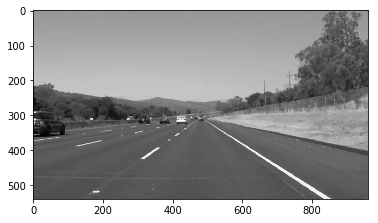

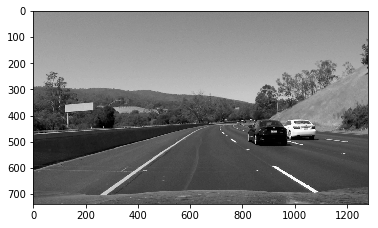

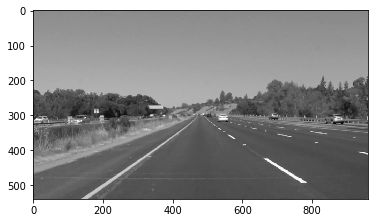

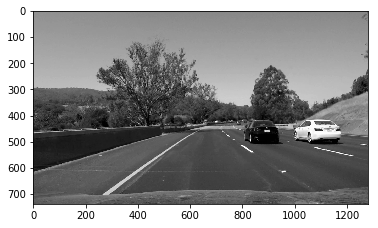

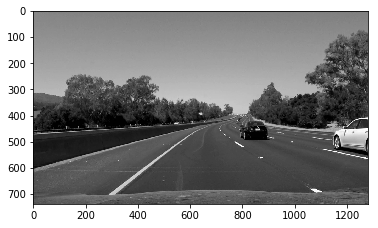

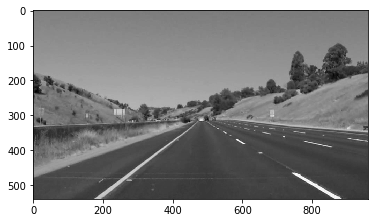

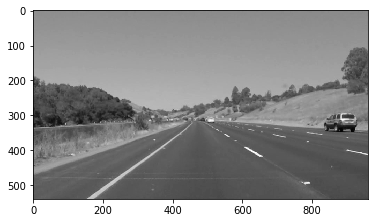

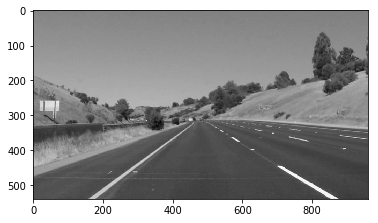

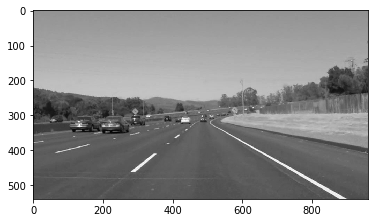

In [33]:
import os
files=os.listdir("test_images/")
gray_list=[]
image_list=[]
for v in files:
    image = mpimg.imread('test_images/'+v)
    image_list.append(image)
    gray = grayscale(image)
    plt.figure()
    plt.imshow(gray, cmap='gray')
    gray_list.append(gray)



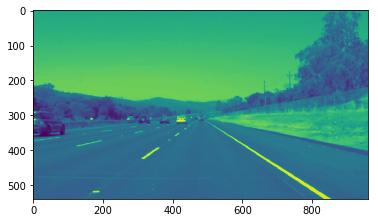

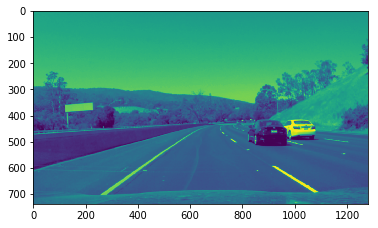

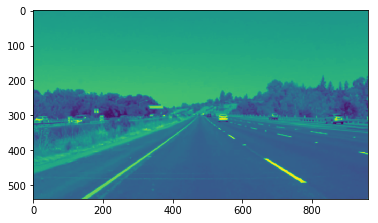

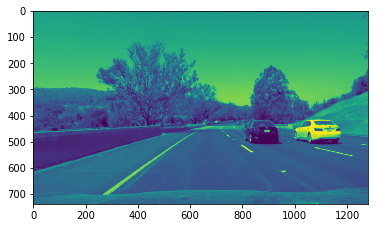

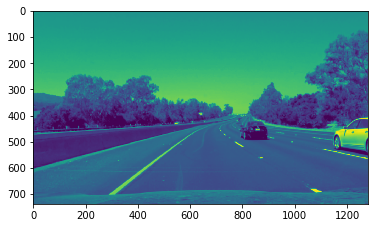

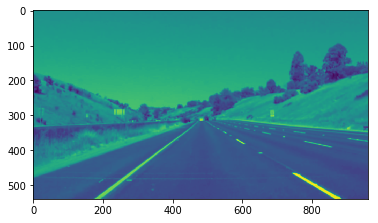

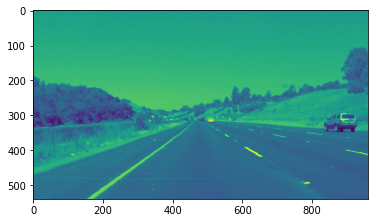

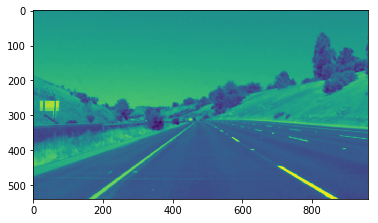

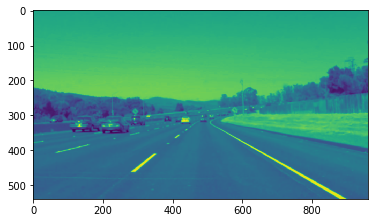

In [34]:
blur_gray_list=[]
for v in gray_list:
    blur_gray=gaussian_blur(v,5)
    plt.figure()
    plt.imshow(blur_gray)
    blur_gray_list.append(blur_gray)


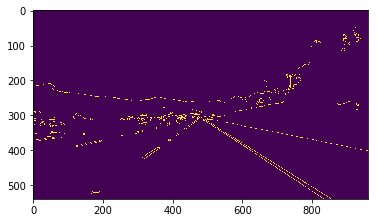

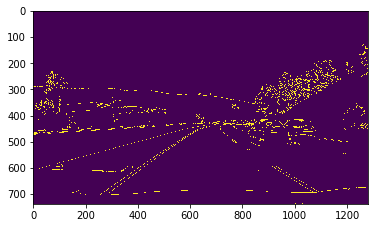

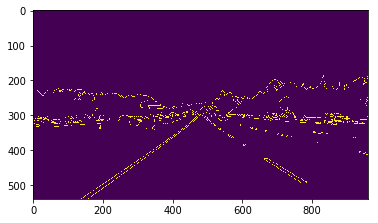

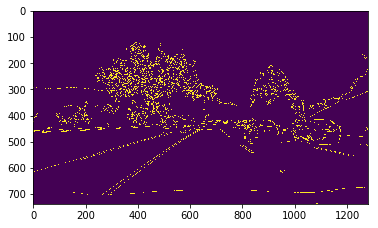

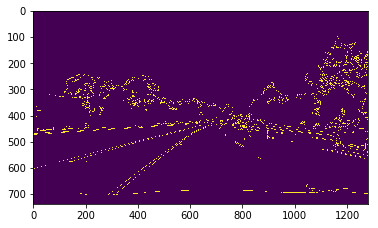

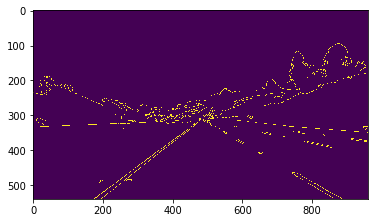

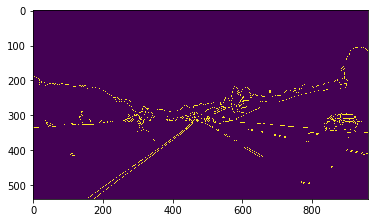

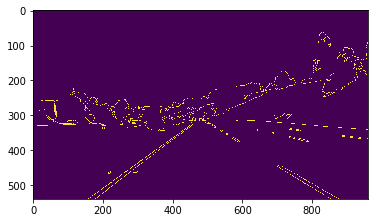

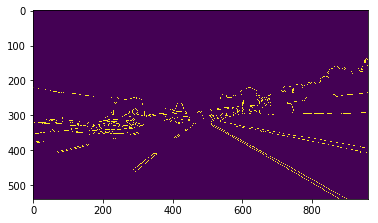

In [35]:
edges_list=[]
for v in blur_gray_list:
    edges = canny(v,10,180)
    plt.figure()
    plt.imshow(edges)
    edges_list.append(edges)



v.shape is  (540, 960, 3)
v.shape is  (738, 1280, 3)
v.shape is  (540, 960, 3)
v.shape is  (738, 1280, 3)
v.shape is  (738, 1280, 3)
v.shape is  (540, 960, 3)
v.shape is  (540, 960, 3)
v.shape is  (540, 960, 3)
v.shape is  (540, 960, 3)


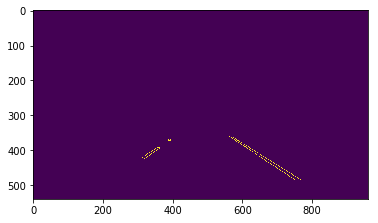

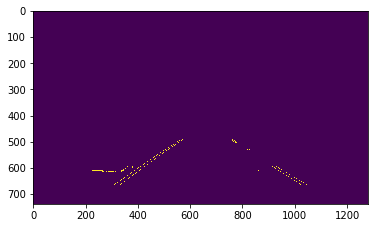

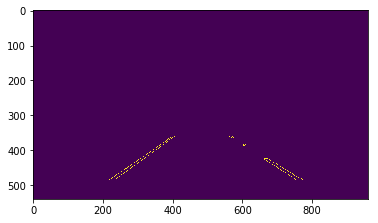

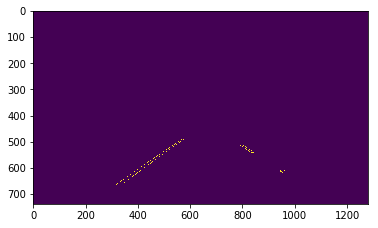

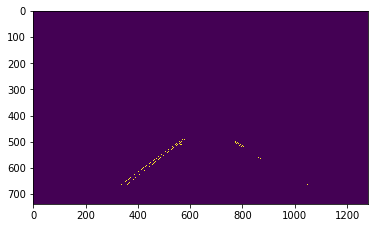

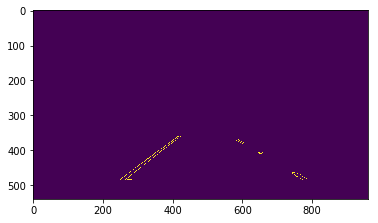

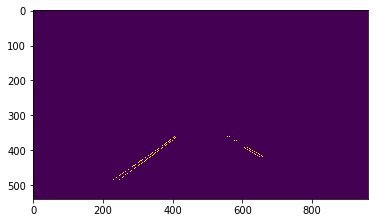

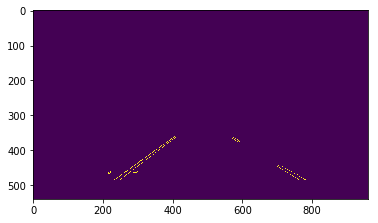

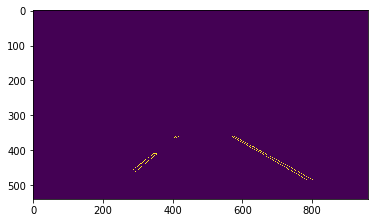

In [36]:
# This time we are defining a four sided polygon to mask
i=0
masked_edges_list=[]
for v in image_list:
    #print('i is ',i,'len of edges list is ', len(edges_list))
    imshape = v.shape
    print('v.shape is ',imshape)
    vertices = np.array([[(imshape[1]/16,imshape[0]*9/10),((imshape[1]/2)-(imshape[1]/10), imshape[0]*8/12), ((imshape[1]/2)+(imshape[1]/10), imshape[0]*8/12), (imshape[1]-(imshape[1]/16),imshape[0]*9/10)]], dtype=np.int32)
    masked_edges = region_of_interest(edges_list[i],vertices)
    plt.figure()
    plt.imshow(masked_edges)
    i=i+1
    masked_edges_list.append(masked_edges)



left slope is  -0.607142857143
slope= -0.607142857143
left slope is  -0.704545454545
slope= -0.704545454545
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.704545454545
slope= -0.704545454545
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
avg left position is x= 344.277777778  y=  401.5
avg right slope is x= 0.626541224518  avg left slope=  -0.64345226306
i is  0  left array x is  391 y is  369
i is  1  left array x is  387 y is  372
i is  2  left array x is  363 y is  394
i is  3  left array x is  362 y is  394
i is  4  left array x is  357 y is  392
i is  5  left array x is  355 y is  392
i is  6  left array x is  350 y is  395
i is  7  left array x is  348 y is  398
i is  8  left array x is  345 y is  400
i is  9  left array x is  340 y is  403
i is  10  left array x is  339 y is  404
i is  11  left arr

new left i is  31 i0=  432  i+1 0= 432  i+2 0= 430
new left i is  32 i0=  432  i+1 0= 430  i+2 0= 427
new left i is  33 i0=  430  i+1 0= 427  i+2 0= 422
new left i is  34 i0=  427  i+1 0= 422  i+2 0= 418
new left i is  35 i0=  422  i+1 0= 418  i+2 0= 418
new left i is  36 i0=  418  i+1 0= 418  i+2 0= 416
new left i is  37 i0=  418  i+1 0= 416  i+2 0= 414
new left i is  38 i0=  416  i+1 0= 414  i+2 0= 408
new left i is  39 i0=  414  i+1 0= 408  i+2 0= 407
new left i is  40 i0=  408  i+1 0= 407  i+2 0= 395
new left i is  41 i0=  407  i+1 0= 395  i+2 0= 391
new left i is  42 i0=  395  i+1 0= 391  i+2 0= 389
new left i is  43 i0=  391  i+1 0= 389  i+2 0= 381
new left i is  44 i0=  389  i+1 0= 381  i+2 0= 372
new left i is  45 i0=  381  i+1 0= 372  i+2 0= 372
new left i is  46 i0=  372  i+1 0= 372  i+2 0= 370
new left i is  47 i0=  372  i+1 0= 370  i+2 0= 348
new left i is  48 i0=  370  i+1 0= 348  i+2 0= 348
new left i is  49 i0=  348  i+1 0= 348  i+2 0= 345
new left i is  50 i0=  348  i+1

slope= -0.736842105263
left slope is  -0.809523809524
slope= -0.809523809524
left slope is  -0.735294117647
slope= -0.735294117647
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.754716981132
slope= -0.754716981132
left slope is  -0.793103448276
slope= -0.793103448276
left slope is  -0.875
slope= -0.875
left slope is  -0.76
slope= -0.76
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.875
slope= -0.875
left slope is  -0.8
slope= -0.8
left slope is  -0.772727272727
slope= -0.772727272727
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  353.0625
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 320.454545455  y=  425.772727273
avg right slope is x= 0.585308871023  avg left slope=  -0.777

after extrapolated
final_x1_left= 154 avg_slope_left= -0.691373660951 final_x2_left= 447
final_y1_left= 540 avg_slope_right= 0.618230441887 final_y2_left= 340
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.88
slope= -0.88
left slope is  -0.885714285714
slope= -0.885714285714
left slope is  -0.545454545455
slope= -0.545454545455
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8
slope= -0.8
left slope is  -0.5
slope= -0.5
left slope is  -0.785714285714
slope= -0.785714285714
previous avg_left xposition is  309.782608696
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 348.166666667  y=  412.722222222
avg right slope is x= 0.622273341376  avg left slope=  -0.714753394753
i is  0  left array x is  418 y is  360
i is  1  left array x is  414 y is  363
i is  2  left array x is  409 y is  366
i is  3  left array x is  407 y is  366
i is  4  left array x is  390 y is  381
i is  5  left array x is  386 y is 

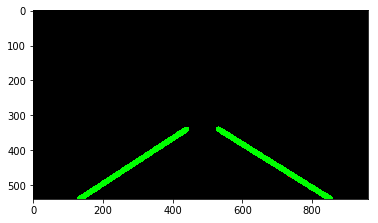

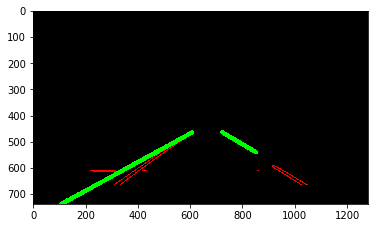

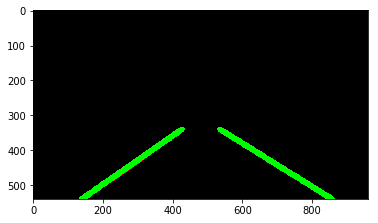

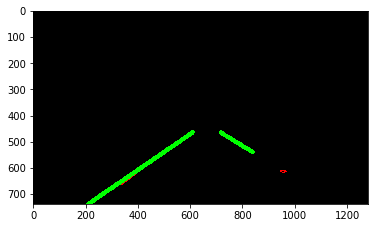

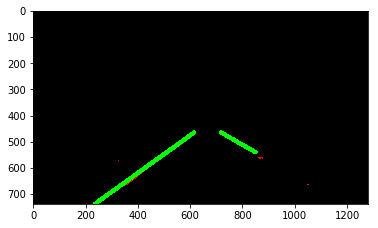

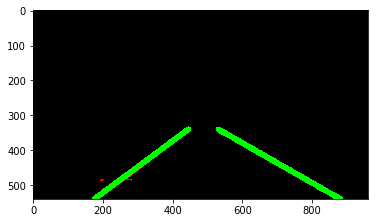

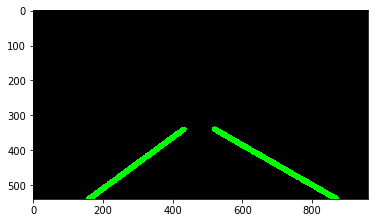

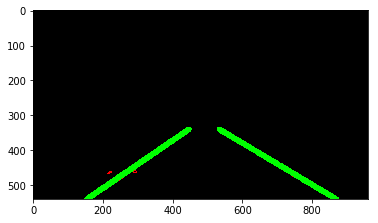

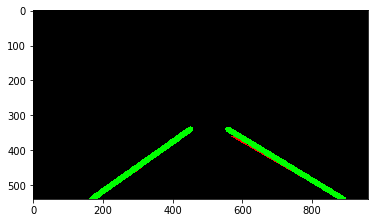

In [37]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 3
min_line_length = 3
max_line_gap = 7
lines_list=[]
for v in masked_edges_list:
    lines=hough_lines(v,rho,theta,threshold,min_line_length,max_line_gap)
    plt.figure()
    plt.imshow(lines)
    lines_list.append(lines)


"\ni=0\nfor v in mix_list:\n    mpimg.imsave('test_images/'+files[i]+'_after',v)\n    i = i+1\n"

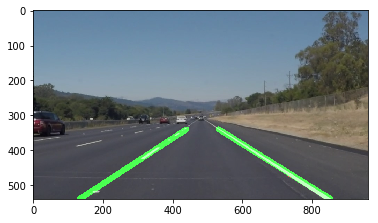

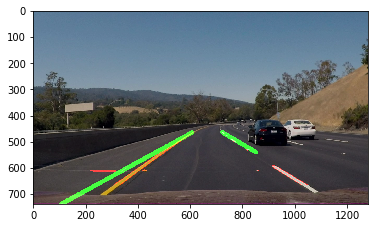

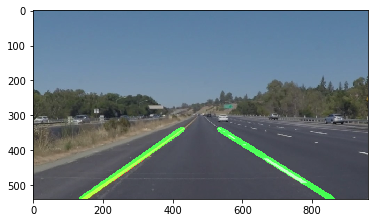

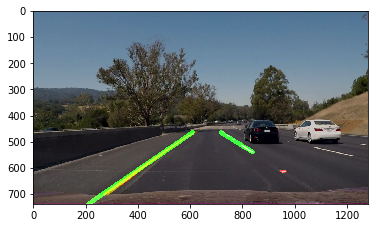

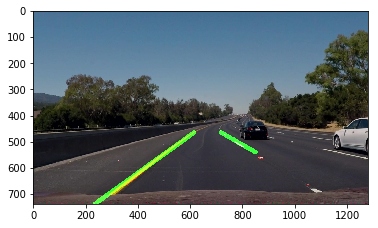

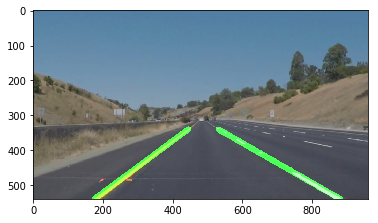

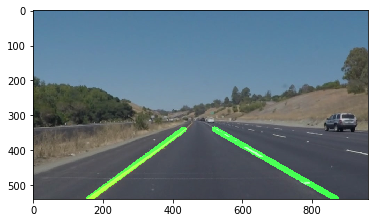

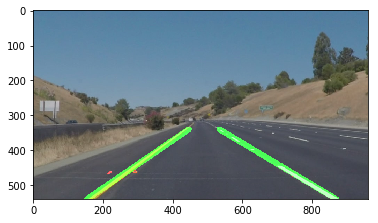

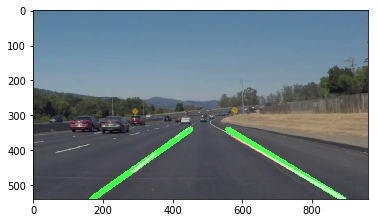

In [38]:
i=0
mix_list=[]
for v in lines_list:
    mix=weighted_img(v,image_list[i], α=0.8, β=1., λ=0.)
    plt.figure()
    plt.imshow(mix)
    i = i+1
    mix_list.append(mix)
"""
i=0
for v in mix_list:
    mpimg.imsave('test_images/'+files[i]+'_after',v)
    i = i+1
"""

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# Finished at previous cell

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 10, 180)
    imshape = image.shape
    #print('imshape',imshape)
    vertices = np.array([[(imshape[1]/16,imshape[0]*9/10),((imshape[1]/2)-(imshape[1]/10), imshape[0]*8/12), ((imshape[1]/2)+(imshape[1]/10), imshape[0]*8/12), (imshape[1]-(imshape[1]/16),imshape[0]*9/10)]], dtype=np.int32)
    #vertices = np.array([[(60,720),(620,450),(720,450),(1100,720)]], dtype=np.int32)
    #print('vertices',vertices)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi/180
    threshold = 2
    min_line_length = 2
    max_line_gap = 6
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'White.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [86]:
history_avg_left_xposition=[] 
history_avg_left_yposition=[]
history_avg_right_xposition=[]
history_avg_right_yposition=[]
history_slope_right=[]
history_slope_left=[]
counting =0

In [87]:
challenge_output = 'extra.mp4'
clip3 = VideoFileClip('challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.72131147541
slope= -0.72131147541
left slope is  -0.66
slope= -0.66
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.75
slope= -0.75
left slope is  -0.8
slope= -0.8
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8
slope= -0.8
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.75
slope= -0.75
left slope is  -


  0%|          | 0/251 [00:00<?, ?it/s]

left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.72131147541
slope= -0.72131147541
left slope is  -0.66
slope= -0.66
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.75
slope= -0.75
left slope is  -0.8
slope= -0.8
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8
slope= -0.8
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.75
slope= -0.75
left slope is  -

  left array x is  282 y is  630
new left i is  0 i0=  571  i+1 0= 570  i+2 0= 569
new left i is  1 i0=  570  i+1 0= 569  i+2 0= 566
new left i is  2 i0=  569  i+1 0= 566  i+2 0= 565
new left i is  3 i0=  566  i+1 0= 565  i+2 0= 562
new left i is  4 i0=  565  i+1 0= 562  i+2 0= 553
new left i is  5 i0=  562  i+1 0= 553  i+2 0= 549
new left i is  6 i0=  553  i+1 0= 549  i+2 0= 544
new left i is  7 i0=  549  i+1 0= 544  i+2 0= 543
new left i is  8 i0=  544  i+1 0= 543  i+2 0= 542
new left i is  9 i0=  543  i+1 0= 542  i+2 0= 541
new left i is  10 i0=  542  i+1 0= 541  i+2 0= 537
new left i is  11 i0=  541  i+1 0= 537  i+2 0= 524
new left i is  12 i0=  537  i+1 0= 524  i+2 0= 523
new left i is  13 i0=  524  i+1 0= 523  i+2 0= 520
new left i is  14 i0=  523  i+1 0= 520  i+2 0= 517
new left i is  15 i0=  520  i+1 0= 517  i+2 0= 508
new left i is  16 i0=  517  i+1 0= 508  i+2 0= 501
new left i is  17 i0=  508  i+1 0= 501  i+2 0= 500
new left i is  18 i0=  501  i+1 0= 500  i+2 0= 498
new left


  1%|          | 2/251 [00:00<00:22, 11.11it/s]

42 i0=  396  i+1 0= 394  i+2 0= 386
new left i is  43 i0=  394  i+1 0= 386  i+2 0= 385
new left i is  44 i0=  386  i+1 0= 385  i+2 0= 379
new left i is  45 i0=  385  i+1 0= 379  i+2 0= 374
new left i is  46 i0=  379  i+1 0= 374  i+2 0= 368
new left i is  47 i0=  374  i+1 0= 368  i+2 0= 368
new left i is  48 i0=  368  i+1 0= 368  i+2 0= 362
new left i is  49 i0=  368  i+1 0= 362  i+2 0= 360
new left i is  50 i0=  362  i+1 0= 360  i+2 0= 353
new left i is  51 i0=  360  i+1 0= 353  i+2 0= 350
new left i is  52 i0=  353  i+1 0= 350  i+2 0= 332
new left i is  53 i0=  350  i+1 0= 332  i+2 0= 329
new left i is  54 i0=  332  i+1 0= 329  i+2 0= 317
new left i is  55 i0=  329  i+1 0= 317  i+2 0= 315
new left i is  56 i0=  317  i+1 0= 315  i+2 0= 312
new left i is  57 i0=  315  i+1 0= 312  i+2 0= 310
new left i is  58 i0=  312  i+1 0= 310  i+2 0= 302
new left i is  59 i0=  310  i+1 0= 302  i+2 0= 300
new left i is  60 i0=  302  i+1 0= 300  i+2 0= 298
new left i is  61 i0=  300  i+1 0= 298  i+2 0=


  1%|          | 3/251 [00:00<00:25,  9.87it/s]


new left i is  30 i0=  445  i+1 0= 440  i+2 0= 438
new left i is  31 i0=  440  i+1 0= 438  i+2 0= 436
new left i is  32 i0=  438  i+1 0= 436  i+2 0= 434
new left i is  33 i0=  436  i+1 0= 434  i+2 0= 432
new left i is  34 i0=  434  i+1 0= 432  i+2 0= 430
new left i is  35 i0=  432  i+1 0= 430  i+2 0= 425
new left i is  36 i0=  430  i+1 0= 425  i+2 0= 423
new left i is  37 i0=  425  i+1 0= 423  i+2 0= 421
new left i is  38 i0=  423  i+1 0= 421  i+2 0= 419
new left i is  39 i0=  421  i+1 0= 419  i+2 0= 408
new left i is  40 i0=  419  i+1 0= 408  i+2 0= 405
new left i is  41 i0=  408  i+1 0= 405  i+2 0= 404
new left i is  42 i0=  405  i+1 0= 404  i+2 0= 403
new left i is  43 i0=  404  i+1 0= 403  i+2 0= 363
new left i is  44 i0=  403  i+1 0= 363  i+2 0= 360
new left i is  45 i0=  363  i+1 0= 360  i+2 0= 350
new left i is  46 i0=  360  i+1 0= 350  i+2 0= 348
new left i is  47 i0=  350  i+1 0= 348  i+2 0= 347
new left i is  48 i0=  348  i+1 0= 347  i+2 0= 346
new left i is  49 i0=  347  i+


  2%|▏         | 4/251 [00:00<00:26,  9.38it/s]

345
new left i is  41 i0=  352  i+1 0= 345  i+2 0= 340
new left i is  42 i0=  345  i+1 0= 340  i+2 0= 335
new left i is  43 i0=  340  i+1 0= 335  i+2 0= 325
new left i is  44 i0=  335  i+1 0= 325  i+2 0= 312
new left i is  45 i0=  325  i+1 0= 312  i+2 0= 311
del left array is  [22, 23, 28, 29, 31, 32, 34, 35]
new del left v is  35
new del left v is  34
new del left v is  32
new del left v is  31
new del left v is  29
new del left v is  28
new del left v is  23
new del left v is  22
last index left array is 39
min line is  640.0
avg left x position=  447.15
avg left y position=  561.95
length of history_avg_left_xposition 5
length of history_avg_left_yposition 5
avg leftx his all= 434.82338309
avg lefty his all= 565.244362853
leftx
final_x1_left= 312 avg_slope_left= -0.717379618069 final_x2_left= 435
final_y1_left= 648 avg_slope_right= 0.666666666667 final_y2_left= 562
final_y1_left= 648 avg_slope_left= -0.717379618069 final_x1_left= 312
final_y2_left= 562 avg_slope_left= -0.71737961806


  2%|▏         | 5/251 [00:00<00:27,  8.94it/s]

new left i is  26 i0=  475  i+1 0= 474  i+2 0= 473
new left i is  27 i0=  474  i+1 0= 473  i+2 0= 470
new left i is  28 i0=  473  i+1 0= 470  i+2 0= 467
new left i is  29 i0=  470  i+1 0= 467  i+2 0= 465
new left i is  30 i0=  467  i+1 0= 465  i+2 0= 458
new left i is  31 i0=  465  i+1 0= 458  i+2 0= 458
new left i is  32 i0=  458  i+1 0= 458  i+2 0= 456
new left i is  33 i0=  458  i+1 0= 456  i+2 0= 454
new left i is  34 i0=  456  i+1 0= 454  i+2 0= 449
new left i is  35 i0=  454  i+1 0= 449  i+2 0= 447
new left i is  36 i0=  449  i+1 0= 447  i+2 0= 441
new left i is  37 i0=  447  i+1 0= 441  i+2 0= 433
new left i is  38 i0=  441  i+1 0= 433  i+2 0= 429
new left i is  39 i0=  433  i+1 0= 429  i+2 0= 428
new left i is  40 i0=  429  i+1 0= 428  i+2 0= 427
new left i is  41 i0=  428  i+1 0= 427  i+2 0= 422
new left i is  42 i0=  427  i+1 0= 422  i+2 0= 420
new left i is  43 i0=  422  i+1 0= 420  i+2 0= 414
new left i is  44 i0=  420  i+1 0= 414  i+2 0= 414
new left i is  45 i0=  414  i+1


  2%|▏         | 6/251 [00:00<00:29,  8.41it/s]

 648
i is  41  left array x is  314 y is  648
new left i is  0 i0=  575  i+1 0= 574  i+2 0= 568
new left i is  1 i0=  574  i+1 0= 568  i+2 0= 567
new left i is  2 i0=  568  i+1 0= 567  i+2 0= 567
new left i is  3 i0=  567  i+1 0= 567  i+2 0= 549
new left i is  4 i0=  567  i+1 0= 549  i+2 0= 540
new left i is  5 i0=  549  i+1 0= 540  i+2 0= 537
new left i is  6 i0=  540  i+1 0= 537  i+2 0= 536
new left i is  7 i0=  537  i+1 0= 536  i+2 0= 534
new left i is  8 i0=  536  i+1 0= 534  i+2 0= 532
new left i is  9 i0=  534  i+1 0= 532  i+2 0= 522
new left i is  10 i0=  532  i+1 0= 522  i+2 0= 511
new left i is  11 i0=  522  i+1 0= 511  i+2 0= 507
new left i is  12 i0=  511  i+1 0= 507  i+2 0= 502
new left i is  13 i0=  507  i+1 0= 502  i+2 0= 498
new left i is  14 i0=  502  i+1 0= 498  i+2 0= 445
new left i is  15 i0=  498  i+1 0= 445  i+2 0= 431
new left i is  16 i0=  445  i+1 0= 431  i+2 0= 428
new left i is  17 i0=  431  i+1 0= 428  i+2 0= 427
new left i is  18 i0=  428  i+1 0= 427  i+2 0=


  3%|▎         | 7/251 [00:00<00:28,  8.53it/s]

 419  i+2 0= 417
new left i is  40 i0=  419  i+1 0= 417  i+2 0= 415
new left i is  41 i0=  417  i+1 0= 415  i+2 0= 411
new left i is  42 i0=  415  i+1 0= 411  i+2 0= 408
new left i is  43 i0=  411  i+1 0= 408  i+2 0= 406
new left i is  44 i0=  408  i+1 0= 406  i+2 0= 401
new left i is  45 i0=  406  i+1 0= 401  i+2 0= 399
new left i is  46 i0=  401  i+1 0= 399  i+2 0= 398
new left i is  47 i0=  399  i+1 0= 398  i+2 0= 393
new left i is  48 i0=  398  i+1 0= 393  i+2 0= 391
new left i is  49 i0=  393  i+1 0= 391  i+2 0= 391
new left i is  50 i0=  391  i+1 0= 391  i+2 0= 388
new left i is  51 i0=  391  i+1 0= 388  i+2 0= 387
new left i is  52 i0=  388  i+1 0= 387  i+2 0= 385
new left i is  53 i0=  387  i+1 0= 385  i+2 0= 382
new left i is  54 i0=  385  i+1 0= 382  i+2 0= 382
new left i is  55 i0=  382  i+1 0= 382  i+2 0= 381
new left i is  56 i0=  382  i+1 0= 381  i+2 0= 378
new left i is  57 i0=  381  i+1 0= 378  i+2 0= 375
new left i is  58 i0=  378  i+1 0= 375  i+2 0= 370
new left i is 


  4%|▎         | 9/251 [00:01<00:28,  8.48it/s]

  left array x is  349 y is  642
i is  48  left array x is  341 y is  648
i is  49  left array x is  339 y is  648
i is  50  left array x is  319 y is  647
i is  51  left array x is  318 y is  648
new left i is  0 i0=  575  i+1 0= 574  i+2 0= 568
new left i is  1 i0=  574  i+1 0= 568  i+2 0= 568
new left i is  2 i0=  568  i+1 0= 568  i+2 0= 567
new left i is  3 i0=  568  i+1 0= 567  i+2 0= 536
new left i is  4 i0=  567  i+1 0= 536  i+2 0= 533
new left i is  5 i0=  536  i+1 0= 533  i+2 0= 500
new left i is  6 i0=  533  i+1 0= 500  i+2 0= 498
new left i is  7 i0=  500  i+1 0= 498  i+2 0= 495
new left i is  8 i0=  498  i+1 0= 495  i+2 0= 492
new left i is  9 i0=  495  i+1 0= 492  i+2 0= 491
new left i is  10 i0=  492  i+1 0= 491  i+2 0= 490
new left i is  11 i0=  491  i+1 0= 490  i+2 0= 489
new left i is  12 i0=  490  i+1 0= 489  i+2 0= 488
new left i is  13 i0=  489  i+1 0= 488  i+2 0= 487
new left i is  14 i0=  488  i+1 0= 487  i+2 0= 478
new left i is  15 i0=  487  i+1 0= 478  i+2 0= 4

left slope is  -0.674418604651
slope= -0.674418604651
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.8
slope= -0.8
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.676470588235
slope= -0.676470588235
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is 


  4%|▍         | 10/251 [00:01<00:29,  8.24it/s]

i0=  378  i+1 0= 376  i+2 0= 375
new left i is  52 i0=  376  i+1 0= 375  i+2 0= 374
new left i is  53 i0=  375  i+1 0= 374  i+2 0= 369
new left i is  54 i0=  374  i+1 0= 369  i+2 0= 367
new left i is  55 i0=  369  i+1 0= 367  i+2 0= 366
new left i is  56 i0=  367  i+1 0= 366  i+2 0= 362
new left i is  57 i0=  366  i+1 0= 362  i+2 0= 359
new left i is  58 i0=  362  i+1 0= 359  i+2 0= 359
new left i is  59 i0=  359  i+1 0= 359  i+2 0= 352
new left i is  60 i0=  359  i+1 0= 352  i+2 0= 351
new left i is  61 i0=  352  i+1 0= 351  i+2 0= 345
new left i is  62 i0=  351  i+1 0= 345  i+2 0= 343
new left i is  63 i0=  345  i+1 0= 343  i+2 0= 339
new left i is  64 i0=  343  i+1 0= 339  i+2 0= 333
new left i is  65 i0=  339  i+1 0= 333  i+2 0= 332
new left i is  66 i0=  333  i+1 0= 332  i+2 0= 331
new left i is  67 i0=  332  i+1 0= 331  i+2 0= 329
new left i is  68 i0=  331  i+1 0= 329  i+2 0= 326
new left i is  69 i0=  329  i+1 0= 326  i+2 0= 323
del left array is  [52, 53, 55, 56, 60, 61, 64, 6


  4%|▍         | 11/251 [00:01<00:28,  8.39it/s]


new left i is  11 i0=  532  i+1 0= 531  i+2 0= 530
new left i is  12 i0=  531  i+1 0= 530  i+2 0= 528
new left i is  13 i0=  530  i+1 0= 528  i+2 0= 526
new left i is  14 i0=  528  i+1 0= 526  i+2 0= 523
new left i is  15 i0=  526  i+1 0= 523  i+2 0= 521
new left i is  16 i0=  523  i+1 0= 521  i+2 0= 521
new left i is  17 i0=  521  i+1 0= 521  i+2 0= 519
new left i is  18 i0=  521  i+1 0= 519  i+2 0= 517
new left i is  19 i0=  519  i+1 0= 517  i+2 0= 513
new left i is  20 i0=  517  i+1 0= 513  i+2 0= 511
new left i is  21 i0=  513  i+1 0= 511  i+2 0= 506
new left i is  22 i0=  511  i+1 0= 506  i+2 0= 504
new left i is  23 i0=  506  i+1 0= 504  i+2 0= 498
new left i is  24 i0=  504  i+1 0= 498  i+2 0= 498
new left i is  25 i0=  498  i+1 0= 498  i+2 0= 497
new left i is  26 i0=  498  i+1 0= 497  i+2 0= 483
new left i is  27 i0=  497  i+1 0= 483  i+2 0= 481
new left i is  28 i0=  483  i+1 0= 481  i+2 0= 470
new left i is  29 i0=  481  i+1 0= 470  i+2 0= 467
new left i is  30 i0=  470  i+


  5%|▌         | 13/251 [00:01<00:27,  8.62it/s]

-0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.625
slope= -0.625
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.6
slope= -0.6
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.7
slope= -0.7
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.6
slope= -0.6
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  451.272727273
avg left position is x= 440.539473684  y=  572.092105263
avg right slope is x= 0.60233103669  avg left slope=  -0.612292116903
i is  0  left array x is  575 y is  480
i is  1  left array x is  574 y is  480
i is  2  left array x is  572 y is  481
i is


  6%|▌         | 14/251 [00:01<00:27,  8.72it/s]

left slope is  -0.770491803279
slope= -0.770491803279
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.625
slope= -0.625
left slope is  -0.625
slope= -0.625
left slope is  -0.56
slope= -0.56
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.681818181818
slope= -0.681818181818
left slope is  -0.675
slope= -0.675
left slope is 

488
i is  6  left array x is  547 y is  492
i is  7  left array x is  536 y is  498
i is  8  left array x is  528 y is  505
i is  9  left array x is  523 y is  507
i is  10  left array x is  499 y is  525
i is  11  left array x is  498 y is  525
i is  12  left array x is  494 y is  529
i is  13  left array x is  492 y is  529
i is  14  left array x is  481 y is  538
i is  15  left array x is  479 y is  538
i is  16  left array x is  468 y is  546
i is  17  left array x is  459 y is  554
i is  18  left array x is  452 y is  559
i is  19  left array x is  447 y is  561
i is  20  left array x is  442 y is  565
i is  21  left array x is  435 y is  571
i is  22  left array x is  432 y is  573
i is  23  left array x is  429 y is  585
i is  24  left array x is  417 y is  582
i is  25  left array x is  413 y is  597
i is  26  left array x is  413 y is  585
i is  27  left array x is  409 y is  589
i is  28  left array x is  407 y is  603
i is  29  left array x is  406 y is  591
i is  30  left a


  7%|▋         | 17/251 [00:01<00:26,  8.95it/s]

17 i0=  459  i+1 0= 452  i+2 0= 447
new left i is  18 i0=  452  i+1 0= 447  i+2 0= 442
new left i is  19 i0=  447  i+1 0= 442  i+2 0= 435
new left i is  20 i0=  442  i+1 0= 435  i+2 0= 432
new left i is  21 i0=  435  i+1 0= 432  i+2 0= 429
new left i is  22 i0=  432  i+1 0= 429  i+2 0= 417
new left i is  23 i0=  429  i+1 0= 417  i+2 0= 413
new left i is  24 i0=  417  i+1 0= 413  i+2 0= 413
new left i is  25 i0=  413  i+1 0= 413  i+2 0= 409
new left i is  26 i0=  413  i+1 0= 409  i+2 0= 407
new left i is  27 i0=  409  i+1 0= 407  i+2 0= 406
new left i is  28 i0=  407  i+1 0= 406  i+2 0= 401
new left i is  29 i0=  406  i+1 0= 401  i+2 0= 395
new left i is  30 i0=  401  i+1 0= 395  i+2 0= 394
new left i is  31 i0=  395  i+1 0= 394  i+2 0= 388
new left i is  32 i0=  394  i+1 0= 388  i+2 0= 385
new left i is  33 i0=  388  i+1 0= 385  i+2 0= 383
new left i is  34 i0=  385  i+1 0= 383  i+2 0= 382
new left i is  35 i0=  383  i+1 0= 382  i+2 0= 372
new left i is  36 i0=  382  i+1 0= 372  i+2 0=

left slope is  -0.752873563218
slope= -0.752873563218
left slope is  -0.708333333333
slope= -0.708333333333
left slope is  -0.671052631579
slope= -0.671052631579
left slope is  -0.74358974359
slope= -0.74358974359
left slope is  -0.675675675676
slope= -0.675675675676
left slope is  -0.731707317073
slope= -0.731707317073
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.694444444444
slope= -0.694444444444
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.676470588235
slope= -0.676470588235
left slope is  -0.5
slope= -0.5
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.74358974359
slope= -0.74358974359
left slope is  -0.5
slope= -0.5
previous a


  8%|▊         | 19/251 [00:02<00:24,  9.52it/s]

 y is  480
i is  5  left array x is  560 y is  489
i is  6  left array x is  551 y is  494
i is  7  left array x is  547 y is  497
i is  8  left array x is  532 y is  509
i is  9  left array x is  527 y is  511
i is  10  left array x is  493 y is  529
i is  11  left array x is  488 y is  540
i is  12  left array x is  488 y is  531
i is  13  left array x is  474 y is  551
i is  14  left array x is  472 y is  552
i is  15  left array x is  466 y is  548
i is  16  left array x is  459 y is  552
i is  17  left array x is  454 y is  555
i is  18  left array x is  453 y is  557
i is  19  left array x is  421 y is  592
i is  20  left array x is  417 y is  595
i is  21  left array x is  417 y is  582
i is  22  left array x is  415 y is  597
i is  23  left array x is  413 y is  598
i is  24  left array x is  405 y is  605
i is  25  left array x is  398 y is  610
i is  26  left array x is  396 y is  612
i is  27  left array x is  392 y is  614
i is  28  left array x is  388 y is  618
i is  29  

i is  1  left array x is  571 y is  480
i is  2  left array x is  565 y is  480
i is  3  left array x is  564 y is  480
i is  4  left array x is  559 y is  483
i is  5  left array x is  549 y is  491
i is  6  left array x is  540 y is  496
i is  7  left array x is  531 y is  518
i is  8  left array x is  527 y is  521
i is  9  left array x is  526 y is  507
i is  10  left array x is  524 y is  507
i is  11  left array x is  504 y is  522
i is  12  left array x is  497 y is  534
i is  13  left array x is  496 y is  526
i is  14  left array x is  489 y is  532
i is  15  left array x is  487 y is  532
i is  16  left array x is  473 y is  542
i is  17  left array x is  465 y is  549
i is  18  left array x is  463 y is  549
i is  19  left array x is  455 y is  556
i is  20  left array x is  450 y is  570
i is  21  left array x is  445 y is  574
i is  22  left array x is  442 y is  576
i is  23  left array x is  430 y is  572
i is  24  left array x is  426 y is  587
i is  25  left array x is


  8%|▊         | 21/251 [00:02<00:22, 10.41it/s]

y is  614
i is  21  left array x is  383 y is  606
i is  22  left array x is  371 y is  616
i is  23  left array x is  369 y is  632
i is  24  left array x is  354 y is  627
i is  25  left array x is  352 y is  645
i is  26  left array x is  349 y is  646
i is  27  left array x is  348 y is  648
i is  28  left array x is  347 y is  648
i is  29  left array x is  345 y is  635
new left i is  0 i0=  572  i+1 0= 568  i+2 0= 562
new left i is  1 i0=  568  i+1 0= 562  i+2 0= 561
new left i is  2 i0=  562  i+1 0= 561  i+2 0= 557
new left i is  3 i0=  561  i+1 0= 557  i+2 0= 556
new left i is  4 i0=  557  i+1 0= 556  i+2 0= 552
new left i is  5 i0=  556  i+1 0= 552  i+2 0= 541
new left i is  6 i0=  552  i+1 0= 541  i+2 0= 506
new left i is  7 i0=  541  i+1 0= 506  i+2 0= 500
new left i is  8 i0=  506  i+1 0= 500  i+2 0= 498
new left i is  9 i0=  500  i+1 0= 498  i+2 0= 491
new left i is  10 i0=  498  i+1 0= 491  i+2 0= 484
new left i is  11 i0=  491  i+1 0= 484  i+2 0= 472
new left i is  12 i

final_y1_left= 720 avg_slope_right= 0.670717036682 final_y2_left= 453
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.703703703704
slope= -0.703703703704
left slope is  -0.5
slope= -0.5
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.6
slope= -0.6
left slope is  -0.744680851064
slope= -0.744680851064
left slope is  -0.809523809524
slope= -0.809523809524
left slope is  -0.866666666667
slope= -0.866666666667
left slope is  -0.717391304348
slope= -0.717391304348
left slope is  -0.8
slope= -0.8
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.68
slope= -0.68
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.690476190476
slope= -0.690476190476
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.692307692308
slope= -0.692307692308
le


  9%|▉         | 23/251 [00:02<00:24,  9.30it/s]

468  i+1 0= 464  i+2 0= 463
new left i is  26 i0=  464  i+1 0= 463  i+2 0= 461
new left i is  27 i0=  463  i+1 0= 461  i+2 0= 459
new left i is  28 i0=  461  i+1 0= 459  i+2 0= 457
new left i is  29 i0=  459  i+1 0= 457  i+2 0= 451
new left i is  30 i0=  457  i+1 0= 451  i+2 0= 446
new left i is  31 i0=  451  i+1 0= 446  i+2 0= 443
new left i is  32 i0=  446  i+1 0= 443  i+2 0= 430
new left i is  33 i0=  443  i+1 0= 430  i+2 0= 429
new left i is  34 i0=  430  i+1 0= 429  i+2 0= 428
new left i is  35 i0=  429  i+1 0= 428  i+2 0= 427
new left i is  36 i0=  428  i+1 0= 427  i+2 0= 427
new left i is  37 i0=  427  i+1 0= 427  i+2 0= 426
new left i is  38 i0=  427  i+1 0= 426  i+2 0= 426
new left i is  39 i0=  426  i+1 0= 426  i+2 0= 424
new left i is  40 i0=  426  i+1 0= 424  i+2 0= 422
new left i is  41 i0=  424  i+1 0= 422  i+2 0= 420
new left i is  42 i0=  422  i+1 0= 420  i+2 0= 420
new left i is  43 i0=  420  i+1 0= 420  i+2 0= 418
new left i is  44 i0=  420  i+1 0= 418  i+2 0= 416
new


 10%|▉         | 25/251 [00:02<00:22,  9.98it/s]

 443  i+1 0= 443  i+2 0= 433
new left i is  20 i0=  443  i+1 0= 433  i+2 0= 430
new left i is  21 i0=  433  i+1 0= 430  i+2 0= 427
new left i is  22 i0=  430  i+1 0= 427  i+2 0= 424
new left i is  23 i0=  427  i+1 0= 424  i+2 0= 415
new left i is  24 i0=  424  i+1 0= 415  i+2 0= 411
new left i is  25 i0=  415  i+1 0= 411  i+2 0= 399
new left i is  26 i0=  411  i+1 0= 399  i+2 0= 391
new left i is  27 i0=  399  i+1 0= 391  i+2 0= 388
new left i is  28 i0=  391  i+1 0= 388  i+2 0= 382
new left i is  29 i0=  388  i+1 0= 382  i+2 0= 380
new left i is  30 i0=  382  i+1 0= 380  i+2 0= 378
new left i is  31 i0=  380  i+1 0= 378  i+2 0= 378
new left i is  32 i0=  378  i+1 0= 378  i+2 0= 377
new left i is  33 i0=  378  i+1 0= 377  i+2 0= 376
new left i is  34 i0=  377  i+1 0= 376  i+2 0= 374
new left i is  35 i0=  376  i+1 0= 374  i+2 0= 373
new left i is  36 i0=  374  i+1 0= 373  i+2 0= 373
new left i is  37 i0=  373  i+1 0= 373  i+2 0= 372
new left i is  38 i0=  373  i+1 0= 372  i+2 0= 371
ne


 11%|█         | 27/251 [00:02<00:23,  9.35it/s]

 468
new left i is  18 i0=  470  i+1 0= 468  i+2 0= 468
new left i is  19 i0=  468  i+1 0= 468  i+2 0= 464
new left i is  20 i0=  468  i+1 0= 464  i+2 0= 462
new left i is  21 i0=  464  i+1 0= 462  i+2 0= 457
new left i is  22 i0=  462  i+1 0= 457  i+2 0= 456
new left i is  23 i0=  457  i+1 0= 456  i+2 0= 451
new left i is  24 i0=  456  i+1 0= 451  i+2 0= 450
new left i is  25 i0=  451  i+1 0= 450  i+2 0= 450
new left i is  26 i0=  450  i+1 0= 450  i+2 0= 450
new left i is  27 i0=  450  i+1 0= 450  i+2 0= 439
new left i is  28 i0=  450  i+1 0= 439  i+2 0= 432
new left i is  29 i0=  439  i+1 0= 432  i+2 0= 432
new left i is  30 i0=  432  i+1 0= 432  i+2 0= 431
new left i is  31 i0=  432  i+1 0= 431  i+2 0= 430
new left i is  32 i0=  431  i+1 0= 430  i+2 0= 428
new left i is  33 i0=  430  i+1 0= 428  i+2 0= 428
new left i is  34 i0=  428  i+1 0= 428  i+2 0= 423
new left i is  35 i0=  428  i+1 0= 423  i+2 0= 418
new left i is  36 i0=  423  i+1 0= 418  i+2 0= 416
new left i is  37 i0=  418


 12%|█▏        | 29/251 [00:03<00:22,  9.66it/s]

302
del left array is  [7, 8, 25, 26, 31, 32, 36, 37]
new del left v is  37
new del left v is  36
new del left v is  32
new del left v is  31
new del left v is  26
new del left v is  25
new del left v is  8
new del left v is  7
last index left array is 31
min line is  640.0
avg left x position=  436.0625
avg left y position=  567.96875
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 436.0625
avg lefty his all= 567.96875
final_x1_left= 304 avg_slope_left= -0.666832674081 final_x2_left= 436
final_y1_left= 578 avg_slope_right= 0.653605015674 final_y2_left= 568
final_y1_left= 578 avg_slope_left= -0.666832674081 final_x1_left= 304
final_y2_left= 568 avg_slope_left= -0.666832674081 final_x2_left= 436
after extrapolated
final_x1_left= 91 avg_slope_left= -0.666832674081 final_x2_left= 608
final_y1_left= 720 avg_slope_right= 0.653605015674 final_y2_left= 453
left slope is  -0.753926701571
slope= -0.753926701571
left slope is  -0.758620689655
slop


 12%|█▏        | 30/251 [00:03<00:26,  8.35it/s]

left slope is  -0.875
slope= -0.875
left slope is  -0.635135135135
slope= -0.635135135135
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.65
slope= -0.65
left slope is  -0.7
slope= -0.7
left slope is  -0.5
slope= -0.5
left slope is  -0.7
slope= -0.7
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.5
slope= -0.5
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.6
slope= -0.6
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.8
slope= -0.8
left slope is  -0.8
slope= -0.8
left slope is  -0.5
slope= -0.5
left slope is  -0.

left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.5
slope= -0.5
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  424.357142857
avg left position is x= 421.413793103  y=  581.913793103
avg right slope is x= 0.627680518715  a


 12%|█▏        | 31/251 [00:03<00:27,  7.88it/s]

34  left array x is  410 y is  595
i is  35  left array x is  406 y is  587
i is  36  left array x is  378 y is  607
i is  37  left array x is  377 y is  607
i is  38  left array x is  373 y is  609
i is  39  left array x is  371 y is  611
i is  40  left array x is  369 y is  612
i is  41  left array x is  367 y is  629
i is  42  left array x is  356 y is  637
i is  43  left array x is  353 y is  638
i is  44  left array x is  352 y is  640
i is  45  left array x is  348 y is  627
i is  46  left array x is  347 y is  629
i is  47  left array x is  345 y is  644
i is  48  left array x is  345 y is  629
i is  49  left array x is  341 y is  648
i is  50  left array x is  341 y is  633
i is  51  left array x is  334 y is  638
i is  52  left array x is  332 y is  639
i is  53  left array x is  323 y is  646
i is  54  left array x is  322 y is  646
i is  55  left array x is  320 y is  647
i is  56  left array x is  319 y is  648
i is  57  left array x is  318 y is  648
new left i is  0 i0=  


 13%|█▎        | 33/251 [00:03<00:24,  8.88it/s]

4 i0=  552  i+1 0= 551  i+2 0= 549
new left i is  5 i0=  551  i+1 0= 549  i+2 0= 541
new left i is  6 i0=  549  i+1 0= 541  i+2 0= 536
new left i is  7 i0=  541  i+1 0= 536  i+2 0= 533
new left i is  8 i0=  536  i+1 0= 533  i+2 0= 526
new left i is  9 i0=  533  i+1 0= 526  i+2 0= 519
new left i is  10 i0=  526  i+1 0= 519  i+2 0= 513
new left i is  11 i0=  519  i+1 0= 513  i+2 0= 507
new left i is  12 i0=  513  i+1 0= 507  i+2 0= 504
new left i is  13 i0=  507  i+1 0= 504  i+2 0= 489
new left i is  14 i0=  504  i+1 0= 489  i+2 0= 484
new left i is  15 i0=  489  i+1 0= 484  i+2 0= 479
new left i is  16 i0=  484  i+1 0= 479  i+2 0= 471
new left i is  17 i0=  479  i+1 0= 471  i+2 0= 468
new left i is  18 i0=  471  i+1 0= 468  i+2 0= 468
new left i is  19 i0=  468  i+1 0= 468  i+2 0= 461
new left i is  20 i0=  468  i+1 0= 461  i+2 0= 460
new left i is  21 i0=  461  i+1 0= 460  i+2 0= 446
new left i is  22 i0=  460  i+1 0= 446  i+2 0= 443
new left i is  23 i0=  446  i+1 0= 443  i+2 0= 441
n


 14%|█▎        | 34/251 [00:03<00:26,  8.32it/s]

left slope is  -0.702702702703
slope= -0.702702702703
left slope is  -0.5
slope= -0.5
left slope is  -0.607142857143
slope= -0.607142857143
left slope is  -0.703703703704
slope= -0.703703703704
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.690476190476
slope= -0.690476190476
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.5
slope= -0.5
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.5625
slope= -0.5625
left slope is  -0.5
slope= -0.5
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.875
slope= -0.875
left slope is  -0.75
slope= -0.75
left slope is  -0.6875
slope= -0.6875
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.875
slope= -0.875
left slope is  -0.875
slope= -0.875
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.8
slope= -0.8
left slope is  -0.875
slope= -0.875
left slope is 

 -0.5
slope= -0.5
left slope is  -0.648148148148
slope= -0.648148148148
left slope is  -0.5
slope= -0.5
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.6
slope= -0.6
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.65625
slope= -0.65625
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.6
slope= -0.6
left slope is  -0.8
slope= -0.8
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.


 14%|█▍        | 35/251 [00:03<00:27,  7.94it/s]

 411 y is  593
i is  36  left array x is  409 y is  594
i is  37  left array x is  407 y is  583
i is  38  left array x is  406 y is  595
i is  39  left array x is  405 y is  596
i is  40  left array x is  405 y is  585
i is  41  left array x is  400 y is  601
i is  42  left array x is  398 y is  602
i is  43  left array x is  398 y is  590
i is  44  left array x is  394 y is  605
i is  45  left array x is  394 y is  604
i is  46  left array x is  393 y is  606
i is  47  left array x is  392 y is  606
i is  48  left array x is  391 y is  607
i is  49  left array x is  388 y is  597
i is  50  left array x is  387 y is  610
i is  51  left array x is  385 y is  611
i is  52  left array x is  384 y is  599
i is  53  left array x is  383 y is  599
i is  54  left array x is  382 y is  600
i is  55  left array x is  372 y is  621
i is  56  left array x is  371 y is  609
i is  57  left array x is  370 y is  622
i is  58  left array x is  367 y is  625
i is  59  left array x is  363 y is  627
i


 14%|█▍        | 36/251 [00:04<00:28,  7.45it/s]

 i0=  476  i+1 0= 466  i+2 0= 461
new left i is  21 i0=  466  i+1 0= 461  i+2 0= 458
new left i is  22 i0=  461  i+1 0= 458  i+2 0= 454
new left i is  23 i0=  458  i+1 0= 454  i+2 0= 453
new left i is  24 i0=  454  i+1 0= 453  i+2 0= 451
new left i is  25 i0=  453  i+1 0= 451  i+2 0= 447
new left i is  26 i0=  451  i+1 0= 447  i+2 0= 445
new left i is  27 i0=  447  i+1 0= 445  i+2 0= 445
new left i is  28 i0=  445  i+1 0= 445  i+2 0= 444
new left i is  29 i0=  445  i+1 0= 444  i+2 0= 441
new left i is  30 i0=  444  i+1 0= 441  i+2 0= 441
new left i is  31 i0=  441  i+1 0= 441  i+2 0= 440
new left i is  32 i0=  441  i+1 0= 440  i+2 0= 437
new left i is  33 i0=  440  i+1 0= 437  i+2 0= 430
new left i is  34 i0=  437  i+1 0= 430  i+2 0= 429
new left i is  35 i0=  430  i+1 0= 429  i+2 0= 421
new left i is  36 i0=  429  i+1 0= 421  i+2 0= 416
new left i is  37 i0=  421  i+1 0= 416  i+2 0= 412
new left i is  38 i0=  416  i+1 0= 412  i+2 0= 410
new left i is  39 i0=  412  i+1 0= 410  i+2 0= 4


 15%|█▍        | 37/251 [00:04<00:30,  6.98it/s]

-0.555555555556
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.545454545455
slope= -0.545454545455
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.75
slope= -0.75
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  442.357142857
avg left position is x= 433.188888889  y=  569.011111111
avg right slope is x= 0.609921577951  avg left slope=  -0.607969173165
i is  0  left array x is  573 y is  480
i is  1  left array x is  569 y is  483
i is  2  left array x is  567 y is  480
i is  3  left array x is  566 y is  480
i is  4  left array x is  565 y is  486
i is  5  left array x is

i is  11  left array x is  533 y is  500
i is  12  left array x is  527 y is  504
i is  13  left array x is  525 y is  504
i is  14  left array x is  522 y is  512
i is  15  left array x is  519 y is  514
i is  16  left array x is  511 y is  521
i is  17  left array x is  506 y is  524
i is  18  left array x is  505 y is  525
i is  19  left array x is  499 y is  528
i is  20  left array x is  493 y is  532
i is  21  left array x is  492 y is  534
i is  22  left array x is  491 y is  535
i is  23  left array x is  486 y is  537
i is  24  left array x is  472 y is  547
i is  25  left array x is  467 y is  552
i is  26  left array x is  464 y is  555
i is  27  left array x is  462 y is  555
i is  28  left array x is  461 y is  556
i is  29  left array x is  460 y is  558
i is  30  left array x is  459 y is  558
i is  31  left array x is  455 y is  562
i is  32  left array x is  450 y is  564
i is  33  left array x is  448 y is  566
i is  34  left array x is  448 y is  554
i is  35  left a


 15%|█▌        | 38/251 [00:04<00:29,  7.20it/s]

  i+1 0= 533  i+2 0= 527
new left i is  11 i0=  533  i+1 0= 527  i+2 0= 525
new left i is  12 i0=  527  i+1 0= 525  i+2 0= 522
new left i is  13 i0=  525  i+1 0= 522  i+2 0= 519
new left i is  14 i0=  522  i+1 0= 519  i+2 0= 511
new left i is  15 i0=  519  i+1 0= 511  i+2 0= 506
new left i is  16 i0=  511  i+1 0= 506  i+2 0= 505
new left i is  17 i0=  506  i+1 0= 505  i+2 0= 499
new left i is  18 i0=  505  i+1 0= 499  i+2 0= 493
new left i is  19 i0=  499  i+1 0= 493  i+2 0= 492
new left i is  20 i0=  493  i+1 0= 492  i+2 0= 491
new left i is  21 i0=  492  i+1 0= 491  i+2 0= 486
new left i is  22 i0=  491  i+1 0= 486  i+2 0= 472
new left i is  23 i0=  486  i+1 0= 472  i+2 0= 467
new left i is  24 i0=  472  i+1 0= 467  i+2 0= 464
new left i is  25 i0=  467  i+1 0= 464  i+2 0= 462
new left i is  26 i0=  464  i+1 0= 462  i+2 0= 461
new left i is  27 i0=  462  i+1 0= 461  i+2 0= 460
new left i is  28 i0=  461  i+1 0= 460  i+2 0= 459
new left i is  29 i0=  460  i+1 0= 459  i+2 0= 455
new le


 16%|█▌        | 40/251 [00:04<00:26,  8.10it/s]

 7 i0=  518  i+1 0= 518  i+2 0= 507
new left i is  8 i0=  518  i+1 0= 507  i+2 0= 502
new left i is  9 i0=  507  i+1 0= 502  i+2 0= 496
new left i is  10 i0=  502  i+1 0= 496  i+2 0= 491
new left i is  11 i0=  496  i+1 0= 491  i+2 0= 489
new left i is  12 i0=  491  i+1 0= 489  i+2 0= 481
new left i is  13 i0=  489  i+1 0= 481  i+2 0= 478
new left i is  14 i0=  481  i+1 0= 478  i+2 0= 467
new left i is  15 i0=  478  i+1 0= 467  i+2 0= 467
new left i is  16 i0=  467  i+1 0= 467  i+2 0= 467
new left i is  17 i0=  467  i+1 0= 467  i+2 0= 463
new left i is  18 i0=  467  i+1 0= 463  i+2 0= 460
new left i is  19 i0=  463  i+1 0= 460  i+2 0= 455
new left i is  20 i0=  460  i+1 0= 455  i+2 0= 454
new left i is  21 i0=  455  i+1 0= 454  i+2 0= 451
new left i is  22 i0=  454  i+1 0= 451  i+2 0= 442
new left i is  23 i0=  451  i+1 0= 442  i+2 0= 435
new left i is  24 i0=  442  i+1 0= 435  i+2 0= 427
new left i is  25 i0=  435  i+1 0= 427  i+2 0= 427
new left i is  26 i0=  427  i+1 0= 427  i+2 0= 4


 16%|█▋        | 41/251 [00:04<00:29,  7.14it/s]


left slope is  -0.652173913043
slope= -0.652173913043
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.5
slope= -0.5
left slope is  -0.7
slope= -0.7
left slope is  -0.7
slope= -0.7
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  446.590909091
avg left position is x= 434.202380952  y=  569.988095238
avg right slope is x= 0.571428571429  avg left slope=  -0.632701856375
i is  0  left array x is  575 y is  480
i is  1  left array x is  561 y is  484
i is  2  left array x is  554 y is  501
i is  3  left array x is  553 y is  488
i is  4  left array x is  552 y is  502
i is  5  left array x is  551 y is  489
i is  6  left array x is  550 y is  491
i is  7  left array x is  545 y is  494
i is  8  left array x is  537 y is  499
i is  9  left array x is  529 y

i is  19  left array x is  479 y is  536
i is  20  left array x is  466 y is  552
i is  21  left array x is  465 y is  554
i is  22  left array x is  460 y is  556
i is  23  left array x is  459 y is  558
i is  24  left array x is  426 y is  580
i is  25  left array x is  423 y is  572
i is  26  left array x is  422 y is  583
i is  27  left array x is  419 y is  586
i is  28  left array x is  415 y is  588
i is  29  left array x is  414 y is  590
i is  30  left array x is  411 y is  592
i is  31  left array x is  407 y is  594
i is  32  left array x is  404 y is  597
i is  33  left array x is  400 y is  599
i is  34  left array x is  398 y is  588
i is  35  left array x is  397 y is  589
i is  36  left array x is  393 y is  605
i is  37  left array x is  391 y is  606
i is  38  left array x is  389 y is  608
i is  39  left array x is  389 y is  607
i is  40  left array x is  386 y is  610
i is  41  left array x is  372 y is  620
i is  42  left array x is  363 y is  626
i is  43  left a


 17%|█▋        | 43/251 [00:04<00:26,  7.97it/s]

349  i+2 0= 347
new left i is  43 i0=  349  i+1 0= 347  i+2 0= 342
new left i is  44 i0=  347  i+1 0= 342  i+2 0= 339
new left i is  45 i0=  342  i+1 0= 339  i+2 0= 334
new left i is  46 i0=  339  i+1 0= 334  i+2 0= 332
new left i is  47 i0=  334  i+1 0= 332  i+2 0= 325
new left i is  48 i0=  332  i+1 0= 325  i+2 0= 323
new left i is  49 i0=  325  i+1 0= 323  i+2 0= 313
del left array is  [34, 35, 49, 50]
new del left v is  50
new del left v is  49
new del left v is  35
new del left v is  34
last index left array is 47
min line is  640.0
avg left x position=  453.145833333
avg left y position=  559.354166667
length of history_avg_left_xposition 8
length of history_avg_left_yposition 8
avg leftx his all= 444.004667592
avg lefty his all= 565.053057021
leftx
lefty
final_x1_left= 322 avg_slope_left= -0.682461646565 final_x2_left= 444
final_y1_left= 647 avg_slope_right= 0.5125 final_y2_left= 565
final_y1_left= 647 avg_slope_left= -0.682461646565 final_x1_left= 322
final_y2_left= 565 avg_slo

 21  left array x is  457 y is  552
i is  22  left array x is  456 y is  562
i is  23  left array x is  453 y is  563
i is  24  left array x is  452 y is  564
i is  25  left array x is  452 y is  554
i is  26  left array x is  451 y is  556
i is  27  left array x is  446 y is  569
i is  28  left array x is  446 y is  568
i is  29  left array x is  445 y is  560
i is  30  left array x is  443 y is  571
i is  31  left array x is  439 y is  564
i is  32  left array x is  435 y is  577
i is  33  left array x is  429 y is  581
i is  34  left array x is  423 y is  573
i is  35  left array x is  417 y is  588
i is  36  left array x is  416 y is  590
i is  37  left array x is  413 y is  592
i is  38  left array x is  412 y is  592
i is  39  left array x is  410 y is  594
i is  40  left array x is  409 y is  594
i is  41  left array x is  408 y is  595
i is  42  left array x is  408 y is  584
i is  43  left array x is  404 y is  597
i is  44  left array x is  403 y is  599
i is  45  left array 


 18%|█▊        | 46/251 [00:05<00:23,  8.74it/s]

 i+1 0= 435  i+2 0= 429
new left i is  32 i0=  435  i+1 0= 429  i+2 0= 423
new left i is  33 i0=  429  i+1 0= 423  i+2 0= 417
new left i is  34 i0=  423  i+1 0= 417  i+2 0= 416
new left i is  35 i0=  417  i+1 0= 416  i+2 0= 413
new left i is  36 i0=  416  i+1 0= 413  i+2 0= 412
new left i is  37 i0=  413  i+1 0= 412  i+2 0= 410
new left i is  38 i0=  412  i+1 0= 410  i+2 0= 409
new left i is  39 i0=  410  i+1 0= 409  i+2 0= 408
new left i is  40 i0=  409  i+1 0= 408  i+2 0= 408
new left i is  41 i0=  408  i+1 0= 408  i+2 0= 404
new left i is  42 i0=  408  i+1 0= 404  i+2 0= 403
new left i is  43 i0=  404  i+1 0= 403  i+2 0= 398
new left i is  44 i0=  403  i+1 0= 398  i+2 0= 391
new left i is  45 i0=  398  i+1 0= 391  i+2 0= 387
new left i is  46 i0=  391  i+1 0= 387  i+2 0= 381
new left i is  47 i0=  387  i+1 0= 381  i+2 0= 363
new left i is  48 i0=  381  i+1 0= 363  i+2 0= 359
new left i is  49 i0=  363  i+1 0= 359  i+2 0= 357
new left i is  50 i0=  359  i+1 0= 357  i+2 0= 355
new lef

 -0.642857142857
slope= -0.642857142857
left slope is  -0.75
slope= -0.75
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
left slope is  -0.653846153846
slope= -0.653846153846
left slope is  -0.809523809524
slope= -0.809523809524
left slope is  -0.625
slope= -0.625
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.766666666667
slope= -0.766666666667
left slope is  -0.766666666667
slope= -0.766666666667
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.578947368421
slope= -0.578947368421
left slope is  -0.625
slope= -0.625
left slope


 19%|█▊        | 47/251 [00:05<00:26,  7.63it/s]

 1  left array x is  576 y is  480
i is  2  left array x is  575 y is  480
i is  3  left array x is  572 y is  482
i is  4  left array x is  569 y is  484
i is  5  left array x is  556 y is  494
i is  6  left array x is  555 y is  489
i is  7  left array x is  553 y is  495
i is  8  left array x is  552 y is  496
i is  9  left array x is  548 y is  494
i is  10  left array x is  542 y is  497
i is  11  left array x is  538 y is  505
i is  12  left array x is  529 y is  505
i is  13  left array x is  524 y is  508
i is  14  left array x is  521 y is  517
i is  15  left array x is  515 y is  514
i is  16  left array x is  510 y is  526
i is  17  left array x is  506 y is  529
i is  18  left array x is  506 y is  528
i is  19  left array x is  505 y is  522
i is  20  left array x is  502 y is  524
i is  21  left array x is  496 y is  535
i is  22  left array x is  494 y is  538
i is  23  left array x is  488 y is  541
i is  24  left array x is  484 y is  536
i is  25  left array x is  478


 19%|█▉        | 48/251 [00:05<00:26,  7.68it/s]

 left array x is  403 y is  592
i is  48  left array x is  394 y is  598
i is  49  left array x is  385 y is  617
i is  50  left array x is  380 y is  606
i is  51  left array x is  379 y is  620
i is  52  left array x is  368 y is  580
i is  53  left array x is  360 y is  584
i is  54  left array x is  359 y is  589
i is  55  left array x is  357 y is  590
i is  56  left array x is  342 y is  647
i is  57  left array x is  341 y is  648
i is  58  left array x is  329 y is  641
i is  59  left array x is  322 y is  646
i is  60  left array x is  321 y is  648
i is  61  left array x is  320 y is  648
new left i is  0 i0=  576  i+1 0= 571  i+2 0= 569
new left i is  1 i0=  571  i+1 0= 569  i+2 0= 568
new left i is  2 i0=  569  i+1 0= 568  i+2 0= 568
new left i is  3 i0=  568  i+1 0= 568  i+2 0= 567
new left i is  4 i0=  568  i+1 0= 567  i+2 0= 560
new left i is  5 i0=  567  i+1 0= 560  i+2 0= 559
new left i is  6 i0=  560  i+1 0= 559  i+2 0= 547
new left i is  7 i0=  559  i+1 0= 547  i+2 0


 20%|█▉        | 49/251 [00:05<00:29,  6.92it/s]

left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.55
slope= -0.55
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.7
slope= -0.7
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8
slope= -0.8
left slope is  -0.6
slope= -0.6
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.6
slope= -0.6
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.702702702703
slope= -0.702702702703
left slope is  -0.5
slope= -0.5
left slope is  -0.545454545455
slope= -0.545454545455
left slope is  -0.875
slope= -0.875
left slope is  -0.65
slope= -0.65
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.583333333333
s


slope= -0.823529411765
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.75
slope= -0.75
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.625
slope= -0.625
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
previous avg_left xposition is  440.4375
history reset !!!!!!!!!!!!!!!!!
a


 20%|██        | 51/251 [00:05<00:25,  7.78it/s]


i is  9  left array x is  519 y is  520
i is  10  left array x is  511 y is  526
i is  11  left array x is  505 y is  523
i is  12  left array x is  504 y is  531
i is  13  left array x is  503 y is  523
i is  14  left array x is  502 y is  532
i is  15  left array x is  501 y is  532
i is  16  left array x is  501 y is  524
i is  17  left array x is  500 y is  526
i is  18  left array x is  497 y is  528
i is  19  left array x is  492 y is  538
i is  20  left array x is  492 y is  531
i is  21  left array x is  488 y is  534
i is  22  left array x is  476 y is  551
i is  23  left array x is  462 y is  560
i is  24  left array x is  451 y is  568
i is  25  left array x is  448 y is  570
i is  26  left array x is  445 y is  574
i is  27  left array x is  445 y is  562
i is  28  left array x is  443 y is  574
i is  29  left array x is  442 y is  576
i is  30  left array x is  440 y is  576
i is  31  left array x is  439 y is  578
i is  32  left array x is  436 y is  579
i is  33  left a

left slope is  -0.5
slope= -0.5
left slope is  -0.674556213018
slope= -0.674556213018
left slope is  -0.5
slope= -0.5
left slope is  -0.708333333333
slope= -0.708333333333
left slope is  -0.690909090909
slope= -0.690909090909
left slope is  -0.712328767123
slope= -0.712328767123
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.5
slope= -0.5
left slope is  -0.735294117647
slope= -0.735294117647
left slope is  -0.68
slope= -0.68
left slope is  -0.8
slope= -0.8
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -


 21%|██        | 52/251 [00:06<00:27,  7.12it/s]

slope= -0.666666666667
previous avg_left xposition is  448.475
avg left position is x= 437.5  y=  576.333333333
avg right slope is x= 0.511111111111  avg left slope=  -0.634561840489
i is  0  left array x is  574 y is  480
i is  1  left array x is  567 y is  481
i is  2  left array x is  567 y is  480
i is  3  left array x is  562 y is  484
i is  4  left array x is  553 y is  494
i is  5  left array x is  545 y is  500
i is  6  left array x is  538 y is  505
i is  7  left array x is  533 y is  510
i is  8  left array x is  531 y is  510
i is  9  left array x is  507 y is  529
i is  10  left array x is  504 y is  531
i is  11  left array x is  498 y is  534
i is  12  left array x is  496 y is  536
i is  13  left array x is  494 y is  537
i is  14  left array x is  482 y is  538
i is  15  left array x is  480 y is  539
i is  16  left array x is  478 y is  541
i is  17  left array x is  476 y is  542
i is  18  left array x is  472 y is  545
i is  19  left array x is  468 y is  547
i is  2

i is  10  left array x is  525 y is  516
i is  11  left array x is  523 y is  509
i is  12  left array x is  519 y is  519
i is  13  left array x is  503 y is  532
i is  14  left array x is  499 y is  535
i is  15  left array x is  497 y is  527
i is  16  left array x is  493 y is  538
i is  17  left array x is  489 y is  534
i is  18  left array x is  484 y is  536
i is  19  left array x is  481 y is  547
i is  20  left array x is  480 y is  549
i is  21  left array x is  480 y is  540
i is  22  left array x is  479 y is  540
i is  23  left array x is  477 y is  551
i is  24  left array x is  475 y is  542
i is  25  left array x is  474 y is  552
i is  26  left array x is  469 y is  557
i is  27  left array x is  464 y is  551
i is  28  left array x is  462 y is  552
i is  29  left array x is  460 y is  562
i is  30  left array x is  458 y is  565
i is  31  left array x is  458 y is  564
i is  32  left array x is  453 y is  567
i is  33  left array x is  452 y is  558
i is  34  left a


 22%|██▏       | 54/251 [00:06<00:27,  7.06it/s]

 50 i0=  405  i+1 0= 403  i+2 0= 402
new left i is  51 i0=  403  i+1 0= 402  i+2 0= 401
new left i is  52 i0=  402  i+1 0= 401  i+2 0= 399
new left i is  53 i0=  401  i+1 0= 399  i+2 0= 398
new left i is  54 i0=  399  i+1 0= 398  i+2 0= 392
new left i is  55 i0=  398  i+1 0= 392  i+2 0= 387
new left i is  56 i0=  392  i+1 0= 387  i+2 0= 386
new left i is  57 i0=  387  i+1 0= 386  i+2 0= 385
new left i is  58 i0=  386  i+1 0= 385  i+2 0= 380
new left i is  59 i0=  385  i+1 0= 380  i+2 0= 367
new left i is  60 i0=  380  i+1 0= 367  i+2 0= 359
new left i is  61 i0=  367  i+1 0= 359  i+2 0= 347
new left i is  62 i0=  359  i+1 0= 347  i+2 0= 346
new left i is  63 i0=  347  i+1 0= 346  i+2 0= 345
new left i is  64 i0=  346  i+1 0= 345  i+2 0= 345
new left i is  65 i0=  345  i+1 0= 345  i+2 0= 345
new left i is  66 i0=  345  i+1 0= 345  i+2 0= 343
new left i is  67 i0=  345  i+1 0= 343  i+2 0= 333
new left i is  68 i0=  343  i+1 0= 333  i+2 0= 323
new left i is  69 i0=  333  i+1 0= 323  i+2 0

 -0.7125
left slope is  -0.690909090909
slope= -0.690909090909
left slope is  -0.75
slope= -0.75
left slope is  -0.694736842105
slope= -0.694736842105
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.791666666667
slope= -0.791666666667
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.703703703704
slope= -0.703703703704
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8
slope= -0.8
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  474.482142857
avg left position is x= 469.0  y=  553.5
avg right slope is x= 0.626388252271  avg left slope=  -0.726994158185
i is  0  left array x is  566 y is  485
i is  1  left array x is  555 y is  487
i is  2  left array x is  550 y is  496
i is  3  left array x is  543 y is  502
i is  4  left array x is  535 y i


 22%|██▏       | 56/251 [00:06<00:24,  7.90it/s]

  i+2 0= 343
new left i is  27 i0=  361  i+1 0= 343  i+2 0= 342
new left i is  28 i0=  343  i+1 0= 342  i+2 0= 324
new left i is  29 i0=  342  i+1 0= 324  i+2 0= 321
del left array is  [6, 7, 9, 10]
new del left v is  10
new del left v is  9
new del left v is  7
new del left v is  6
last index left array is 27
min line is  640.0
avg left x position=  460.25
avg left y position=  560.178571429
length of history_avg_left_xposition 5
length of history_avg_left_yposition 5
avg leftx his all= 454.997955665
avg lefty his all= 563.674753695
final_x1_left= 322 avg_slope_left= -0.726994158185 final_x2_left= 460
final_y1_left= 648 avg_slope_right= 0.626388252271 final_y2_left= 560
final_y1_left= 648 avg_slope_left= -0.726994158185 final_x1_left= 322
final_y2_left= 560 avg_slope_left= -0.726994158185 final_x2_left= 460
after extrapolated
final_x1_left= 214 avg_slope_left= -0.726994158185 final_x2_left= 619
final_y1_left= 720 avg_slope_right= 0.626388252271 final_y2_left= 453
left slope is  -0.769

new left i is  6 i0=  543  i+1 0= 526  i+2 0= 526
new left i is  7 i0=  526  i+1 0= 526  i+2 0= 517
new left i is  8 i0=  526  i+1 0= 517  i+2 0= 515
new left i is  9 i0=  517  i+1 0= 515  i+2 0= 510
new left i is  10 i0=  515  i+1 0= 510  i+2 0= 506
new left i is  11 i0=  510  i+1 0= 506  i+2 0= 505
new left i is  12 i0=  506  i+1 0= 505  i+2 0= 504
new left i is  13 i0=  505  i+1 0= 504  i+2 0= 500
new left i is  14 i0=  504  i+1 0= 500  i+2 0= 484
new left i is  15 i0=  500  i+1 0= 484  i+2 0= 475
new left i is  16 i0=  484  i+1 0= 475  i+2 0= 454
new left i is  17 i0=  475  i+1 0= 454  i+2 0= 453
new left i is  18 i0=  454  i+1 0= 453  i+2 0= 446
new left i is  19 i0=  453  i+1 0= 446  i+2 0= 417
new left i is  20 i0=  446  i+1 0= 417  i+2 0= 413
new left i is  21 i0=  417  i+1 0= 413  i+2 0= 413
new left i is  22 i0=  413  i+1 0= 413  i+2 0= 413
new left i is  23 i0=  413  i+1 0= 413  i+2 0= 410
new left i is  24 i0=  413  i+1 0= 410  i+2 0= 409
new left i is  25 i0=  410  i+1 0= 


 24%|██▎       | 59/251 [00:06<00:22,  8.65it/s]

 616
i is  33  left array x is  350 y is  630
i is  34  left array x is  346 y is  648
i is  35  left array x is  344 y is  633
i is  36  left array x is  343 y is  635
i is  37  left array x is  340 y is  637
i is  38  left array x is  339 y is  638
i is  39  left array x is  339 y is  637
i is  40  left array x is  336 y is  639
i is  41  left array x is  328 y is  646
i is  42  left array x is  326 y is  647
i is  43  left array x is  323 y is  648
new left i is  0 i0=  576  i+1 0= 571  i+2 0= 533
new left i is  1 i0=  571  i+1 0= 533  i+2 0= 528
new left i is  2 i0=  533  i+1 0= 528  i+2 0= 512
new left i is  3 i0=  528  i+1 0= 512  i+2 0= 504
new left i is  4 i0=  512  i+1 0= 504  i+2 0= 503
new left i is  5 i0=  504  i+1 0= 503  i+2 0= 496
new left i is  6 i0=  503  i+1 0= 496  i+2 0= 486
new left i is  7 i0=  496  i+1 0= 486  i+2 0= 485
new left i is  8 i0=  486  i+1 0= 485  i+2 0= 475
new left i is  9 i0=  485  i+1 0= 475  i+2 0= 473
new left i is  10 i0=  475  i+1 0= 473  i+2 

left slope is  -0.68253968254
slope= -0.68253968254
left slope is  -0.75
slope= -0.75
left slope is  -0.773333333333
slope= -0.773333333333
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.5
slope= -0.5
left slope is  -0.770833333333
slope= -0.770833333333
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8125
slope= -0.8125
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.875
slope= -0.875
left slope is  -0.8
slope= -0.8
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.75
slope= -0.75
left slope is  -0.736842105263
slope= -0.736842105


 24%|██▍       | 60/251 [00:06<00:23,  8.12it/s]

 left array x is  325 y is  645
i is  51  left array x is  322 y is  648
new left i is  0 i0=  576  i+1 0= 568  i+2 0= 563
new left i is  1 i0=  568  i+1 0= 563  i+2 0= 556
new left i is  2 i0=  563  i+1 0= 556  i+2 0= 555
new left i is  3 i0=  556  i+1 0= 555  i+2 0= 550
new left i is  4 i0=  555  i+1 0= 550  i+2 0= 547
new left i is  5 i0=  550  i+1 0= 547  i+2 0= 544
new left i is  6 i0=  547  i+1 0= 544  i+2 0= 544
new left i is  7 i0=  544  i+1 0= 544  i+2 0= 541
new left i is  8 i0=  544  i+1 0= 541  i+2 0= 537
new left i is  9 i0=  541  i+1 0= 537  i+2 0= 535
new left i is  10 i0=  537  i+1 0= 535  i+2 0= 523
new left i is  11 i0=  535  i+1 0= 523  i+2 0= 518
new left i is  12 i0=  523  i+1 0= 518  i+2 0= 516
new left i is  13 i0=  518  i+1 0= 516  i+2 0= 509
new left i is  14 i0=  516  i+1 0= 509  i+2 0= 504
new left i is  15 i0=  509  i+1 0= 504  i+2 0= 503
new left i is  16 i0=  504  i+1 0= 503  i+2 0= 501
new left i is  17 i0=  503  i+1 0= 501  i+2 0= 488
new left i is  18 i


 24%|██▍       | 61/251 [00:07<00:25,  7.45it/s]

 5 i0=  549  i+1 0= 547  i+2 0= 543
new left i is  6 i0=  547  i+1 0= 543  i+2 0= 535
new left i is  7 i0=  543  i+1 0= 535  i+2 0= 534
new left i is  8 i0=  535  i+1 0= 534  i+2 0= 531
new left i is  9 i0=  534  i+1 0= 531  i+2 0= 528
new left i is  10 i0=  531  i+1 0= 528  i+2 0= 522
new left i is  11 i0=  528  i+1 0= 522  i+2 0= 516
new left i is  12 i0=  522  i+1 0= 516  i+2 0= 514
new left i is  13 i0=  516  i+1 0= 514  i+2 0= 513
new left i is  14 i0=  514  i+1 0= 513  i+2 0= 510
new left i is  15 i0=  513  i+1 0= 510  i+2 0= 509
new left i is  16 i0=  510  i+1 0= 509  i+2 0= 507
new left i is  17 i0=  509  i+1 0= 507  i+2 0= 504
new left i is  18 i0=  507  i+1 0= 504  i+2 0= 503
new left i is  19 i0=  504  i+1 0= 503  i+2 0= 503
new left i is  20 i0=  503  i+1 0= 503  i+2 0= 499
new left i is  21 i0=  503  i+1 0= 499  i+2 0= 499
new left i is  22 i0=  499  i+1 0= 499  i+2 0= 496
new left i is  23 i0=  499  i+1 0= 496  i+2 0= 496
new left i is  24 i0=  496  i+1 0= 496  i+2 0= 495


 25%|██▍       | 62/251 [00:07<00:24,  7.81it/s]

 y is  616
i is  37  left array x is  374 y is  609
i is  38  left array x is  365 y is  629
i is  39  left array x is  358 y is  619
i is  40  left array x is  348 y is  641
i is  41  left array x is  347 y is  628
i is  42  left array x is  345 y is  629
i is  43  left array x is  341 y is  631
i is  44  left array x is  334 y is  637
i is  45  left array x is  330 y is  640
i is  46  left array x is  328 y is  640
i is  47  left array x is  326 y is  642
i is  48  left array x is  250 y is  642
i is  49  left array x is  248 y is  643
new left i is  0 i0=  574  i+1 0= 565  i+2 0= 545
new left i is  1 i0=  565  i+1 0= 545  i+2 0= 541
new left i is  2 i0=  545  i+1 0= 541  i+2 0= 523
new left i is  3 i0=  541  i+1 0= 523  i+2 0= 519
new left i is  4 i0=  523  i+1 0= 519  i+2 0= 504
new left i is  5 i0=  519  i+1 0= 504  i+2 0= 502
new left i is  6 i0=  504  i+1 0= 502  i+2 0= 497
new left i is  7 i0=  502  i+1 0= 497  i+2 0= 496
new left i is  8 i0=  497  i+1 0= 496  i+2 0= 490
new le


 25%|██▌       | 63/251 [00:07<00:22,  8.21it/s]

i0=  522  i+1 0= 518  i+2 0= 512
new left i is  9 i0=  518  i+1 0= 512  i+2 0= 501
new left i is  10 i0=  512  i+1 0= 501  i+2 0= 489
new left i is  11 i0=  501  i+1 0= 489  i+2 0= 486
new left i is  12 i0=  489  i+1 0= 486  i+2 0= 485
new left i is  13 i0=  486  i+1 0= 485  i+2 0= 483
new left i is  14 i0=  485  i+1 0= 483  i+2 0= 480
new left i is  15 i0=  483  i+1 0= 480  i+2 0= 474
new left i is  16 i0=  480  i+1 0= 474  i+2 0= 471
new left i is  17 i0=  474  i+1 0= 471  i+2 0= 466
new left i is  18 i0=  471  i+1 0= 466  i+2 0= 440
new left i is  19 i0=  466  i+1 0= 440  i+2 0= 438
new left i is  20 i0=  440  i+1 0= 438  i+2 0= 427
new left i is  21 i0=  438  i+1 0= 427  i+2 0= 426
new left i is  22 i0=  427  i+1 0= 426  i+2 0= 424
new left i is  23 i0=  426  i+1 0= 424  i+2 0= 423
new left i is  24 i0=  424  i+1 0= 423  i+2 0= 422
new left i is  25 i0=  423  i+1 0= 422  i+2 0= 416
new left i is  26 i0=  422  i+1 0= 416  i+2 0= 415
new left i is  27 i0=  416  i+1 0= 415  i+2 0= 413


 25%|██▌       | 64/251 [00:07<00:24,  7.68it/s]

570
i is  36  left array x is  443 y is  560
i is  37  left array x is  441 y is  573
i is  38  left array x is  440 y is  574
i is  39  left array x is  440 y is  562
i is  40  left array x is  435 y is  577
i is  41  left array x is  435 y is  576
i is  42  left array x is  434 y is  578
i is  43  left array x is  431 y is  579
i is  44  left array x is  430 y is  570
i is  45  left array x is  425 y is  573
i is  46  left array x is  424 y is  573
i is  47  left array x is  423 y is  585
i is  48  left array x is  421 y is  575
i is  49  left array x is  420 y is  588
i is  50  left array x is  412 y is  593
i is  51  left array x is  409 y is  583
i is  52  left array x is  406 y is  598
i is  53  left array x is  404 y is  587
i is  54  left array x is  401 y is  602
i is  55  left array x is  397 y is  604
i is  56  left array x is  395 y is  593
i is  57  left array x is  394 y is  607
i is  58  left array x is  388 y is  599
i is  59  left array x is  388 y is  598
i is  60  le

new left i is  22 i0=  346  i+1 0= 340  i+2 0= 338
new left i is  23 i0=  340  i+1 0= 338  i+2 0= 323
new left i is  24 i0=  338  i+1 0= 323  i+2 0= 321
new left i is  25 i0=  323  i+1 0= 321  i+2 0= 317
del left array is  [22, 23]
new del left v is  23
new del left v is  22
last index left array is 25
min line is  640.0
avg left x position=  450.769230769
avg left y position=  563.076923077
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 450.769230769
avg lefty his all= 563.076923077
final_x1_left= 319 avg_slope_left= -0.677552914499 final_x2_left= 451
final_y1_left= 647 avg_slope_right= 0.651597239969 final_y2_left= 563
final_y1_left= 647 avg_slope_left= -0.677552914499 final_x1_left= 319
final_y2_left= 563 avg_slope_left= -0.677552914499 final_x2_left= 451
after extrapolated
final_x1_left= 211 avg_slope_left= -0.677552914499 final_x2_left= 613
final_y1_left= 720 avg_slope_right= 0.651597239969 final_y2_left= 453
left slope is  -0.7368


 26%|██▋       | 66/251 [00:07<00:22,  8.28it/s]

new del left v is  46
new del left v is  41
new del left v is  40
new del left v is  31
new del left v is  30
new del left v is  27
new del left v is  26
new del left v is  9
new del left v is  8
last index left array is 45
min line is  640.0
avg left x position=  437.717391304
avg left y position=  571.739130435
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 444.243311037
avg lefty his all= 567.408026756
lefty
final_x1_left= 328 avg_slope_left= -0.704517694824 final_x2_left= 438
final_y1_left= 647 avg_slope_right= 0.707264957265 final_y2_left= 567
final_y1_left= 647 avg_slope_left= -0.704517694824 final_x1_left= 328
final_y2_left= 567 avg_slope_left= -0.704517694824 final_x2_left= 438
after extrapolated
final_x1_left= 222 avg_slope_left= -0.704517694824 final_x2_left= 602
final_y1_left= 720 avg_slope_right= 0.707264957265 final_y2_left= 453
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.77777777


 27%|██▋       | 67/251 [00:07<00:24,  7.42it/s]

i is  58  left array x is  387 y is  614
i is  59  left array x is  387 y is  613
i is  60  left array x is  387 y is  601
i is  61  left array x is  387 y is  600
i is  62  left array x is  386 y is  614
i is  63  left array x is  386 y is  601
i is  64  left array x is  385 y is  614
i is  65  left array x is  383 y is  616
i is  66  left array x is  382 y is  605
i is  67  left array x is  379 y is  607
i is  68  left array x is  375 y is  608
i is  69  left array x is  372 y is  610
i is  70  left array x is  369 y is  612
i is  71  left array x is  367 y is  628
i is  72  left array x is  366 y is  629
i is  73  left array x is  365 y is  630
i is  74  left array x is  363 y is  616
i is  75  left array x is  360 y is  633
i is  76  left array x is  360 y is  632
i is  77  left array x is  359 y is  620
i is  78  left array x is  356 y is  635
i is  79  left array x is  351 y is  640
i is  80  left array x is  347 y is  627
i is  81  left array x is  345 y is  643
i is  82  left a


 27%|██▋       | 68/251 [00:07<00:24,  7.62it/s]

i is  11  left array x is  528 y is  514
i is  12  left array x is  526 y is  508
i is  13  left array x is  525 y is  516
i is  14  left array x is  525 y is  510
i is  15  left array x is  512 y is  519
i is  16  left array x is  495 y is  530
i is  17  left array x is  490 y is  532
i is  18  left array x is  481 y is  538
i is  19  left array x is  479 y is  541
i is  20  left array x is  474 y is  543
i is  21  left array x is  453 y is  557
i is  22  left array x is  450 y is  571
i is  23  left array x is  450 y is  559
i is  24  left array x is  448 y is  561
i is  25  left array x is  446 y is  573
i is  26  left array x is  443 y is  576
i is  27  left array x is  441 y is  577
i is  28  left array x is  440 y is  578
i is  29  left array x is  438 y is  579
i is  30  left array x is  437 y is  580
i is  31  left array x is  435 y is  581
i is  32  left array x is  428 y is  586
i is  33  left array x is  422 y is  591
i is  34  left array x is  420 y is  581
i is  35  left a


i is  28  left array x is  437 y is  579
i is  29  left array x is  434 y is  583
i is  30  left array x is  414 y is  584
i is  31  left array x is  399 y is  596
i is  32  left array x is  378 y is  622
i is  33  left array x is  370 y is  629
i is  34  left array x is  343 y is  648
i is  35  left array x is  342 y is  648
i is  36  left array x is  324 y is  647
i is  37  left array x is  321 y is  648
new left i is  0 i0=  578  i+1 0= 576  i+2 0= 573
new left i is  1 i0=  576  i+1 0= 573  i+2 0= 572
new left i is  2 i0=  573  i+1 0= 572  i+2 0= 570
new left i is  3 i0=  572  i+1 0= 570  i+2 0= 555
new left i is  4 i0=  570  i+1 0= 555  i+2 0= 553
new left i is  5 i0=  555  i+1 0= 553  i+2 0= 550
new left i is  6 i0=  553  i+1 0= 550  i+2 0= 546
new left i is  7 i0=  550  i+1 0= 546  i+2 0= 536
new left i is  8 i0=  546  i+1 0= 536  i+2 0= 535
new left i is  9 i0=  536  i+1 0= 535  i+2 0= 533
new left i is  10 i0=  535  i+1 0= 533  i+2 0= 533
new left i is  11 i0=  533  i+1 0= 533


 28%|██▊       | 71/251 [00:08<00:22,  8.13it/s]

 left array x is  430 y is  550
i is  36  left array x is  430 y is  549
i is  37  left array x is  430 y is  547
i is  38  left array x is  429 y is  547
i is  39  left array x is  426 y is  551
i is  40  left array x is  425 y is  553
i is  41  left array x is  423 y is  581
i is  42  left array x is  422 y is  550
i is  43  left array x is  421 y is  555
i is  44  left array x is  419 y is  555
i is  45  left array x is  418 y is  553
i is  46  left array x is  390 y is  617
i is  47  left array x is  358 y is  639
i is  48  left array x is  352 y is  645
i is  49  left array x is  350 y is  646
i is  50  left array x is  348 y is  648
i is  51  left array x is  346 y is  648
i is  52  left array x is  333 y is  642
i is  53  left array x is  326 y is  648
i is  54  left array x is  326 y is  647
i is  55  left array x is  325 y is  648
new left i is  0 i0=  581  i+1 0= 578  i+2 0= 577
new left i is  1 i0=  578  i+1 0= 577  i+2 0= 569
new left i is  2 i0=  577  i+1 0= 569  i+2 0= 56

left slope is  -0.757575757576
slope= -0.757575757576
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.748538011696
slope= -0.748538011696
left slope is  -0.8
slope= -0.8
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.875
slope= -0.875
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.5
slope= -0.5
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8
slope= -0.8
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.75
slope= -0.75
left slope is  -0.745098039216
slope= -0.745098039216
left slope is  -0.75
slope= -0.75
left slope is  -0.76
slope= -0.76
left slope is  -0.571428571429
slope= -0.571


 29%|██▊       | 72/251 [00:08<00:23,  7.68it/s]

 489 y is  546
i is  20  left array x is  485 y is  548
i is  21  left array x is  485 y is  539
i is  22  left array x is  485 y is  538
i is  23  left array x is  481 y is  541
i is  24  left array x is  480 y is  543
i is  25  left array x is  475 y is  545
i is  26  left array x is  458 y is  557
i is  27  left array x is  450 y is  564
i is  28  left array x is  448 y is  564
i is  29  left array x is  443 y is  592
i is  30  left array x is  440 y is  592
i is  31  left array x is  437 y is  596
i is  32  left array x is  435 y is  596
i is  33  left array x is  432 y is  588
i is  34  left array x is  431 y is  577
i is  35  left array x is  425 y is  580
i is  36  left array x is  417 y is  587
i is  37  left array x is  409 y is  591
i is  38  left array x is  402 y is  611
i is  39  left array x is  400 y is  612
i is  40  left array x is  396 y is  602
i is  41  left array x is  394 y is  603
i is  42  left array x is  376 y is  616
i is  43  left array x is  370 y is  633
i


 29%|██▉       | 73/251 [00:08<00:25,  7.11it/s]

 505 y is  534
i is  18  left array x is  504 y is  527
i is  19  left array x is  498 y is  539
i is  20  left array x is  498 y is  530
i is  21  left array x is  496 y is  532
i is  22  left array x is  495 y is  541
i is  23  left array x is  493 y is  544
i is  24  left array x is  482 y is  541
i is  25  left array x is  481 y is  553
i is  26  left array x is  476 y is  555
i is  27  left array x is  475 y is  556
i is  28  left array x is  473 y is  559
i is  29  left array x is  471 y is  559
i is  30  left array x is  471 y is  549
i is  31  left array x is  470 y is  551
i is  32  left array x is  467 y is  562
i is  33  left array x is  458 y is  559
i is  34  left array x is  456 y is  561
i is  35  left array x is  453 y is  563
i is  36  left array x is  451 y is  563
i is  37  left array x is  450 y is  576
i is  38  left array x is  447 y is  566
i is  39  left array x is  446 y is  578
i is  40  left array x is  442 y is  582
i is  41  left array x is  440 y is  571
i

left slope is  -0.634615384615
slope= -0.634615384615
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.76
slope= -0.76
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.740740740741
slope= -0.740740740741
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.5
slope= -0.5
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.875
slope= -0.875
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
previous avg_left xposition is  460.233333333
avg left position is x= 446.043478261  y=  572.52173


 30%|██▉       | 75/251 [00:08<00:22,  7.99it/s]


new left i is  24 i0=  401  i+1 0= 398  i+2 0= 397
new left i is  25 i0=  398  i+1 0= 397  i+2 0= 397
new left i is  26 i0=  397  i+1 0= 397  i+2 0= 396
new left i is  27 i0=  397  i+1 0= 396  i+2 0= 393
new left i is  28 i0=  396  i+1 0= 393  i+2 0= 384
new left i is  29 i0=  393  i+1 0= 384  i+2 0= 376
new left i is  30 i0=  384  i+1 0= 376  i+2 0= 371
new left i is  31 i0=  376  i+1 0= 371  i+2 0= 360
new left i is  32 i0=  371  i+1 0= 360  i+2 0= 358
new left i is  33 i0=  360  i+1 0= 358  i+2 0= 356
new left i is  34 i0=  358  i+1 0= 356  i+2 0= 348
new left i is  35 i0=  356  i+1 0= 348  i+2 0= 338
del left array is  [27, 28]
new del left v is  28
new del left v is  27
last index left array is 35
min line is  640.0
avg left x position=  457.861111111
avg left y position=  565.972222222
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 460.188888889
avg lefty his all= 563.346296296
final_x1_left= 343 avg_slope_left= -0.722156089104 f


 31%|███       | 77/251 [00:08<00:20,  8.69it/s]

 i+1 0= 502  i+2 0= 501
new left i is  16 i0=  502  i+1 0= 501  i+2 0= 498
new left i is  17 i0=  501  i+1 0= 498  i+2 0= 497
new left i is  18 i0=  498  i+1 0= 497  i+2 0= 491
new left i is  19 i0=  497  i+1 0= 491  i+2 0= 486
new left i is  20 i0=  491  i+1 0= 486  i+2 0= 483
new left i is  21 i0=  486  i+1 0= 483  i+2 0= 480
new left i is  22 i0=  483  i+1 0= 480  i+2 0= 479
new left i is  23 i0=  480  i+1 0= 479  i+2 0= 470
new left i is  24 i0=  479  i+1 0= 470  i+2 0= 468
new left i is  25 i0=  470  i+1 0= 468  i+2 0= 466
new left i is  26 i0=  468  i+1 0= 466  i+2 0= 464
new left i is  27 i0=  466  i+1 0= 464  i+2 0= 453
new left i is  28 i0=  464  i+1 0= 453  i+2 0= 452
new left i is  29 i0=  453  i+1 0= 452  i+2 0= 448
new left i is  30 i0=  452  i+1 0= 448  i+2 0= 444
new left i is  31 i0=  448  i+1 0= 444  i+2 0= 440
new left i is  32 i0=  444  i+1 0= 440  i+2 0= 401
new left i is  33 i0=  440  i+1 0= 401  i+2 0= 398
new left i is  34 i0=  401  i+1 0= 398  i+2 0= 397
new lef

i is  3  left array x is  577 y is  487
i is  4  left array x is  577 y is  485
i is  5  left array x is  576 y is  482
i is  6  left array x is  574 y is  483
i is  7  left array x is  569 y is  487
i is  8  left array x is  552 y is  497
i is  9  left array x is  546 y is  501
i is  10  left array x is  539 y is  506
i is  11  left array x is  519 y is  521
i is  12  left array x is  507 y is  536
i is  13  left array x is  497 y is  536
i is  14  left array x is  491 y is  539
i is  15  left array x is  484 y is  544
i is  16  left array x is  477 y is  549
i is  17  left array x is  476 y is  551
i is  18  left array x is  473 y is  562
i is  19  left array x is  471 y is  565
i is  20  left array x is  469 y is  566
i is  21  left array x is  469 y is  556
i is  22  left array x is  462 y is  561
i is  23  left array x is  461 y is  562
i is  24  left array x is  460 y is  562
i is  25  left array x is  451 y is  569
i is  26  left array x is  449 y is  570
i is  27  left array x 


 31%|███▏      | 79/251 [00:09<00:17,  9.65it/s]


i is  26  left array x is  363 y is  648
i is  27  left array x is  363 y is  647
i is  28  left array x is  342 y is  648
i is  29  left array x is  340 y is  648
new left i is  0 i0=  585  i+1 0= 577  i+2 0= 569
new left i is  1 i0=  577  i+1 0= 569  i+2 0= 563
new left i is  2 i0=  569  i+1 0= 563  i+2 0= 549
new left i is  3 i0=  563  i+1 0= 549  i+2 0= 544
new left i is  4 i0=  549  i+1 0= 544  i+2 0= 541
new left i is  5 i0=  544  i+1 0= 541  i+2 0= 529
new left i is  6 i0=  541  i+1 0= 529  i+2 0= 499
new left i is  7 i0=  529  i+1 0= 499  i+2 0= 497
new left i is  8 i0=  499  i+1 0= 497  i+2 0= 495
new left i is  9 i0=  497  i+1 0= 495  i+2 0= 495
new left i is  10 i0=  495  i+1 0= 495  i+2 0= 491
new left i is  11 i0=  495  i+1 0= 491  i+2 0= 486
new left i is  12 i0=  491  i+1 0= 486  i+2 0= 437
new left i is  13 i0=  486  i+1 0= 437  i+2 0= 434
new left i is  14 i0=  437  i+1 0= 434  i+2 0= 423
new left i is  15 i0=  434  i+1 0= 423  i+2 0= 411
new left i is  16 i0=  423  i


 33%|███▎      | 82/251 [00:09<00:18,  9.20it/s]

 392  i+2 0= 382
new left i is  51 i0=  392  i+1 0= 382  i+2 0= 378
new left i is  52 i0=  382  i+1 0= 378  i+2 0= 365
new left i is  53 i0=  378  i+1 0= 365  i+2 0= 359
del left array is  [25, 26, 31, 32, 37, 38, 40, 41, 45, 46, 50, 51]
new del left v is  51
new del left v is  50
new del left v is  46
new del left v is  45
new del left v is  41
new del left v is  40
new del left v is  38
new del left v is  37
new del left v is  32
new del left v is  31
new del left v is  26
new del left v is  25
last index left array is 43
min line is  640.0
avg left x position=  496.045454545
avg left y position=  545.75
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 472.376758658
avg lefty his all= 565.617559524
leftx
lefty
final_x1_left= 362 avg_slope_left= -0.66526073307 final_x2_left= 472
final_y1_left= 635 avg_slope_right= 0.576017906018 final_y2_left= 566
final_y1_left= 635 avg_slope_left= -0.66526073307 final_x1_left= 362
final_y2_left= 566 avg

 -0.781818181818
slope= -0.781818181818
left slope is  -0.725225225225
slope= -0.725225225225
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.5
slope= -0.5
left slope is  -0.725274725275
slope= -0.725274725275
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.444444444444
slope= -0.444444444444
left slope is  -0.5
slope= -0.5
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.782178217822
slope= -0.782178217822
previous avg_left xposition is  472.34
avg left position is x= 457.964285714  y=  554.678571429
avg right slope is x= 0.562663263766  avg left slope=  -0.654685375088
i is  0  left array x is  566 y is  487
i is  1  left array x is  546 y is  507
i is  2  left array x is  532 y is  519
i is  3  left array x is  530 y is  519
i is  4  left arr


 33%|███▎      | 84/251 [00:09<00:18,  9.08it/s]

final_x2_left= 630
final_y1_left= 720 avg_slope_right= 0.520973165172 final_y2_left= 453
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.882352941176
slope= -0.882352941176
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.716666666667
slope= -0.716666666667
left slope is  -0.744186046512
slope= -0.744186046512
left slope is  -0.875
slope= -0.875
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.625
slope= -0.625
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
l


 34%|███▍      | 85/251 [00:09<00:20,  8.03it/s]

 39  left array x is  431 y is  596
i is  40  left array x is  429 y is  597
i is  41  left array x is  429 y is  586
i is  42  left array x is  429 y is  585
i is  43  left array x is  422 y is  591
i is  44  left array x is  419 y is  594
i is  45  left array x is  414 y is  596
i is  46  left array x is  411 y is  598
i is  47  left array x is  411 y is  539
i is  48  left array x is  409 y is  601
i is  49  left array x is  409 y is  600
i is  50  left array x is  407 y is  616
i is  51  left array x is  406 y is  540
i is  52  left array x is  405 y is  617
i is  53  left array x is  403 y is  544
i is  54  left array x is  403 y is  540
i is  55  left array x is  401 y is  621
i is  56  left array x is  401 y is  543
i is  57  left array x is  401 y is  540
i is  58  left array x is  397 y is  623
i is  59  left array x is  397 y is  544
i is  60  left array x is  392 y is  544
i is  61  left array x is  392 y is  540
i is  62  left array x is  385 y is  543
i is  63  left array 


 34%|███▍      | 86/251 [00:10<00:21,  7.58it/s]

 595
i is  40  left array x is  419 y is  550
i is  41  left array x is  417 y is  596
i is  42  left array x is  416 y is  552
i is  43  left array x is  415 y is  610
i is  44  left array x is  414 y is  612
i is  45  left array x is  399 y is  624
i is  46  left array x is  398 y is  538
i is  47  left array x is  396 y is  539
i is  48  left array x is  393 y is  614
i is  49  left array x is  390 y is  630
i is  50  left array x is  389 y is  617
i is  51  left array x is  388 y is  632
i is  52  left array x is  387 y is  633
i is  53  left array x is  386 y is  634
i is  54  left array x is  386 y is  633
i is  55  left array x is  380 y is  638
i is  56  left array x is  368 y is  648
i is  57  left array x is  359 y is  640
i is  58  left array x is  348 y is  648
i is  59  left array x is  347 y is  648
i is  60  left array x is  334 y is  553
i is  61  left array x is  333 y is  553
i is  62  left array x is  330 y is  556
i is  63  left array x is  329 y is  556
new left i 


 35%|███▍      | 87/251 [00:10<00:20,  8.14it/s]

 y is  520
i is  3  left array x is  520 y is  521
i is  4  left array x is  508 y is  538
i is  5  left array x is  502 y is  542
i is  6  left array x is  499 y is  536
i is  7  left array x is  489 y is  543
i is  8  left array x is  489 y is  542
i is  9  left array x is  487 y is  554
i is  10  left array x is  483 y is  557
i is  11  left array x is  483 y is  547
i is  12  left array x is  481 y is  560
i is  13  left array x is  470 y is  558
i is  14  left array x is  469 y is  558
i is  15  left array x is  468 y is  570
i is  16  left array x is  465 y is  560
i is  17  left array x is  458 y is  576
i is  18  left array x is  448 y is  584
i is  19  left array x is  448 y is  573
i is  20  left array x is  446 y is  587
i is  21  left array x is  445 y is  588
i is  22  left array x is  444 y is  588
i is  23  left array x is  437 y is  581
i is  24  left array x is  435 y is  594
i is  25  left array x is  432 y is  598
i is  26  left array x is  432 y is  597
i is  27  le


 35%|███▌      | 88/251 [00:10<00:22,  7.10it/s]

 left array x is  574 y is  482
i is  4  left array x is  570 y is  484
i is  5  left array x is  566 y is  488
i is  6  left array x is  566 y is  487
i is  7  left array x is  564 y is  489
i is  8  left array x is  525 y is  499
i is  9  left array x is  516 y is  504
i is  10  left array x is  515 y is  504
i is  11  left array x is  513 y is  526
i is  12  left array x is  513 y is  505
i is  13  left array x is  507 y is  540
i is  14  left array x is  507 y is  531
i is  15  left array x is  504 y is  534
i is  16  left array x is  499 y is  536
i is  17  left array x is  493 y is  542
i is  18  left array x is  490 y is  552
i is  19  left array x is  483 y is  559
i is  20  left array x is  481 y is  560
i is  21  left array x is  461 y is  576
i is  22  left array x is  454 y is  583
i is  23  left array x is  452 y is  584
i is  24  left array x is  438 y is  566
i is  25  left array x is  437 y is  561
i is  26  left array x is  434 y is  566
i is  27  left array x is  434 


 35%|███▌      | 89/251 [00:10<00:21,  7.55it/s]

left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.86
slope= -0.86
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.848484848485
slope= -0.848484848485
left slope is  -0.6
slope= -0.6
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.8
slope= -0.8
previous avg_left xposition is  415.048387097
history rese


slope= -0.666666666667
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.444444444444
slope= -0.444444444444
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.5
slope= -0.5
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.5
slope= -0.5
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.66666


 36%|███▌      | 90/251 [00:10<00:22,  7.26it/s]

  i+1 0= 529  i+2 0= 521
new left i is  11 i0=  529  i+1 0= 521  i+2 0= 519
new left i is  12 i0=  521  i+1 0= 519  i+2 0= 518
new left i is  13 i0=  519  i+1 0= 518  i+2 0= 517
new left i is  14 i0=  518  i+1 0= 517  i+2 0= 516
new left i is  15 i0=  517  i+1 0= 516  i+2 0= 511
new left i is  16 i0=  516  i+1 0= 511  i+2 0= 510
new left i is  17 i0=  511  i+1 0= 510  i+2 0= 507
new left i is  18 i0=  510  i+1 0= 507  i+2 0= 507
new left i is  19 i0=  507  i+1 0= 507  i+2 0= 505
new left i is  20 i0=  507  i+1 0= 505  i+2 0= 504
new left i is  21 i0=  505  i+1 0= 504  i+2 0= 503
new left i is  22 i0=  504  i+1 0= 503  i+2 0= 502
new left i is  23 i0=  503  i+1 0= 502  i+2 0= 497
new left i is  24 i0=  502  i+1 0= 497  i+2 0= 493
new left i is  25 i0=  497  i+1 0= 493  i+2 0= 491
new left i is  26 i0=  493  i+1 0= 491  i+2 0= 485
new left i is  27 i0=  491  i+1 0= 485  i+2 0= 474
new left i is  28 i0=  485  i+1 0= 474  i+2 0= 461
new left i is  29 i0=  474  i+1 0= 461  i+2 0= 459
new le


 36%|███▋      | 91/251 [00:10<00:23,  6.86it/s]


i is  49  left array x is  371 y is  635
i is  50  left array x is  320 y is  598
i is  51  left array x is  319 y is  598
i is  52  left array x is  314 y is  601
i is  53  left array x is  313 y is  602
i is  54  left array x is  306 y is  602
i is  55  left array x is  304 y is  603
i is  56  left array x is  298 y is  623
i is  57  left array x is  296 y is  624
i is  58  left array x is  271 y is  624
i is  59  left array x is  269 y is  625
i is  60  left array x is  218 y is  629
i is  61  left array x is  215 y is  631
i is  62  left array x is  192 y is  631
i is  63  left array x is  187 y is  635
i is  64  left array x is  185 y is  632
i is  65  left array x is  183 y is  632
i is  66  left array x is  182 y is  633
i is  67  left array x is  177 y is  637
i is  68  left array x is  176 y is  636
i is  69  left array x is  175 y is  636
i is  70  left array x is  170 y is  632
i is  71  left array x is  165 y is  633
i is  72  left array x is  157 y is  631
i is  73  left 


 37%|███▋      | 92/251 [00:10<00:25,  6.20it/s]

12  left array x is  544 y is  480
i is  13  left array x is  542 y is  481
i is  14  left array x is  541 y is  512
i is  15  left array x is  539 y is  513
i is  16  left array x is  534 y is  519
i is  17  left array x is  530 y is  626
i is  18  left array x is  525 y is  525
i is  19  left array x is  524 y is  629
i is  20  left array x is  523 y is  528
i is  21  left array x is  521 y is  529
i is  22  left array x is  507 y is  532
i is  23  left array x is  503 y is  534
i is  24  left array x is  500 y is  546
i is  25  left array x is  496 y is  549
i is  26  left array x is  465 y is  563
i is  27  left array x is  462 y is  529
i is  28  left array x is  461 y is  529
i is  29  left array x is  460 y is  530
i is  30  left array x is  459 y is  530
i is  31  left array x is  454 y is  529
i is  32  left array x is  453 y is  586
i is  33  left array x is  447 y is  589
i is  34  left array x is  445 y is  536
i is  35  left array x is  443 y is  537
i is  36  left array x

left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.875
slope= -0.875
left slope is  -0.8
slope= -0.8
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.444444444444
slope= -0.444444444444
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.545454545455
slope= -0.545454545455
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.8
slope= -0.8
left slope i


 37%|███▋      | 93/251 [00:11<00:23,  6.75it/s]

 i+1 0= 354  i+2 0= 350
new left i is  46 i0=  354  i+1 0= 350  i+2 0= 346
new left i is  47 i0=  350  i+1 0= 346  i+2 0= 338
new left i is  48 i0=  346  i+1 0= 338  i+2 0= 243
new left i is  49 i0=  338  i+1 0= 243  i+2 0= 235
del left array is  [2, 3, 12, 13, 27, 28, 35, 36, 43, 44, 46, 47, 48, 49]
new del left v is  49
new del left v is  48
new del left v is  47
new del left v is  46
new del left v is  44
new del left v is  43
new del left v is  36
new del left v is  35
new del left v is  28
new del left v is  27
new del left v is  13
new del left v is  12
new del left v is  3
new del left v is  2
last index left array is 37
min line is  640.0
avg left x position=  434.263157895
avg left y position=  574.578947368
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 430.301221805
avg lefty his all= 573.405545113
final_x1_left= 239 avg_slope_left= -0.600252525253 final_x2_left= 434
final_y1_left= 608 avg_slope_right= 0.58395507637 final_y2_


 37%|███▋      | 94/251 [00:11<00:26,  5.84it/s]

avg_slope_right= 0.53208290005 final_y2_left= 601
final_y1_left= 632 avg_slope_left= -0.61295312143 final_x1_left= 125
final_y2_left= 601 avg_slope_left= -0.61295312143 final_x2_left= 353
after extrapolated
final_x1_left= -19 avg_slope_left= -0.61295312143 final_x2_left= 594
final_y1_left= 720 avg_slope_right= 0.53208290005 final_y2_left= 453
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.466666666667
slope= -0.466666666667
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.5
slope= -0.5
left slope is  -0.866141732283
slope= -0.866141732283
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.5
slope= -0.5
left slope is  -0.767857142857
slope= -0.767857142857
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.5
slope= -0.5
left slope is  -0.7
slope= -0.7
left sl


 38%|███▊      | 95/251 [00:11<00:27,  5.64it/s]

 497
new left i is  22 i0=  498  i+1 0= 497  i+2 0= 495
new left i is  23 i0=  497  i+1 0= 495  i+2 0= 495
new left i is  24 i0=  495  i+1 0= 495  i+2 0= 494
new left i is  25 i0=  495  i+1 0= 494  i+2 0= 492
new left i is  26 i0=  494  i+1 0= 492  i+2 0= 490
new left i is  27 i0=  492  i+1 0= 490  i+2 0= 488
new left i is  28 i0=  490  i+1 0= 488  i+2 0= 486
new left i is  29 i0=  488  i+1 0= 486  i+2 0= 486
new left i is  30 i0=  486  i+1 0= 486  i+2 0= 486
new left i is  31 i0=  486  i+1 0= 486  i+2 0= 486
new left i is  32 i0=  486  i+1 0= 486  i+2 0= 482
new left i is  33 i0=  486  i+1 0= 482  i+2 0= 479
new left i is  34 i0=  482  i+1 0= 479  i+2 0= 479
new left i is  35 i0=  479  i+1 0= 479  i+2 0= 472
new left i is  36 i0=  479  i+1 0= 472  i+2 0= 451
new left i is  37 i0=  472  i+1 0= 451  i+2 0= 450
new left i is  38 i0=  451  i+1 0= 450  i+2 0= 443
new left i is  39 i0=  450  i+1 0= 443  i+2 0= 442
new left i is  40 i0=  443  i+1 0= 442  i+2 0= 441
new left i is  41 i0=  442


 38%|███▊      | 96/251 [00:11<00:30,  5.14it/s]

415
new left i is  57 i0=  424  i+1 0= 415  i+2 0= 412
new left i is  58 i0=  415  i+1 0= 412  i+2 0= 408
new left i is  59 i0=  412  i+1 0= 408  i+2 0= 408
new left i is  60 i0=  408  i+1 0= 408  i+2 0= 406
new left i is  61 i0=  408  i+1 0= 406  i+2 0= 402
new left i is  62 i0=  406  i+1 0= 402  i+2 0= 402
new left i is  63 i0=  402  i+1 0= 402  i+2 0= 402
new left i is  64 i0=  402  i+1 0= 402  i+2 0= 399
new left i is  65 i0=  402  i+1 0= 399  i+2 0= 397
new left i is  66 i0=  399  i+1 0= 397  i+2 0= 396
new left i is  67 i0=  397  i+1 0= 396  i+2 0= 395
new left i is  68 i0=  396  i+1 0= 395  i+2 0= 392
new left i is  69 i0=  395  i+1 0= 392  i+2 0= 389
new left i is  70 i0=  392  i+1 0= 389  i+2 0= 383
new left i is  71 i0=  389  i+1 0= 383  i+2 0= 382
new left i is  72 i0=  383  i+1 0= 382  i+2 0= 379
new left i is  73 i0=  382  i+1 0= 379  i+2 0= 377
new left i is  74 i0=  379  i+1 0= 377  i+2 0= 373
new left i is  75 i0=  377  i+1 0= 373  i+2 0= 369
new left i is  76 i0=  373 


 39%|███▊      | 97/251 [00:11<00:30,  5.12it/s]

left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.6
slope= -0.6
left slope is  -0.8
slope= -0.8
left slope is  -0.588235294118
slope= -0.588235294118
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.875
slope= -0.875
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.555555555556
slope= -0.555555555556
left s


 39%|███▉      | 98/251 [00:12<00:27,  5.54it/s]

left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.454545454545
slope= -0.454545454545
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.5
slope= -0.5
left slope is  -0.875
slope= -0.875
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope


 40%|███▉      | 100/251 [00:12<00:24,  6.29it/s]

y is  578
i is  69  left array x is  334 y is  597
i is  70  left array x is  334 y is  581
i is  71  left array x is  330 y is  599
i is  72  left array x is  330 y is  597
i is  73  left array x is  329 y is  597
i is  74  left array x is  329 y is  582
i is  75  left array x is  328 y is  582
i is  76  left array x is  326 y is  599
i is  77  left array x is  325 y is  599
i is  78  left array x is  325 y is  582
i is  79  left array x is  323 y is  589
i is  80  left array x is  320 y is  589
i is  81  left array x is  319 y is  589
i is  82  left array x is  317 y is  589
i is  83  left array x is  311 y is  589
i is  84  left array x is  298 y is  588
i is  85  left array x is  296 y is  589
i is  86  left array x is  290 y is  596
i is  87  left array x is  286 y is  599
i is  88  left array x is  285 y is  599
i is  89  left array x is  276 y is  598
new left i is  0 i0=  574  i+1 0= 573  i+2 0= 571
new left i is  1 i0=  573  i+1 0= 571  i+2 0= 570
new left i is  2 i0=  571  i+


 41%|████      | 102/251 [00:12<00:22,  6.67it/s]

 left array x is  415 y is  540
i is  38  left array x is  410 y is  543
i is  39  left array x is  404 y is  616
i is  40  left array x is  397 y is  624
i is  41  left array x is  393 y is  626
i is  42  left array x is  384 y is  634
i is  43  left array x is  384 y is  633
i is  44  left array x is  382 y is  635
i is  45  left array x is  380 y is  622
i is  46  left array x is  378 y is  624
i is  47  left array x is  378 y is  623
i is  48  left array x is  367 y is  648
i is  49  left array x is  366 y is  634
i is  50  left array x is  352 y is  643
i is  51  left array x is  351 y is  645
i is  52  left array x is  332 y is  582
i is  53  left array x is  330 y is  583
i is  54  left array x is  285 y is  595
i is  55  left array x is  283 y is  596
i is  56  left array x is  261 y is  596
i is  57  left array x is  255 y is  601
i is  58  left array x is  230 y is  607
i is  59  left array x is  228 y is  608
i is  60  left array x is  213 y is  600
i is  61  left array x is


 42%|████▏     | 105/251 [00:12<00:17,  8.24it/s]

 449 y is  576
i is  7  left array x is  448 y is  566
i is  8  left array x is  446 y is  567
i is  9  left array x is  445 y is  569
i is  10  left array x is  443 y is  570
i is  11  left array x is  441 y is  584
i is  12  left array x is  439 y is  573
i is  13  left array x is  435 y is  576
i is  14  left array x is  417 y is  603
i is  15  left array x is  410 y is  609
i is  16  left array x is  400 y is  603
i is  17  left array x is  388 y is  626
i is  18  left array x is  380 y is  633
i is  19  left array x is  378 y is  619
i is  20  left array x is  377 y is  635
i is  21  left array x is  376 y is  636
i is  22  left array x is  375 y is  637
i is  23  left array x is  371 y is  640
i is  24  left array x is  370 y is  641
i is  25  left array x is  364 y is  646
i is  26  left array x is  362 y is  648
i is  27  left array x is  349 y is  643
i is  28  left array x is  346 y is  644
i is  29  left array x is  342 y is  648
new left i is  0 i0=  470  i+1 0= 465  i+2 0=


 43%|████▎     | 107/251 [00:13<00:15,  9.52it/s]

left slope is  -0.62962962963
slope= -0.62962962963
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  446.590909091
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 485.1  y=  613.1
avg right slope is x= 0.5538078618  avg left slope=  -0.56512345679
i is  0  left array x is  608 y is  599
i is  1  left array x is  606 y is  600
i is  2  left array x is  593 y is  601
i is  3  left array x is  590 y is  602
i is  4  left array x is  589 y is  602


 44%|████▍     | 111/251 [00:13<00:12, 11.64it/s]

 8  left array x is  477 y is  614
i is  9  left array x is  476 y is  612
i is  10  left array x is  461 y is  604
i is  11  left array x is  459 y is  605
i is  12  left array x is  434 y is  606
i is  13  left array x is  431 y is  608
i is  14  left array x is  428 y is  606
i is  15  left array x is  423 y is  609
i is  16  left array x is  403 y is  605
i is  17  left array x is  366 y is  636
i is  18  left array x is  357 y is  644
i is  19  left array x is  353 y is  648
new left i is  0 i0=  525  i+1 0= 522  i+2 0= 518
new left i is  1 i0=  522  i+1 0= 518  i+2 0= 517
new left i is  2 i0=  518  i+1 0= 517  i+2 0= 512
new left i is  3 i0=  517  i+1 0= 512  i+2 0= 510
new left i is  4 i0=  512  i+1 0= 510  i+2 0= 485
new left i is  5 i0=  510  i+1 0= 485  i+2 0= 481
new left i is  6 i0=  485  i+1 0= 481  i+2 0= 477
new left i is  7 i0=  481  i+1 0= 477  i+2 0= 476
new left i is  8 i0=  477  i+1 0= 476  i+2 0= 461
new left i is  9 i0=  476  i+1 0= 461  i+2 0= 459
new left i is  


 45%|████▌     | 113/251 [00:13<00:12, 11.20it/s]

slope= -0.6
left slope is  -0.769230769231
slope= -0.769230769231
previous avg_left xposition is  444.633333333
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 468.0  y=  563.142857143
avg right slope is x= 0.632034632035  avg left slope=  -0.648334282089
i is  0  left array x is  579 y is  628
i is  1  left array x is  578 y is  636
i is  2  left array x is  577 y is  629
i is  3  left array x is  573 y is  639
i is  4  left array x is  547 y is  482
i is  5  left array x is  541 y is  487
i is  6  left array x is  541 y is  486
i is  7  left array x is  535 y is  490
i is  8  left array x is  532 y is  609
i is  9  left array x is  528 y is  496
i is  10  left array x is  525 y is  631
i is  11  left array x is  525 y is  498
i is  12  left array x is  525 y is  497
i is  13  left array x is  523 y is  498
i is  14  left array x is  518 y is  634
i is  15  left array x is  514 y is  505
i is  16  left array x is  513 y is  620
i is  17  left array x is  506 y is  510
i is  18


 47%|████▋     | 117/251 [00:13<00:10, 13.40it/s]

 -0.416666666667
slope= -0.416666666667
left slope is  -0.765957446809
slope= -0.765957446809
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.780487804878
slope= -0.780487804878
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.44
slope= -0.44
left slope is  -0.8
slope= -0.8
left slope is  -0.538461538462
slope= -0.538461538462
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  331.083333333
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 389.272727273  y=  596.954545455
avg right slope is x= 0.562337662338  avg left slope=  -0.645088096474
i is  0  left array x is  485 y is  538
i is  1  left array x is  478 y is  541
i is  2  left array x is  476 y is  541
i is  3  left array x is  472 y is  549
i is  4  left array x is  463 y is  549
i is  5  left array x is  453 y is  552
i is  6  left array x is  396 y is  598
i is  7  left arra


 48%|████▊     | 121/251 [00:13<00:09, 14.42it/s]

425 y is  568
i is  4  left array x is  415 y is  625
i is  5  left array x is  413 y is  626
i is  6  left array x is  410 y is  634
i is  7  left array x is  408 y is  635
i is  8  left array x is  400 y is  584
i is  9  left array x is  399 y is  636
i is  10  left array x is  398 y is  636
i is  11  left array x is  395 y is  639
i is  12  left array x is  394 y is  638
i is  13  left array x is  394 y is  588
i is  14  left array x is  390 y is  592
i is  15  left array x is  388 y is  634
i is  16  left array x is  382 y is  597
i is  17  left array x is  381 y is  637
i is  18  left array x is  380 y is  625
i is  19  left array x is  377 y is  601
i is  20  left array x is  377 y is  599
i is  21  left array x is  373 y is  638
i is  22  left array x is  372 y is  638
i is  23  left array x is  367 y is  641
i is  24  left array x is  366 y is  607
i is  25  left array x is  365 y is  641
i is  26  left array x is  364 y is  632
i is  27  left array x is  361 y is  611
i is  28


 50%|████▉     | 125/251 [00:14<00:08, 15.18it/s]

left slope is  -0.6
slope= -0.6
left slope is  -0.875
slope= -0.875
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  396.866666667
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 521.772727273  y=  531.954545455
avg right slope is x= 0.538580183068  avg left slope=  -0.606818181818
i is  0  left array x is  553 y is  513
i is  1  left array x is  552 y is  512
i is  2  left array x is  551 y is  514
i is  3  left array x is  550 y is  515
i is  4  left array x is  550 y is  510
i is  5  left array x is  549 y is  515
i is  6  left array x is  542 y is  518
i is  7  left array x is  542 y is  517
i is  8  left array x is  540 y is  523
i is  9  lef


 51%|█████     | 127/251 [00:14<00:08, 15.37it/s]

left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.75
slope= -0.75
left slope is  -0.875
slope= -0.875
left slope is  -0.75
slope= -0.75
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.75
slope= -0.75
left slope is  -0.444444444444
slope= -0.444444444444
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  447.25
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 361.75  y=  618.041666667
avg right slope is x= 0.66875  avg left slope=  -0.636634990253
i is  0  left array x is  443 y is  582
i is  1  left array x is  435 y is  589
i is  2  left array x is  429 y is  589
i is  3  left array x is  419 y is  594
i is  4  left array x is  404 y is  594
i is  5  left array x is  402 y is  594
i is  6  left array x is  401 y is  594
i is  7  left array x is  400 y is  597
i is  8  left array x is  397 y is 


 52%|█████▏    | 130/251 [00:14<00:07, 15.73it/s]

-0.75
slope= -0.75
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  455.75
avg left position is x= 473.794117647  y=  531.441176471
avg right slope is x= 0.666065184815  avg left slope=  -0.569953863899
i is  0  left array x is  545 y is  484
i is  1  left array x is  528 y is  496
i is  2  left array x is  524 y is  498
i is  3  left array x is  523 y is  499
i is  4  left array x is  522 y is  499
i is  5  left array x is  521 y is  500
i is  6  left array x is  501 y is  514
i is  7  left array x is  497 y is  517
i is  8  left array x is  496 y is  517
i is  9  left array x is  495 y is  517
i is  10  left array x is  492 y is  519
i is  11  left arra


 53%|█████▎    | 134/251 [00:14<00:08, 14.47it/s]

final_x1_left= 304
final_y2_left= 572 avg_slope_left= -0.59943711461 final_x2_left= 419
after extrapolated
final_x1_left= 184 avg_slope_left= -0.59943711461 final_x2_left= 617
final_y1_left= 720 avg_slope_right= 0.587878787879 final_y2_left= 453
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.75
slope= -0.75
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.5
slope= -0.5
left slope is  -0.875
slope= -0.875
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
previous avg_left xpos


 55%|█████▍    | 138/251 [00:15<00:07, 14.50it/s]

y is  613
i is  18  left array x is  343 y is  614
i is  19  left array x is  336 y is  620
i is  20  left array x is  334 y is  621
i is  21  left array x is  323 y is  628
i is  22  left array x is  319 y is  629
i is  23  left array x is  305 y is  639
i is  24  left array x is  299 y is  643
i is  25  left array x is  290 y is  648
new left i is  0 i0=  435  i+1 0= 433  i+2 0= 400
new left i is  1 i0=  433  i+1 0= 400  i+2 0= 392
new left i is  2 i0=  400  i+1 0= 392  i+2 0= 383
new left i is  3 i0=  392  i+1 0= 383  i+2 0= 379
new left i is  4 i0=  383  i+1 0= 379  i+2 0= 377
new left i is  5 i0=  379  i+1 0= 377  i+2 0= 375
new left i is  6 i0=  377  i+1 0= 375  i+2 0= 371
new left i is  7 i0=  375  i+1 0= 371  i+2 0= 367
new left i is  8 i0=  371  i+1 0= 367  i+2 0= 366
new left i is  9 i0=  367  i+1 0= 366  i+2 0= 366
new left i is  10 i0=  366  i+1 0= 366  i+2 0= 358
new left i is  11 i0=  366  i+1 0= 358  i+2 0= 356
new left i is  12 i0=  358  i+1 0= 356  i+2 0= 353
new left 


 56%|█████▌    | 140/251 [00:15<00:08, 13.69it/s]

left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.8
slope= -0.8
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  368.525
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 480.035714286  y=  540.142857143
avg right slope is x= 0.630839002268  avg left slope=  -0.692346938776
i is  0  left array x is  583 y is  492
i is  1  left array x is  581 y is  493
i is  2  left array x is  575 y is  494
i is  3  left array x is  571 y is  494
i is  4  l


 57%|█████▋    | 142/251 [00:15<00:08, 12.48it/s]

i is  38  left array x is  314 y is  635
i is  39  left array x is  314 y is  634
i is  40  left array x is  310 y is  637
i is  41  left array x is  309 y is  638
i is  42  left array x is  299 y is  645
i is  43  left array x is  294 y is  648
new left i is  0 i0=  590  i+1 0= 589  i+2 0= 587
new left i is  1 i0=  589  i+1 0= 587  i+2 0= 586
new left i is  2 i0=  587  i+1 0= 586  i+2 0= 586
new left i is  3 i0=  586  i+1 0= 586  i+2 0= 576
new left i is  4 i0=  586  i+1 0= 576  i+2 0= 562
new left i is  5 i0=  576  i+1 0= 562  i+2 0= 560
new left i is  6 i0=  562  i+1 0= 560  i+2 0= 555
new left i is  7 i0=  560  i+1 0= 555  i+2 0= 554
new left i is  8 i0=  555  i+1 0= 554  i+2 0= 552
new left i is  9 i0=  554  i+1 0= 552  i+2 0= 551
new left i is  10 i0=  552  i+1 0= 551  i+2 0= 550
new left i is  11 i0=  551  i+1 0= 550  i+2 0= 548
new left i is  12 i0=  550  i+1 0= 548  i+2 0= 537
new left i is  13 i0=  548  i+1 0= 537  i+2 0= 526
new left i is  14 i0=  537  i+1 0= 526  i+2 0= 525


 57%|█████▋    | 144/251 [00:15<00:09, 11.25it/s]

 i0=  544  i+1 0= 542  i+2 0= 539
new left i is  28 i0=  542  i+1 0= 539  i+2 0= 529
new left i is  29 i0=  539  i+1 0= 529  i+2 0= 529
new left i is  30 i0=  529  i+1 0= 529  i+2 0= 520
new left i is  31 i0=  529  i+1 0= 520  i+2 0= 518
new left i is  32 i0=  520  i+1 0= 518  i+2 0= 512
new left i is  33 i0=  518  i+1 0= 512  i+2 0= 489
new left i is  34 i0=  512  i+1 0= 489  i+2 0= 487
new left i is  35 i0=  489  i+1 0= 487  i+2 0= 483
new left i is  36 i0=  487  i+1 0= 483  i+2 0= 482
new left i is  37 i0=  483  i+1 0= 482  i+2 0= 480
new left i is  38 i0=  482  i+1 0= 480  i+2 0= 477
new left i is  39 i0=  480  i+1 0= 477  i+2 0= 476
new left i is  40 i0=  477  i+1 0= 476  i+2 0= 469
new left i is  41 i0=  476  i+1 0= 469  i+2 0= 465
new left i is  42 i0=  469  i+1 0= 465  i+2 0= 363
new left i is  43 i0=  465  i+1 0= 363  i+2 0= 362
new left i is  44 i0=  363  i+1 0= 362  i+2 0= 359
new left i is  45 i0=  362  i+1 0= 359  i+2 0= 358
new left i is  46 i0=  359  i+1 0= 358  i+2 0= 3


 58%|█████▊    | 146/251 [00:16<00:11,  9.05it/s]

new del left v is  11
new del left v is  10
new del left v is  5
new del left v is  4
last index left array is 39
min line is  640.0
avg left x position=  513.3
avg left y position=  551.075
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 513.3
avg lefty his all= 551.075
final_x1_left= 376 avg_slope_left= -0.649393479996 final_x2_left= 513
final_y1_left= 559 avg_slope_right= 0.591514754075 final_y2_left= 551
final_y1_left= 559 avg_slope_left= -0.649393479996 final_x1_left= 376
final_y2_left= 551 avg_slope_left= -0.649393479996 final_x2_left= 513
after extrapolated
final_x1_left= 128 avg_slope_left= -0.649393479996 final_x2_left= 663
final_y1_left= 720 avg_slope_right= 0.591514754075 final_y2_left= 453
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.557692307692
slope= -0.557692307692
left slope is  -0.591836734694
slope= -0.591836734694
left slope is  -0.416666

left slope is  -0.75
slope= -0.75
left slope is  -0.619047619048
slope= -0.619047619048
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  459.366197183
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 426.051020408  y=  589.5
avg right slope is x= 0.624635549636  avg left slope=  -0.597671881013
i is  0  left array x is  633 y is  576
i is  1  left array x is  627 y is  576
i is  2  left array x is  625 y is  580
i is  3  left array x is  617 y is  583
i is  4  left array x is  614 y is  577
i is  5  left array x is  613 y is  621
i is  6  left array x is  611 y is  578
i is  7  left array x is  609 y is  624
i is  8  left array x is  606 y is  581
i is  9  left array x is  605 y is  583
i is  10  left array x is  580 y is  595
i is  11  left array x 


 59%|█████▉    | 148/251 [00:16<00:15,  6.85it/s]

-0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.6
slope= -0.6
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.75
slope= -0.75
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.75
slope= -0.75
left slope is  -0.875
slope= -0.875
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.823529411765
slope= -0.823529411765
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0


 59%|█████▉    | 149/251 [00:16<00:16,  6.03it/s]


slope= -0.777777777778
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.75
slope= -0.75
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.8
slope= -0.8
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.777777777778
slope= -0.777777777778
previous avg_left xposition is  387.985294118
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 360.30555555


 60%|█████▉    | 150/251 [00:16<00:19,  5.27it/s]

 -0.714285714286
slope= -0.714285714286
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.5
slope= -0.5
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  365.529411765
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 328.9375  y=  595.741071429
avg right slope is x= 0.610076327182  avg left slope=  -0.642278899081
i is  0  left array x is  564 y is  480
i is  1  left array x is  551 y is  490
i is  2  left array x is  546 y is  492
i is  3  left array x is  544 y is  494
i is  4  left array x is  542 y is  494
i is  5  left array x is  541 y is  491
i is  6  left array x is  535 y is  498
i is  7  left


 60%|██████    | 151/251 [00:17<00:17,  5.75it/s]

left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.5625
slope= -0.5625
left slope is  -0.608695652174
slope= -0.608695652174
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.533333333333
slope= -0.533333333333
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  340.065934066
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 405.378378378  y=  565.513513514
avg right slope is x= 0.651068376068  avg left slope=  -0.5893060


 61%|██████    | 153/251 [00:17<00:15,  6.49it/s]


i is  57  left array x is  104 y is  648
new left i is  0 i0=  558  i+1 0= 550  i+2 0= 525
new left i is  1 i0=  550  i+1 0= 525  i+2 0= 515
new left i is  2 i0=  525  i+1 0= 515  i+2 0= 514
new left i is  3 i0=  515  i+1 0= 514  i+2 0= 507
new left i is  4 i0=  514  i+1 0= 507  i+2 0= 505
new left i is  5 i0=  507  i+1 0= 505  i+2 0= 505
new left i is  6 i0=  505  i+1 0= 505  i+2 0= 504
new left i is  7 i0=  505  i+1 0= 504  i+2 0= 498
new left i is  8 i0=  504  i+1 0= 498  i+2 0= 497
new left i is  9 i0=  498  i+1 0= 497  i+2 0= 496
new left i is  10 i0=  497  i+1 0= 496  i+2 0= 490
new left i is  11 i0=  496  i+1 0= 490  i+2 0= 489
new left i is  12 i0=  490  i+1 0= 489  i+2 0= 475
new left i is  13 i0=  489  i+1 0= 475  i+2 0= 474
new left i is  14 i0=  475  i+1 0= 474  i+2 0= 465
new left i is  15 i0=  474  i+1 0= 465  i+2 0= 461
new left i is  16 i0=  465  i+1 0= 461  i+2 0= 444
new left i is  17 i0=  461  i+1 0= 444  i+2 0= 443
new left i is  18 i0=  444  i+1 0= 443  i+2 0= 440


 61%|██████▏   | 154/251 [00:17<00:16,  6.04it/s]

 44  left array x is  311 y is  641
i is  45  left array x is  310 y is  629
i is  46  left array x is  307 y is  643
i is  47  left array x is  306 y is  568
i is  48  left array x is  304 y is  568
i is  49  left array x is  302 y is  568
i is  50  left array x is  299 y is  568
i is  51  left array x is  297 y is  568
i is  52  left array x is  295 y is  595
i is  53  left array x is  295 y is  594
i is  54  left array x is  294 y is  576
i is  55  left array x is  294 y is  568
i is  56  left array x is  293 y is  568
i is  57  left array x is  292 y is  576
i is  58  left array x is  290 y is  576
i is  59  left array x is  288 y is  569
i is  60  left array x is  287 y is  600
i is  61  left array x is  287 y is  599
i is  62  left array x is  286 y is  577
i is  63  left array x is  285 y is  577
i is  64  left array x is  284 y is  586
i is  65  left array x is  283 y is  577
i is  66  left array x is  282 y is  587
i is  67  left array x is  282 y is  586
i is  68  left array 


 62%|██████▏   | 156/251 [00:17<00:16,  5.80it/s]

 i0=  317  i+1 0= 315  i+2 0= 311
new left i is  43 i0=  315  i+1 0= 311  i+2 0= 304
new left i is  44 i0=  311  i+1 0= 304  i+2 0= 294
new left i is  45 i0=  304  i+1 0= 294  i+2 0= 290
new left i is  46 i0=  294  i+1 0= 290  i+2 0= 286
new left i is  47 i0=  290  i+1 0= 286  i+2 0= 282
new left i is  48 i0=  286  i+1 0= 282  i+2 0= 279
new left i is  49 i0=  282  i+1 0= 279  i+2 0= 274
new left i is  50 i0=  279  i+1 0= 274  i+2 0= 274
new left i is  51 i0=  274  i+1 0= 274  i+2 0= 268
new left i is  52 i0=  274  i+1 0= 268  i+2 0= 266
new left i is  53 i0=  268  i+1 0= 266  i+2 0= 264
new left i is  54 i0=  266  i+1 0= 264  i+2 0= 264
new left i is  55 i0=  264  i+1 0= 264  i+2 0= 263
new left i is  56 i0=  264  i+1 0= 263  i+2 0= 261
new left i is  57 i0=  263  i+1 0= 261  i+2 0= 231
new left i is  58 i0=  261  i+1 0= 231  i+2 0= 227
new left i is  59 i0=  231  i+1 0= 227  i+2 0= 226
new left i is  60 i0=  227  i+1 0= 226  i+2 0= 223
new left i is  61 i0=  226  i+1 0= 223  i+2 0= 2


 63%|██████▎   | 158/251 [00:18<00:13,  6.80it/s]

 19  left array x is  447 y is  553
i is  20  left array x is  439 y is  557
i is  21  left array x is  430 y is  555
i is  22  left array x is  420 y is  570
i is  23  left array x is  417 y is  566
i is  24  left array x is  416 y is  573
i is  25  left array x is  416 y is  565
i is  26  left array x is  414 y is  576
i is  27  left array x is  410 y is  577
i is  28  left array x is  410 y is  568
i is  29  left array x is  407 y is  571
i is  30  left array x is  400 y is  574
i is  31  left array x is  396 y is  578
i is  32  left array x is  394 y is  588
i is  33  left array x is  389 y is  581
i is  34  left array x is  388 y is  592
i is  35  left array x is  387 y is  582
i is  36  left array x is  384 y is  594
i is  37  left array x is  381 y is  587
i is  38  left array x is  357 y is  612
i is  39  left array x is  357 y is  598
i is  40  left array x is  347 y is  607
i is  41  left array x is  337 y is  613
i is  42  left array x is  336 y is  624
i is  43  left array 


 64%|██████▎   | 160/251 [00:18<00:12,  7.49it/s]

 y is  554
i is  25  left array x is  411 y is  561
i is  26  left array x is  405 y is  575
i is  27  left array x is  398 y is  579
i is  28  left array x is  394 y is  597
i is  29  left array x is  390 y is  584
i is  30  left array x is  387 y is  600
i is  31  left array x is  384 y is  588
i is  32  left array x is  383 y is  588
i is  33  left array x is  378 y is  582
i is  34  left array x is  374 y is  597
i is  35  left array x is  371 y is  586
i is  36  left array x is  358 y is  605
i is  37  left array x is  355 y is  606
i is  38  left array x is  349 y is  610
i is  39  left array x is  341 y is  616
i is  40  left array x is  335 y is  620
i is  41  left array x is  333 y is  620
i is  42  left array x is  328 y is  625
i is  43  left array x is  312 y is  634
i is  44  left array x is  298 y is  643
i is  45  left array x is  297 y is  644
i is  46  left array x is  295 y is  645
i is  47  left array x is  295 y is  632
i is  48  left array x is  271 y is  648
i is 


 65%|██████▍   | 162/251 [00:18<00:12,  7.30it/s]

 0.634021882664 final_y2_left= 453
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.623376623377
slope= -0.623376623377
left slope is  -0.65625
slope= -0.65625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.491228070175
slope= -0.491228070175
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.588235294118
slope= -0.588235294118
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.6
slope= -0.6
left slope is  -0.5
slope= -0.5
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.8
slope= -0.8
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.444444444444
slope= -0.444444444444
left slope is  -0.5
slope= -0.5


 65%|██████▌   | 164/251 [00:18<00:13,  6.68it/s]

8  left array x is  530 y is  492
i is  9  left array x is  529 y is  493
i is  10  left array x is  523 y is  496
i is  11  left array x is  516 y is  504
i is  12  left array x is  507 y is  503
i is  13  left array x is  503 y is  506
i is  14  left array x is  503 y is  505
i is  15  left array x is  501 y is  513
i is  16  left array x is  493 y is  518
i is  17  left array x is  479 y is  518
i is  18  left array x is  473 y is  529
i is  19  left array x is  469 y is  531
i is  20  left array x is  469 y is  525
i is  21  left array x is  467 y is  532
i is  22  left array x is  466 y is  533
i is  23  left array x is  461 y is  528
i is  24  left array x is  458 y is  531
i is  25  left array x is  457 y is  539
i is  26  left array x is  445 y is  546
i is  27  left array x is  431 y is  545
i is  28  left array x is  423 y is  551
i is  29  left array x is  420 y is  552
i is  30  left array x is  419 y is  552
i is  31  left array x is  418 y is  563
i is  32  left array x i


 66%|██████▌   | 165/251 [00:19<00:12,  7.08it/s]

left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.617647058824
slope= -0.617647058824
left slope is  -0.625
slope= -0.625
left slope is  -0.62962962963
slope= -0.62962962963
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.561403508772
slope= -0.561403508772
left slope is  -0.612903225806
slope= -0.612903225806
left slope is  -0.530612244898
slope= -0.530612244898
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.65
slope= -0.65
left slope is  -0.620689655172
slope= -0.620689655172
left slope is  -0.625
slope= -0.625
left slope is  -0.625
slope= -0.625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.62037037037
slope= -0.62037037037
left slope is  -0.607142857143
slope= -0.607142857143
left slope is  -0.


 67%|██████▋   | 167/251 [00:19<00:11,  7.11it/s]

new left i is  30 i0=  319  i+1 0= 314  i+2 0= 312
new left i is  31 i0=  314  i+1 0= 312  i+2 0= 311
new left i is  32 i0=  312  i+1 0= 311  i+2 0= 308
new left i is  33 i0=  311  i+1 0= 308  i+2 0= 307
new left i is  34 i0=  308  i+1 0= 307  i+2 0= 307
new left i is  35 i0=  307  i+1 0= 307  i+2 0= 304
new left i is  36 i0=  307  i+1 0= 304  i+2 0= 300
new left i is  37 i0=  304  i+1 0= 300  i+2 0= 299
new left i is  38 i0=  300  i+1 0= 299  i+2 0= 299
new left i is  39 i0=  299  i+1 0= 299  i+2 0= 297
new left i is  40 i0=  299  i+1 0= 297  i+2 0= 296
new left i is  41 i0=  297  i+1 0= 296  i+2 0= 295
new left i is  42 i0=  296  i+1 0= 295  i+2 0= 294
new left i is  43 i0=  295  i+1 0= 294  i+2 0= 294
new left i is  44 i0=  294  i+1 0= 294  i+2 0= 292
new left i is  45 i0=  294  i+1 0= 292  i+2 0= 290
new left i is  46 i0=  292  i+1 0= 290  i+2 0= 274
new left i is  47 i0=  290  i+1 0= 274  i+2 0= 272
del left array is  [15, 16, 18, 19, 27, 28, 32, 33, 34, 36, 37, 42, 43, 45, 46]
ne


 67%|██████▋   | 169/251 [00:19<00:10,  7.92it/s]

avg left y position=  547.166666667
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 462.875
avg lefty his all= 547.166666667
final_x1_left= 288 avg_slope_left= -0.633803897031 final_x2_left= 463
final_y1_left= 645 avg_slope_right= 0.583178210678 final_y2_left= 547
final_y1_left= 645 avg_slope_left= -0.633803897031 final_x1_left= 288
final_y2_left= 547 avg_slope_left= -0.633803897031 final_x2_left= 463
after extrapolated
final_x1_left= 170 avg_slope_left= -0.633803897031 final_x2_left= 611
final_y1_left= 720 avg_slope_right= 0.583178210678 final_y2_left= 453
left slope is  -0.8
slope= -0.8
left slope is  -0.7
slope= -0.7
left slope is  -0.8
slope= -0.8
left slope is  -0.677419354839
slope= -0.677419354839
left slope is  -0.655172413793
slope= -0.655172413793
left slope is  -0.637931034483
slope= -0.637931034483
left slope is  -0.566666666667
slope= -0.566666666667
left slope is  -0.6875
slope= -0.6875
left slope is  -0.7
slope= -0.7
left 


 68%|██████▊   | 171/251 [00:19<00:10,  7.30it/s]


i is  53  left array x is  371 y is  604
i is  54  left array x is  369 y is  605
i is  55  left array x is  369 y is  604
i is  56  left array x is  367 y is  618
i is  57  left array x is  366 y is  607
i is  58  left array x is  364 y is  607
i is  59  left array x is  361 y is  610
i is  60  left array x is  359 y is  611
i is  61  left array x is  357 y is  611
i is  62  left array x is  346 y is  619
i is  63  left array x is  343 y is  632
i is  64  left array x is  337 y is  623
i is  65  left array x is  332 y is  640
i is  66  left array x is  319 y is  635
i is  67  left array x is  312 y is  638
i is  68  left array x is  311 y is  640
i is  69  left array x is  308 y is  642
i is  70  left array x is  304 y is  643
i is  71  left array x is  301 y is  646
i is  72  left array x is  297 y is  648
i is  73  left array x is  296 y is  648
new left i is  0 i0=  586  i+1 0= 585  i+2 0= 580
new left i is  1 i0=  585  i+1 0= 580  i+2 0= 578
new left i is  2 i0=  580  i+1 0= 578 


 69%|██████▉   | 173/251 [00:20<00:10,  7.42it/s]

  i+2 0= 532
new left i is  10 i0=  544  i+1 0= 532  i+2 0= 530
new left i is  11 i0=  532  i+1 0= 530  i+2 0= 528
new left i is  12 i0=  530  i+1 0= 528  i+2 0= 501
new left i is  13 i0=  528  i+1 0= 501  i+2 0= 499
new left i is  14 i0=  501  i+1 0= 499  i+2 0= 493
new left i is  15 i0=  499  i+1 0= 493  i+2 0= 492
new left i is  16 i0=  493  i+1 0= 492  i+2 0= 491
new left i is  17 i0=  492  i+1 0= 491  i+2 0= 487
new left i is  18 i0=  491  i+1 0= 487  i+2 0= 466
new left i is  19 i0=  487  i+1 0= 466  i+2 0= 427
new left i is  20 i0=  466  i+1 0= 427  i+2 0= 399
new left i is  21 i0=  427  i+1 0= 399  i+2 0= 394
new left i is  22 i0=  399  i+1 0= 394  i+2 0= 386
new left i is  23 i0=  394  i+1 0= 386  i+2 0= 360
new left i is  24 i0=  386  i+1 0= 360  i+2 0= 347
new left i is  25 i0=  360  i+1 0= 347  i+2 0= 334
new left i is  26 i0=  347  i+1 0= 334  i+2 0= 334
new left i is  27 i0=  334  i+1 0= 334  i+2 0= 320
new left i is  28 i0=  334  i+1 0= 320  i+2 0= 314
new left i is  29 


 70%|██████▉   | 175/251 [00:20<00:09,  7.61it/s]

y is  588
i is  41  left array x is  400 y is  601
i is  42  left array x is  395 y is  593
i is  43  left array x is  391 y is  597
i is  44  left array x is  389 y is  598
i is  45  left array x is  387 y is  598
i is  46  left array x is  375 y is  606
i is  47  left array x is  368 y is  612
i is  48  left array x is  367 y is  612
i is  49  left array x is  366 y is  626
i is  50  left array x is  363 y is  615
i is  51  left array x is  357 y is  618
i is  52  left array x is  350 y is  623
i is  53  left array x is  345 y is  627
i is  54  left array x is  338 y is  644
i is  55  left array x is  333 y is  648
i is  56  left array x is  326 y is  638
i is  57  left array x is  320 y is  643
new left i is  0 i0=  580  i+1 0= 579  i+2 0= 579
new left i is  1 i0=  579  i+1 0= 579  i+2 0= 576
new left i is  2 i0=  579  i+1 0= 576  i+2 0= 573
new left i is  3 i0=  576  i+1 0= 573  i+2 0= 572
new left i is  4 i0=  573  i+1 0= 572  i+2 0= 571
new left i is  5 i0=  572  i+1 0= 571  i+2 


 71%|███████   | 177/251 [00:20<00:09,  8.03it/s]

  i+2 0= 483
new left i is  15 i0=  490  i+1 0= 483  i+2 0= 476
new left i is  16 i0=  483  i+1 0= 476  i+2 0= 468
new left i is  17 i0=  476  i+1 0= 468  i+2 0= 466
new left i is  18 i0=  468  i+1 0= 466  i+2 0= 453
new left i is  19 i0=  466  i+1 0= 453  i+2 0= 452
new left i is  20 i0=  453  i+1 0= 452  i+2 0= 450
new left i is  21 i0=  452  i+1 0= 450  i+2 0= 448
new left i is  22 i0=  450  i+1 0= 448  i+2 0= 448
new left i is  23 i0=  448  i+1 0= 448  i+2 0= 448
new left i is  24 i0=  448  i+1 0= 448  i+2 0= 447
new left i is  25 i0=  448  i+1 0= 447  i+2 0= 401
new left i is  26 i0=  447  i+1 0= 401  i+2 0= 395
new left i is  27 i0=  401  i+1 0= 395  i+2 0= 393
new left i is  28 i0=  395  i+1 0= 393  i+2 0= 392
new left i is  29 i0=  393  i+1 0= 392  i+2 0= 390
new left i is  30 i0=  392  i+1 0= 390  i+2 0= 388
new left i is  31 i0=  390  i+1 0= 388  i+2 0= 385
new left i is  32 i0=  388  i+1 0= 385  i+2 0= 383
new left i is  33 i0=  385  i+1 0= 383  i+2 0= 382
new left i is  34 


 71%|███████▏  | 179/251 [00:20<00:09,  7.98it/s]

518
new left i is  16 i0=  527  i+1 0= 518  i+2 0= 510
new left i is  17 i0=  518  i+1 0= 510  i+2 0= 492
new left i is  18 i0=  510  i+1 0= 492  i+2 0= 491
new left i is  19 i0=  492  i+1 0= 491  i+2 0= 487
new left i is  20 i0=  491  i+1 0= 487  i+2 0= 479
new left i is  21 i0=  487  i+1 0= 479  i+2 0= 442
new left i is  22 i0=  479  i+1 0= 442  i+2 0= 435
new left i is  23 i0=  442  i+1 0= 435  i+2 0= 433
new left i is  24 i0=  435  i+1 0= 433  i+2 0= 425
new left i is  25 i0=  433  i+1 0= 425  i+2 0= 422
new left i is  26 i0=  425  i+1 0= 422  i+2 0= 416
new left i is  27 i0=  422  i+1 0= 416  i+2 0= 412
new left i is  28 i0=  416  i+1 0= 412  i+2 0= 402
new left i is  29 i0=  412  i+1 0= 402  i+2 0= 401
new left i is  30 i0=  402  i+1 0= 401  i+2 0= 398
new left i is  31 i0=  401  i+1 0= 398  i+2 0= 396
new left i is  32 i0=  398  i+1 0= 396  i+2 0= 385
new left i is  33 i0=  396  i+1 0= 385  i+2 0= 384
new left i is  34 i0=  385  i+1 0= 384  i+2 0= 381
new left i is  35 i0=  384 


 73%|███████▎  | 182/251 [00:21<00:07,  8.64it/s]

 y is  480
i is  1  left array x is  567 y is  486
i is  2  left array x is  565 y is  481
i is  3  left array x is  557 y is  486
i is  4  left array x is  554 y is  493
i is  5  left array x is  553 y is  490
i is  6  left array x is  546 y is  500
i is  7  left array x is  546 y is  494
i is  8  left array x is  534 y is  501
i is  9  left array x is  527 y is  512
i is  10  left array x is  524 y is  515
i is  11  left array x is  523 y is  509
i is  12  left array x is  519 y is  517
i is  13  left array x is  516 y is  513
i is  14  left array x is  510 y is  523
i is  15  left array x is  510 y is  516
i is  16  left array x is  509 y is  524
i is  17  left array x is  508 y is  517
i is  18  left array x is  496 y is  526
i is  19  left array x is  490 y is  530
i is  20  left array x is  489 y is  539
i is  21  left array x is  477 y is  548
i is  22  left array x is  472 y is  550
i is  23  left array x is  429 y is  580
i is  24  left array x is  421 y is  586
i is  25  left


 73%|███████▎  | 184/251 [00:21<00:07,  8.91it/s]

 467  i+1 0= 466  i+2 0= 459
new left i is  21 i0=  466  i+1 0= 459  i+2 0= 451
new left i is  22 i0=  459  i+1 0= 451  i+2 0= 450
new left i is  23 i0=  451  i+1 0= 450  i+2 0= 445
new left i is  24 i0=  450  i+1 0= 445  i+2 0= 442
new left i is  25 i0=  445  i+1 0= 442  i+2 0= 436
new left i is  26 i0=  442  i+1 0= 436  i+2 0= 416
new left i is  27 i0=  436  i+1 0= 416  i+2 0= 369
new left i is  28 i0=  416  i+1 0= 369  i+2 0= 367
new left i is  29 i0=  369  i+1 0= 367  i+2 0= 338
new left i is  30 i0=  367  i+1 0= 338  i+2 0= 337
new left i is  31 i0=  338  i+1 0= 337  i+2 0= 332
new left i is  32 i0=  337  i+1 0= 332  i+2 0= 316
new left i is  33 i0=  332  i+1 0= 316  i+2 0= 315
del left array is  []
last index left array is 35
min line is  640.0
avg left x position=  471.027777778
avg left y position=  549.694444444
length of history_avg_left_xposition 4
length of history_avg_left_yposition 4
avg leftx his all= 466.285130719
avg lefty his all= 552.272058824
final_x1_left= 316 avg_


 74%|███████▍  | 186/251 [00:21<00:08,  8.07it/s]

 i+1 0= 530  i+2 0= 525
new left i is  13 i0=  530  i+1 0= 525  i+2 0= 524
new left i is  14 i0=  525  i+1 0= 524  i+2 0= 522
new left i is  15 i0=  524  i+1 0= 522  i+2 0= 517
new left i is  16 i0=  522  i+1 0= 517  i+2 0= 516
new left i is  17 i0=  517  i+1 0= 516  i+2 0= 514
new left i is  18 i0=  516  i+1 0= 514  i+2 0= 513
new left i is  19 i0=  514  i+1 0= 513  i+2 0= 513
new left i is  20 i0=  513  i+1 0= 513  i+2 0= 511
new left i is  21 i0=  513  i+1 0= 511  i+2 0= 509
new left i is  22 i0=  511  i+1 0= 509  i+2 0= 501
new left i is  23 i0=  509  i+1 0= 501  i+2 0= 493
new left i is  24 i0=  501  i+1 0= 493  i+2 0= 484
new left i is  25 i0=  493  i+1 0= 484  i+2 0= 470
new left i is  26 i0=  484  i+1 0= 470  i+2 0= 454
new left i is  27 i0=  470  i+1 0= 454  i+2 0= 442
new left i is  28 i0=  454  i+1 0= 442  i+2 0= 439
new left i is  29 i0=  442  i+1 0= 439  i+2 0= 439
new left i is  30 i0=  439  i+1 0= 439  i+2 0= 438
new left i is  31 i0=  439  i+1 0= 438  i+2 0= 437
new lef


 75%|███████▍  | 188/251 [00:21<00:07,  8.19it/s]

 621
i is  37  left array x is  378 y is  625
i is  38  left array x is  361 y is  639
i is  39  left array x is  355 y is  642
i is  40  left array x is  353 y is  630
i is  41  left array x is  350 y is  646
i is  42  left array x is  348 y is  648
i is  43  left array x is  342 y is  636
i is  44  left array x is  335 y is  642
i is  45  left array x is  335 y is  641
i is  46  left array x is  327 y is  646
i is  47  left array x is  326 y is  648
new left i is  0 i0=  579  i+1 0= 573  i+2 0= 570
new left i is  1 i0=  573  i+1 0= 570  i+2 0= 568
new left i is  2 i0=  570  i+1 0= 568  i+2 0= 549
new left i is  3 i0=  568  i+1 0= 549  i+2 0= 549
new left i is  4 i0=  549  i+1 0= 549  i+2 0= 535
new left i is  5 i0=  549  i+1 0= 535  i+2 0= 533
new left i is  6 i0=  535  i+1 0= 533  i+2 0= 530
new left i is  7 i0=  533  i+1 0= 530  i+2 0= 529
new left i is  8 i0=  530  i+1 0= 529  i+2 0= 529
new left i is  9 i0=  529  i+1 0= 529  i+2 0= 526
new left i is  10 i0=  529  i+1 0= 526  i+2 


 76%|███████▌  | 191/251 [00:22<00:07,  8.47it/s]

415 y is  590
i is  39  left array x is  412 y is  592
i is  40  left array x is  400 y is  600
i is  41  left array x is  396 y is  598
i is  42  left array x is  394 y is  603
i is  43  left array x is  393 y is  605
i is  44  left array x is  390 y is  601
i is  45  left array x is  390 y is  597
i is  46  left array x is  388 y is  597
i is  47  left array x is  386 y is  622
i is  48  left array x is  385 y is  601
i is  49  left array x is  384 y is  600
i is  50  left array x is  383 y is  612
i is  51  left array x is  382 y is  625
i is  52  left array x is  381 y is  612
i is  53  left array x is  368 y is  637
i is  54  left array x is  363 y is  639
i is  55  left array x is  355 y is  646
i is  56  left array x is  354 y is  632
i is  57  left array x is  353 y is  648
i is  58  left array x is  347 y is  637
i is  59  left array x is  347 y is  636
i is  60  left array x is  341 y is  600
i is  61  left array x is  338 y is  642
i is  62  left array x is  331 y is  606
i 


 77%|███████▋  | 193/251 [00:22<00:06,  8.40it/s]

left slope is  -0.625
slope= -0.625
left slope is  -0.7
slope= -0.7
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.8125
slope= -0.8125
left slope is  -0.5
slope= -0.5
left slope is  -0.758620689655
slope= -0.758620689655
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.428571428571
slope= -0.428571428571
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.5
sl


 78%|███████▊  | 195/251 [00:22<00:06,  9.00it/s]

left slope is  -0.759398496241
slope= -0.759398496241
left slope is  -0.754966887417
slope= -0.754966887417
left slope is  -0.677777777778
slope= -0.677777777778
left slope is  -0.771428571429
slope= -0.771428571429
left slope is  -0.875
slope= -0.875
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.8125
slope= -0.8125
left slope is  -0.672413793103
slope= -0.672413793103
left slope is  -0.8125
slope= -0.8125
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.5
slope= -0.5
left slope is  -0.754716981132
slope= -0.754716981132
left slope is  -0.5
slope= -0.5
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.8
slope= -0.8
left slope is  -0.8
slope= -0.8
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.8125
slope= -0.8125
left slope is  -0.6875
slope= -0.6875
left slope is  -0.8
slope= -0.8
left slope is  -0.75
slope= -0.75
previous avg


 78%|███████▊  | 196/251 [00:22<00:06,  8.97it/s]

left slope is  -0.68
slope= -0.68
left slope is  -0.701298701299
slope= -0.701298701299
left slope is  -0.8
slope= -0.8
left slope is  -0.746478873239
slope= -0.746478873239
left slope is  -0.7
slope= -0.7
left slope is  -0.802469135802
slope= -0.802469135802
left slope is  -0.6875
slope= -0.6875
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.6875
slope= -0.6875
left slope is  -0.772727272727
slope= -0.772727272727
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.8
slope= -0.8
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.681818181818
slope= -0.681818181818
previous avg_left xposition is  479.596153846
avg left position is x= 483.552631579  y=  543.868421053
avg right s


 80%|███████▉  | 200/251 [00:23<00:05,  9.60it/s]

25  left array x is  365 y is  626
i is  26  left array x is  357 y is  648
i is  27  left array x is  352 y is  635
i is  28  left array x is  346 y is  641
i is  29  left array x is  335 y is  648
new left i is  0 i0=  580  i+1 0= 578  i+2 0= 573
new left i is  1 i0=  578  i+1 0= 573  i+2 0= 570
new left i is  2 i0=  573  i+1 0= 570  i+2 0= 569
new left i is  3 i0=  570  i+1 0= 569  i+2 0= 567
new left i is  4 i0=  569  i+1 0= 567  i+2 0= 565
new left i is  5 i0=  567  i+1 0= 565  i+2 0= 561
new left i is  6 i0=  565  i+1 0= 561  i+2 0= 538
new left i is  7 i0=  561  i+1 0= 538  i+2 0= 530
new left i is  8 i0=  538  i+1 0= 530  i+2 0= 521
new left i is  9 i0=  530  i+1 0= 521  i+2 0= 519
new left i is  10 i0=  521  i+1 0= 519  i+2 0= 505
new left i is  11 i0=  519  i+1 0= 505  i+2 0= 503
new left i is  12 i0=  505  i+1 0= 503  i+2 0= 501
new left i is  13 i0=  503  i+1 0= 501  i+2 0= 499
new left i is  14 i0=  501  i+1 0= 499  i+2 0= 491
new left i is  15 i0=  499  i+1 0= 491  i+2 0=


 80%|████████  | 202/251 [00:23<00:04, 10.22it/s]

-0.55
slope= -0.55
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.5
slope= -0.5
left slope is  -0.731707317073
slope= -0.731707317073
left slope is  -0.5
slope= -0.5
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.8
slope= -0.8
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.588235294118
slope= -0.588235294118
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  462.21875
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 424.78  y=  585.68
avg right slope is x= 0.615777989517  avg left slope=  -0.680257324788
i is  0  left array x is  579 y is  480
i is  1  left array x is  574 y is  483
i is  2  left array x is  572 y is  480
i is  3  left array x is  566 y is  483
i is  4  left array x is  552 y is  494
i is  5  left array x


 81%|████████▏ | 204/251 [00:23<00:04,  9.86it/s]

left slope is  -0.756097560976
slope= -0.756097560976
left slope is  -0.857142857143
slope= -0.857142857143
left slope is  -0.741379310345
slope= -0.741379310345
left slope is  -0.75
slope= -0.75
left slope is  -0.672727272727
slope= -0.672727272727
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.875
slope= -0.875
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.689655172414
slope= -0.689655172414
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.678571428571
slope= -0.678571428571
left slope is  -0.5
slope= -0.5
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  465.456521739
avg left


 82%|████████▏ | 206/251 [00:23<00:04, 10.23it/s]

left slope is  -0.780612244898
slope= -0.780612244898
left slope is  -0.74
slope= -0.74
left slope is  -0.765957446809
slope= -0.765957446809
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.8
slope= -0.8
left slope is  -0.793103448276
slope= -0.793103448276
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.5
slope= -0.5
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.818181818182
slope= -0.818181818182
left slope is  -0.833333333333
slope= -0.833333333333
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.774193548387
slope= -0.774193548387
left slope is  -0.5
slope= -0.5
left slope is  -0.5
slope= -0.5
previous avg_left xposition is  461.788461538
avg left position is x= 454.166666667  y=  566.666666667
avg right slope is x= 0.628434065


 83%|████████▎ | 208/251 [00:23<00:04,  9.74it/s]

 left array x is  547 y is  503
i is  7  left array x is  521 y is  515
i is  8  left array x is  504 y is  528
i is  9  left array x is  500 y is  530
i is  10  left array x is  495 y is  544
i is  11  left array x is  490 y is  537
i is  12  left array x is  483 y is  543
i is  13  left array x is  407 y is  613
i is  14  left array x is  399 y is  620
i is  15  left array x is  399 y is  619
i is  16  left array x is  397 y is  621
i is  17  left array x is  395 y is  622
i is  18  left array x is  394 y is  623
i is  19  left array x is  392 y is  609
i is  20  left array x is  389 y is  627
i is  21  left array x is  387 y is  628
i is  22  left array x is  386 y is  630
i is  23  left array x is  384 y is  631
i is  24  left array x is  373 y is  641
i is  25  left array x is  371 y is  642
i is  26  left array x is  367 y is  629
i is  27  left array x is  365 y is  630
i is  28  left array x is  364 y is  632
i is  29  left array x is  363 y is  648
i is  30  left array x is  3


 84%|████████▎ | 210/251 [00:24<00:04,  8.70it/s]

 554 y is  493
i is  6  left array x is  550 y is  497
i is  7  left array x is  546 y is  505
i is  8  left array x is  539 y is  511
i is  9  left array x is  533 y is  516
i is  10  left array x is  531 y is  516
i is  11  left array x is  525 y is  513
i is  12  left array x is  523 y is  523
i is  13  left array x is  518 y is  540
i is  14  left array x is  517 y is  520
i is  15  left array x is  514 y is  543
i is  16  left array x is  513 y is  531
i is  17  left array x is  503 y is  539
i is  18  left array x is  494 y is  545
i is  19  left array x is  488 y is  549
i is  20  left array x is  483 y is  553
i is  21  left array x is  481 y is  556
i is  22  left array x is  473 y is  562
i is  23  left array x is  471 y is  564
i is  24  left array x is  470 y is  564
i is  25  left array x is  463 y is  569
i is  26  left array x is  458 y is  574
i is  27  left array x is  457 y is  540
i is  28  left array x is  457 y is  539
i is  29  left array x is  457 y is  537
i is 


 84%|████████▍ | 211/251 [00:24<00:04,  8.27it/s]

left slope is  -0.545454545455
slope= -0.545454545455
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.846153846154
slope= -0.846153846154
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.888888888889
slope= -0.888888888889
previous avg_left xposition is  465.519230769
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 435.717391304  y=  584.347826087
avg right slope is x= 0.541528329718  avg left slope=  -0.727953865212
i is  0  left array x is  575 y is  480
i is  1  left array x is  574 y is  480
i is  2  left array x is  556 y is  493
i is  3  left array x is  553 y is  502
i is  4  left array x is  546 y is  507
i is  5  left array x is  540 y is  513
i is  6  left array x is  539 y is  505
i is  7  left array x is  530 y is  


 85%|████████▍ | 213/251 [00:24<00:04,  8.04it/s]

361
new left i is  55 i0=  367  i+1 0= 361  i+2 0= 347
new left i is  56 i0=  361  i+1 0= 347  i+2 0= 345
new left i is  57 i0=  347  i+1 0= 345  i+2 0= 344
new left i is  58 i0=  345  i+1 0= 344  i+2 0= 343
new left i is  59 i0=  344  i+1 0= 343  i+2 0= 342
del left array is  [22, 23, 25, 26, 53, 54]
new del left v is  54
new del left v is  53
new del left v is  26
new del left v is  25
new del left v is  23
new del left v is  22
last index left array is 55
min line is  640.0
avg left x position=  472.339285714
avg left y position=  557.767857143
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 472.339285714
avg lefty his all= 557.767857143
final_x1_left= 342 avg_slope_left= -0.677469331121 final_x2_left= 472
final_y1_left= 648 avg_slope_right= 0.536799972514 final_y2_left= 558
final_y1_left= 648 avg_slope_left= -0.677469331121 final_x1_left= 342
final_y2_left= 558 avg_slope_left= -0.677469331121 final_x2_left= 472
after extrapolated
fin


 86%|████████▌ | 215/251 [00:24<00:04,  8.84it/s]

 -0.5
slope= -0.5
left slope is  -0.888888888889
slope= -0.888888888889
left slope is  -0.625
slope= -0.625
previous avg_left xposition is  471.933333333
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 450.4375  y=  574.375
avg right slope is x= 0.561813253489  avg left slope=  -0.719219316838
i is  0  left array x is  578 y is  480
i is  1  left array x is  569 y is  481
i is  2  left array x is  562 y is  494
i is  3  left array x is  534 y is  509
i is  4  left array x is  532 y is  509
i is  5  left array x is  525 y is  514
i is  6  left array x is  523 y is  517
i is  7  left array x is  503 y is  531
i is  8  left array x is  499 y is  545
i is  9  left array x is  497 y is  537
i is  10  left array x is  494 y is  539
i is  11  left array x is  491 y is  540
i is  12  left array x is  479 y is  550
i is  13  left array x is  473 y is  553
i is  14  left array x is  459 y is  565
i is  15  left array x is  457 y is  565
i is  16  left array x is  446 y is  587
i is  17  


 87%|████████▋ | 219/251 [00:25<00:03,  9.64it/s]

 left array x is  443 y is  591
i is  37  left array x is  440 y is  592
i is  38  left array x is  438 y is  594
i is  39  left array x is  437 y is  594
i is  40  left array x is  431 y is  600
i is  41  left array x is  429 y is  601
i is  42  left array x is  427 y is  604
i is  43  left array x is  425 y is  605
i is  44  left array x is  423 y is  607
i is  45  left array x is  421 y is  608
i is  46  left array x is  419 y is  596
i is  47  left array x is  407 y is  620
i is  48  left array x is  399 y is  625
i is  49  left array x is  399 y is  610
i is  50  left array x is  389 y is  619
i is  51  left array x is  381 y is  625
i is  52  left array x is  379 y is  625
i is  53  left array x is  374 y is  629
i is  54  left array x is  373 y is  631
i is  55  left array x is  372 y is  648
i is  56  left array x is  370 y is  632
i is  57  left array x is  368 y is  635
i is  58  left array x is  361 y is  639
i is  59  left array x is  357 y is  643
i is  60  left array x is


 88%|████████▊ | 221/251 [00:25<00:02, 10.59it/s]

572
new left i is  3 i0=  575  i+1 0= 572  i+2 0= 567
new left i is  4 i0=  572  i+1 0= 567  i+2 0= 566
new left i is  5 i0=  567  i+1 0= 566  i+2 0= 564
new left i is  6 i0=  566  i+1 0= 564  i+2 0= 531
new left i is  7 i0=  564  i+1 0= 531  i+2 0= 528
new left i is  8 i0=  531  i+1 0= 528  i+2 0= 526
new left i is  9 i0=  528  i+1 0= 526  i+2 0= 523
new left i is  10 i0=  526  i+1 0= 523  i+2 0= 514
new left i is  11 i0=  523  i+1 0= 514  i+2 0= 510
new left i is  12 i0=  514  i+1 0= 510  i+2 0= 491
new left i is  13 i0=  510  i+1 0= 491  i+2 0= 489
new left i is  14 i0=  491  i+1 0= 489  i+2 0= 481
new left i is  15 i0=  489  i+1 0= 481  i+2 0= 479
new left i is  16 i0=  481  i+1 0= 479  i+2 0= 452
new left i is  17 i0=  479  i+1 0= 452  i+2 0= 409
new left i is  18 i0=  452  i+1 0= 409  i+2 0= 404
new left i is  19 i0=  409  i+1 0= 404  i+2 0= 403
new left i is  20 i0=  404  i+1 0= 403  i+2 0= 400
new left i is  21 i0=  403  i+1 0= 400  i+2 0= 398
new left i is  22 i0=  400  i+1 0=


 89%|████████▉ | 223/251 [00:25<00:02,  9.86it/s]

new del left v is  49
new del left v is  29
new del left v is  28
new del left v is  24
new del left v is  23
new del left v is  13
new del left v is  12
last index left array is 49
min line is  640.0
avg left x position=  466.06
avg left y position=  568.22
length of history_avg_left_xposition 6
length of history_avg_left_yposition 6
avg leftx his all= 464.469699675
avg lefty his all= 569.201439394
final_x1_left= 363 avg_slope_left= -0.67922855467 final_x2_left= 466
final_y1_left= 646 avg_slope_right= 0.55104016354 final_y2_left= 568
final_y1_left= 646 avg_slope_left= -0.67922855467 final_x1_left= 363
final_y2_left= 568 avg_slope_left= -0.67922855467 final_x2_left= 466
after extrapolated
final_x1_left= 257 avg_slope_left= -0.67922855467 final_x2_left= 630
final_y1_left= 720 avg_slope_right= 0.55104016354 final_y2_left= 453
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.859154929577
slope= -0.859154929577
left slope is  -0.615384615385
slope= -0.615384615385
le


 90%|█████████ | 226/251 [00:25<00:02,  9.37it/s]

 23 i0=  441  i+1 0= 439  i+2 0= 436
new left i is  24 i0=  439  i+1 0= 436  i+2 0= 432
new left i is  25 i0=  436  i+1 0= 432  i+2 0= 431
new left i is  26 i0=  432  i+1 0= 431  i+2 0= 430
new left i is  27 i0=  431  i+1 0= 430  i+2 0= 429
new left i is  28 i0=  430  i+1 0= 429  i+2 0= 428
new left i is  29 i0=  429  i+1 0= 428  i+2 0= 426
new left i is  30 i0=  428  i+1 0= 426  i+2 0= 425
new left i is  31 i0=  426  i+1 0= 425  i+2 0= 424
new left i is  32 i0=  425  i+1 0= 424  i+2 0= 423
new left i is  33 i0=  424  i+1 0= 423  i+2 0= 422
new left i is  34 i0=  423  i+1 0= 422  i+2 0= 422
new left i is  35 i0=  422  i+1 0= 422  i+2 0= 421
new left i is  36 i0=  422  i+1 0= 421  i+2 0= 419
new left i is  37 i0=  421  i+1 0= 419  i+2 0= 411
new left i is  38 i0=  419  i+1 0= 411  i+2 0= 405
new left i is  39 i0=  411  i+1 0= 405  i+2 0= 400
new left i is  40 i0=  405  i+1 0= 400  i+2 0= 393
new left i is  41 i0=  400  i+1 0= 393  i+2 0= 386
new left i is  42 i0=  393  i+1 0= 386  i+2 0


 91%|█████████ | 229/251 [00:26<00:02,  9.14it/s]

437 y is  596
i is  34  left array x is  430 y is  602
i is  35  left array x is  427 y is  604
i is  36  left array x is  427 y is  591
i is  37  left array x is  407 y is  605
i is  38  left array x is  384 y is  623
i is  39  left array x is  382 y is  642
i is  40  left array x is  375 y is  648
i is  41  left array x is  375 y is  631
i is  42  left array x is  374 y is  648
i is  43  left array x is  374 y is  632
i is  44  left array x is  361 y is  642
i is  45  left array x is  355 y is  645
i is  46  left array x is  354 y is  646
i is  47  left array x is  351 y is  648
new left i is  0 i0=  582  i+1 0= 574  i+2 0= 567
new left i is  1 i0=  574  i+1 0= 567  i+2 0= 566
new left i is  2 i0=  567  i+1 0= 566  i+2 0= 561
new left i is  3 i0=  566  i+1 0= 561  i+2 0= 537
new left i is  4 i0=  561  i+1 0= 537  i+2 0= 534
new left i is  5 i0=  537  i+1 0= 534  i+2 0= 534
new left i is  6 i0=  534  i+1 0= 534  i+2 0= 532
new left i is  7 i0=  534  i+1 0= 532  i+2 0= 530
new left i i


 92%|█████████▏| 230/251 [00:26<00:02,  8.49it/s]

left slope is  -0.767857142857
slope= -0.767857142857
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.7
slope= -0.7
left slope is  -0.725
slope= -0.725
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.869565217391
slope= -0.869565217391
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.6
slope= -0.6
left slope is  -0.689655172414
slope= -0.689655172414
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.5
slope= -0.5
left slope is  -0.625
slope= -0.625
left slope is  -0.5
slope= -0.5
left slope is  -0.875
slope= -0.875
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.875
slope= -0.875
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.5
slope= -0.5
le


 93%|█████████▎| 233/251 [00:26<00:01,  9.07it/s]

  left array x is  485 y is  542
i is  31  left array x is  436 y is  592
i is  32  left array x is  434 y is  594
i is  33  left array x is  434 y is  593
i is  34  left array x is  408 y is  599
i is  35  left array x is  399 y is  622
i is  36  left array x is  396 y is  625
i is  37  left array x is  396 y is  624
i is  38  left array x is  392 y is  627
i is  39  left array x is  372 y is  628
i is  40  left array x is  370 y is  629
i is  41  left array x is  369 y is  631
i is  42  left array x is  362 y is  636
i is  43  left array x is  359 y is  638
i is  44  left array x is  358 y is  638
i is  45  left array x is  357 y is  639
i is  46  left array x is  354 y is  642
i is  47  left array x is  353 y is  643
i is  48  left array x is  352 y is  643
i is  49  left array x is  349 y is  646
i is  50  left array x is  349 y is  645
i is  51  left array x is  347 y is  647
new left i is  0 i0=  577  i+1 0= 575  i+2 0= 569
new left i is  1 i0=  575  i+1 0= 569  i+2 0= 564
new le


 94%|█████████▎| 235/251 [00:26<00:01,  9.80it/s]

 561 y is  490
i is  3  left array x is  558 y is  493
i is  4  left array x is  558 y is  492
i is  5  left array x is  544 y is  496
i is  6  left array x is  539 y is  509
i is  7  left array x is  530 y is  516
i is  8  left array x is  529 y is  517
i is  9  left array x is  526 y is  518
i is  10  left array x is  525 y is  520
i is  11  left array x is  525 y is  519
i is  12  left array x is  523 y is  521
i is  13  left array x is  517 y is  526
i is  14  left array x is  517 y is  518
i is  15  left array x is  515 y is  527
i is  16  left array x is  491 y is  536
i is  17  left array x is  486 y is  551
i is  18  left array x is  478 y is  557
i is  19  left array x is  459 y is  561
i is  20  left array x is  445 y is  583
i is  21  left array x is  441 y is  587
i is  22  left array x is  440 y is  587
i is  23  left array x is  440 y is  575
i is  24  left array x is  431 y is  595
i is  25  left array x is  431 y is  594
i is  26  left array x is  423 y is  601
i is  27


 94%|█████████▍| 237/251 [00:26<00:01, 10.24it/s]

 -0.752252252252
left slope is  -0.752380952381
slope= -0.752380952381
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.770833333333
slope= -0.770833333333
left slope is  -0.7
slope= -0.7
left slope is  -0.772727272727
slope= -0.772727272727
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.771428571429
slope= -0.771428571429
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.8
slope= -0.8
previous avg_left xposition is  458.5
avg left position is x= 467.916666667  y=  563.083333333
avg right slope is x= 0.585795465285  avg left slope=  -0.761948186581
i is  0  left array x is  571 y is  481
i is  1  left array x is  565 y is  487
i is  2  left array x is  565 y is  480
i is  3  left array x is  564 y is  481
i is  4  left array x is  552 y is  496


 96%|█████████▌| 240/251 [00:27<00:01,  8.59it/s]

 511 y is  521
i is  33  left array x is  510 y is  531
i is  34  left array x is  510 y is  530
i is  35  left array x is  510 y is  521
i is  36  left array x is  508 y is  533
i is  37  left array x is  503 y is  536
i is  38  left array x is  502 y is  528
i is  39  left array x is  502 y is  527
i is  40  left array x is  501 y is  538
i is  41  left array x is  499 y is  539
i is  42  left array x is  498 y is  530
i is  43  left array x is  490 y is  548
i is  44  left array x is  489 y is  549
i is  45  left array x is  488 y is  549
i is  46  left array x is  487 y is  550
i is  47  left array x is  484 y is  553
i is  48  left array x is  482 y is  554
i is  49  left array x is  480 y is  556
i is  50  left array x is  474 y is  560
i is  51  left array x is  472 y is  562
i is  52  left array x is  470 y is  564
i is  53  left array x is  470 y is  563
i is  54  left array x is  468 y is  564
i is  55  left array x is  466 y is  566
i is  56  left array x is  455 y is  564
i


 96%|█████████▌| 241/251 [00:27<00:01,  7.75it/s]

 -0.833333333333
previous avg_left xposition is  491.052631579
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 454.43902439  y=  570.792682927
avg right slope is x= 0.646296296296  avg left slope=  -0.624050699528
i is  0  left array x is  576 y is  480
i is  1  left array x is  571 y is  484
i is  2  left array x is  567 y is  480
i is  3  left array x is  555 y is  489
i is  4  left array x is  550 y is  491
i is  5  left array x is  547 y is  501
i is  6  left array x is  544 y is  512
i is  7  left array x is  541 y is  512
i is  8  left array x is  541 y is  505
i is  9  left array x is  539 y is  515
i is  10  left array x is  538 y is  512
i is  11  left array x is  536 y is  515
i is  12  left array x is  536 y is  513
i is  13  left array x is  520 y is  523
i is  14  left array x is  516 y is  525
i is  15  left array x is  513 y is  528
i is  16  left array x is  511 y is  529
i is  17  left array x is  507 y is  524
i is  18  left array x is  501 y is  529
i is  19 


 97%|█████████▋| 244/251 [00:27<00:00,  8.56it/s]


slope= -0.5
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.5
slope= -0.5
left slope is  -0.75
slope= -0.75
left slope is  -0.5
slope= -0.5
left slope is  -0.8
slope= -0.8
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  453.666666667
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 430.32  y=  587.44
avg right slope is x= 0.513366936094  avg left slope=  -0.681046859185
i is  0  left array x is  567 y is  480
i is  1  left array x is  565 y is  481
i is  2  left array x is  564 y is  488
i is  3  left array x is  559 y is  485
i is  4  left array x is  557 y is  494
i is  5  left array x is  552 y is  496
i is  6  left array x is  542 y is  503
i is  7  left array x is  539 y is  507
i is  8  left array x is  533 y is  510
i is  9  left array x is  506 y is  533
i is  10  left array x is  478 y is  


 98%|█████████▊| 246/251 [00:27<00:00,  9.17it/s]

  i+1 0= 400  i+2 0= 397
new left i is  25 i0=  400  i+1 0= 397  i+2 0= 397
new left i is  26 i0=  397  i+1 0= 397  i+2 0= 384
new left i is  27 i0=  397  i+1 0= 384  i+2 0= 383
new left i is  28 i0=  384  i+1 0= 383  i+2 0= 382
new left i is  29 i0=  383  i+1 0= 382  i+2 0= 380
new left i is  30 i0=  382  i+1 0= 380  i+2 0= 379
new left i is  31 i0=  380  i+1 0= 379  i+2 0= 378
new left i is  32 i0=  379  i+1 0= 378  i+2 0= 377
new left i is  33 i0=  378  i+1 0= 377  i+2 0= 362
new left i is  34 i0=  377  i+1 0= 362  i+2 0= 340
new left i is  35 i0=  362  i+1 0= 340  i+2 0= 339
del left array is  [3, 4, 21, 22, 24, 25, 30, 31]
new del left v is  31
new del left v is  30
new del left v is  25
new del left v is  24
new del left v is  22
new del left v is  21
new del left v is  4
new del left v is  3
last index left array is 29
min line is  640.0
avg left x position=  448.033333333
avg left y position=  572.9
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
a


 98%|█████████▊| 247/251 [00:28<00:00,  8.58it/s]

353
new left i is  57 i0=  357  i+1 0= 353  i+2 0= 349
new left i is  58 i0=  353  i+1 0= 349  i+2 0= 348
new left i is  59 i0=  349  i+1 0= 348  i+2 0= 344
new left i is  60 i0=  348  i+1 0= 344  i+2 0= 343
new left i is  61 i0=  344  i+1 0= 343  i+2 0= 342
new left i is  62 i0=  343  i+1 0= 342  i+2 0= 340
new left i is  63 i0=  342  i+1 0= 340  i+2 0= 339
new left i is  64 i0=  340  i+1 0= 339  i+2 0= 312
new left i is  65 i0=  339  i+1 0= 312  i+2 0= 308
new left i is  66 i0=  312  i+1 0= 308  i+2 0= 307
new left i is  67 i0=  308  i+1 0= 307  i+2 0= 306
new left i is  68 i0=  307  i+1 0= 306  i+2 0= 304
new left i is  69 i0=  306  i+1 0= 304  i+2 0= 301
new left i is  70 i0=  304  i+1 0= 301  i+2 0= 300
new left i is  71 i0=  301  i+1 0= 300  i+2 0= 299
del left array is  [29, 30, 34, 35, 49, 50, 66, 67]
new del left v is  67
new del left v is  66
new del left v is  50
new del left v is  49
new del left v is  35
new del left v is  34
new del left v is  30
new del left v is  29
las


100%|██████████| 251/251 [00:28<00:00,  8.83it/s]

357  i+1 0= 356  i+2 0= 354
new left i is  69 i0=  356  i+1 0= 354  i+2 0= 353
new left i is  70 i0=  354  i+1 0= 353  i+2 0= 352
new left i is  71 i0=  353  i+1 0= 352  i+2 0= 348
new left i is  72 i0=  352  i+1 0= 348  i+2 0= 345
new left i is  73 i0=  348  i+1 0= 345  i+2 0= 344
new left i is  74 i0=  345  i+1 0= 344  i+2 0= 343
new left i is  75 i0=  344  i+1 0= 343  i+2 0= 341
del left array is  [2, 3, 5, 6, 9, 10, 25, 26, 31, 32, 49, 50, 60, 61, 67, 68]
new del left v is  68
new del left v is  67
new del left v is  61
new del left v is  60
new del left v is  50
new del left v is  49
new del left v is  32
new del left v is  31
new del left v is  26
new del left v is  25
new del left v is  10
new del left v is  9
new del left v is  6
new del left v is  5
new del left v is  3
new del left v is  2
last index left array is 61
min line is  640.0
avg left x position=  443.983870968
avg left y position=  574.806451613
length of history_avg_left_xposition 3
length of history_avg_left_ypos

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 59.5 s, sys: 15.2 s, total: 1min 14s
Wall time: 29 s


In [88]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))